In [1]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split

# Load data, first row is header
df = pd.read_csv("./Om Data Loan/TrainingLoanData.csv")

df.head()

C:\Users\antho\AppData\Local\Temp\ipykernel_43096\756417518.py:6: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./Om Data Loan/TrainingLoanData.csv")


,Location Name,Location City,Location Zip,Location County,Unit Capacity,Obligation End Date (YYYYMMDD),Filer Type,Total Room Receipts,Year,Population,Population Growth Rate,Quarter
0,OMNI AUSTIN HOTEL AT FIC CENTRE ...,AUSTIN,78701,227,314,20000229,50,1213477.0,2000,20944499.0,4.49,Q1
1,OMNI AUSTIN HOTEL AT FIC CENTRE ...,AUSTIN,78701,227,314,20000331,50,1586063.0,2000,20944499.0,4.49,Q1
2,OMNI AUSTIN HOTEL AT FIC CENTRE ...,AUSTIN,78701,227,314,20000430,50,1348446.0,2000,20944499.0,4.49,Q2
3,OMNI AUSTIN HOTEL AT FIC CENTRE ...,AUSTIN,78701,227,314,20000531,50,1483993.0,2000,20944499.0,4.49,Q2
4,OMNI AUSTIN HOTEL AT FIC CENTRE ...,AUSTIN,78701,227,314,20000630,50,1276623.0,2000,20944499.0,4.49,Q2


In [2]:
def clean_data_single_location(df, location):
    # strip leading and trailing whitespace from location names in df
    df['Location Name'] = df['Location Name'].str.strip()
    df = df[df['Location Name'] == location]
    df = df.drop(['Location Name'], axis=1)
    
    prev_size = df.shape[0]
    df = df[df["Filer Type"] == 50]
    print(f"Num quarterly records: {prev_size - df.shape[0]}")
    print(f"Num monthly records: {df.shape[0]}")

    # drop filer type
    df = df.drop(['Filer Type'], axis=1)

    # create a datetime column from obligation end date
    df["Obligation End Date (YYYYMMDD)"] = pd.to_datetime(df["Obligation End Date (YYYYMMDD)"], format="%Y%m%d")

    # set index to datetime
    df = df.set_index(["Obligation End Date (YYYYMMDD)"])
    # get range of dates
    indices = pd.date_range(start=df.index.min(), end=df.index.max(), freq='M')
    df.index = pd.DatetimeIndex(df.index).to_period('M')

    y = df["Total Room Receipts"]
    x = df["Unit Capacity"]

    return x, y, indices

In [3]:
# print(df["Location Name"].unique())
x, y, _ = clean_data_single_location(df, "OMNI AUSTIN HOTEL AT FIC CENTRE")

Num quarterly records: 0
Num monthly records: 179


In [4]:
# params for gridsearch
params = {
 0:[(1,1,1), (1,1,1,12)],
 1:[(1,1,0), (1,1,1,12)],
 2:[(1,1,0), (1,1,0,12)],
 3:[(1,1,0), (0,1,0,12)],
 4:[(1,1,1), (1,1,0,12)],
 5:[(1,1,1), (2,1,0,12)],
 6:[(1,1,2), (1,1,2,12)],
 7:[(1,1,1), (1,1,2,12)],
 8:[(1,1,1), (2,1,2,12)],
 9:[(1,1,0), (1,1,2,12)],
 10:[(2,1,1), (2,1,1,12)],
11:[(2,1,1), (1,1,1,12)],
12:[(2,1,1), (1,1,0,12)],
13:[(1,1,2), (2,1,2,12)],
14:[(1,1,2), (1,1,0,12)],
15:[(0,1,1), (1,1,1,12)]
}

In [5]:
df2 = pd.read_csv("./Om Data Loan/TestingLoanData.csv")
xtest, ytest, indices = clean_data_single_location(df2, "OMNI AUSTIN HOTEL AT FIC CENTRE")

C:\Users\antho\AppData\Local\Temp\ipykernel_43096\2255806352.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv("./Om Data Loan/TestingLoanData.csv")


Num quarterly records: 0
Num monthly records: 65


In [6]:
def train_and_test(x, y, xtest, ytest, params):
    pdq, seasonal_pdq = params
    # Fit the model
    model = SARIMAX(y, exog=x, order=pdq, seasonal_order=seasonal_pdq, enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)

    # make predictions
    yhat = model_fit.predict(start=0, end=len(ytest), exog=xtest)
    
    # return aic
    return model_fit.aic, yhat, model_fit

In [7]:
best_params = None
best_aic = float("inf")
for param in params:
    print(f"Testing params {param}")
    aic, yhat, _ = train_and_test(x, y, xtest, ytest, params[param])
    print(f"AIC: {aic}")
    if aic < best_aic:
        best_aic = aic
        best_params = params[param]

Testing params 0
AIC: 4134.280152908701
Testing params 1
AIC: 4170.0733820655005
Testing params 2
AIC: 4169.119811044066
Testing params 3
AIC: 4503.143698489859
Testing params 4
AIC: 4161.435475072443
Testing params 5
AIC: 3842.209764116587
Testing params 6


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AIC: 3788.454145548808
Testing params 7
AIC: 3814.562205571186
Testing params 8
AIC: 3814.9932548391157
Testing params 9
AIC: 3850.009711057619
Testing params 10
AIC: 3814.843839595904
Testing params 11
AIC: 4158.111000868108
Testing params 12
AIC: 4134.545380332626
Testing params 13
AIC: 3788.1406909229854
Testing params 14
AIC: 4163.177625262133
Testing params 15
AIC: 4133.031176151626


Test data contains 65 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 185726.00699660723
MAPE: 0.07370082733464038


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


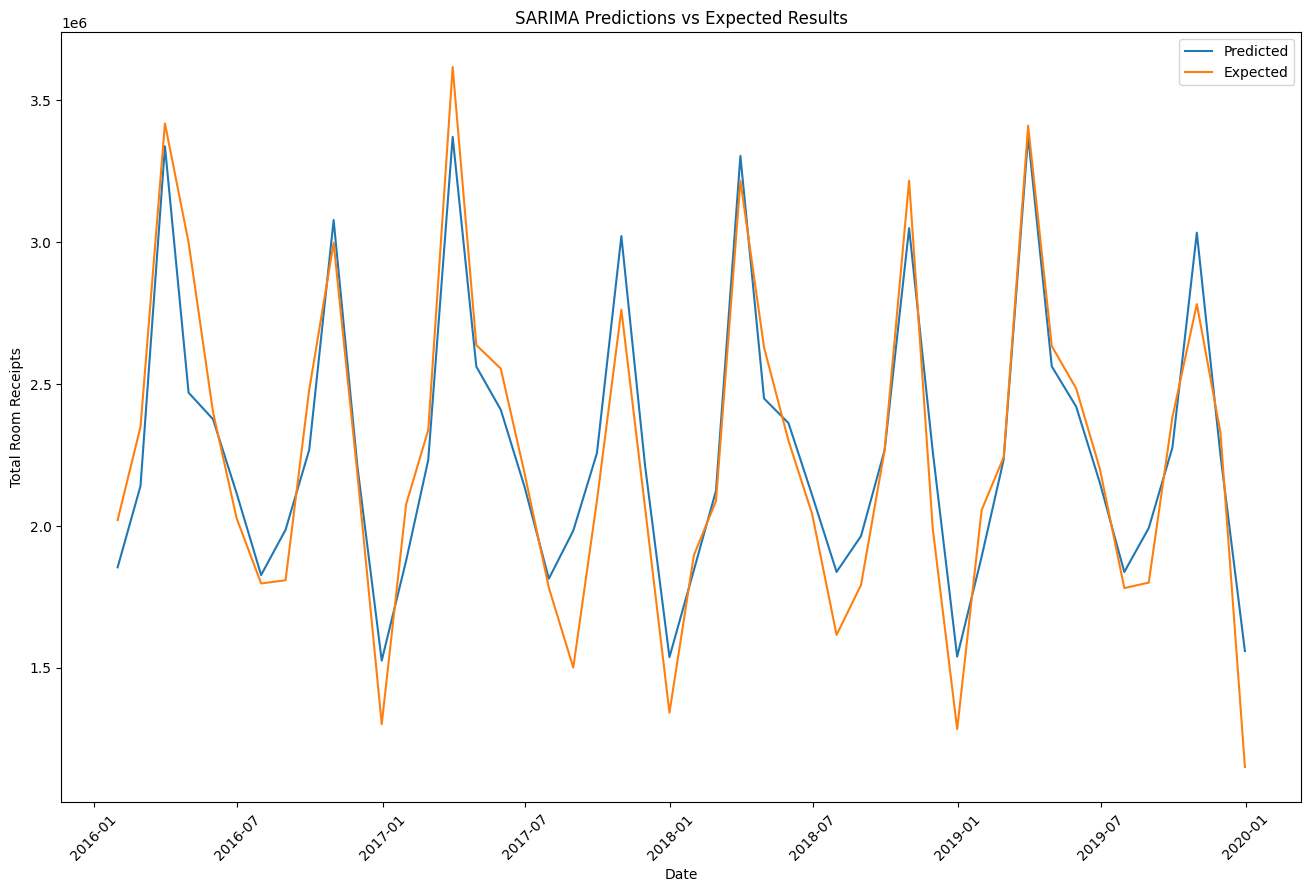

In [8]:
aic, yhat, model_fit = train_and_test(x, y, xtest, ytest, best_params)

# test model with start as first date in test data and end as last date in test data before 2019
print(f"Test data contains {ytest.shape[0]} months with start date {indices[0]} and end date {indices[-1]}")

# last item in indices in the year 2019
for i in range(0, ytest.shape[0]):
    if indices[i].year == 2019:
        end_idx = i
        end = indices[i]

print(f"Updating end date to {end} at index {end_idx}")
yhat = model_fit.get_prediction(start=len(y), end=len(y)+end_idx, exog=xtest[indices[0]:end], dynamic=indices[0])

# RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(ytest[:end_idx+1], yhat.predicted_mean))
print(f"RMSE: {rmse}")

# percentage error
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(ytest[:end_idx+1], yhat.predicted_mean)
print(f"MAPE (percent): {mape}")

# plot predictions and expected results
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 10))
plt.plot(indices[:end_idx+1], yhat.predicted_mean, label='Predicted')
plt.plot(indices[:end_idx+1], ytest[:end_idx+1], label='Expected')
plt.ylabel("Total Room Receipts")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.title("SARIMA Predictions vs Expected Results")
plt.legend()
plt.show()

In [38]:
# for all locations, fit a model and evaluate predictions
# calculate RMSE and MAPE for each location and store in a dataframe
# catch exceptions and skip those locations

# load data
df = pd.read_csv("./Om Data Loan/TrainingLoanData.csv")
df2 = pd.read_csv("./Om Data Loan/TestingLoanData.csv")

# clean data
df["Location Name"] = df["Location Name"].str.strip()
df2["Location Name"] = df2["Location Name"].str.strip()

# get unique locations where filer type is 50 and available units is greater than 50
df = df[df["Filer Type"] == 50]
df = df[df["Unit Capacity"] > 50]
locations = df["Location Name"].unique()

results = []

print(len(locations))

# iterate through locations
for idx, location in enumerate(locations[:1500]):
    print(f"Processing location {idx+1}: {location}")
    if len(results) > 200:
        break
    try:
        # clean data
        x, y, _ = clean_data_single_location(df, location)
        
        if len(x) > 200:
            print(f"Skipping {location} because multiple locations have been combined")
            continue

        xtest, ytest, indices = clean_data_single_location(df2, location)

        # get best params
        best_params = None
        best_aic = float("inf")
        for param in params:
            aic, _, _ = train_and_test(x, y, xtest, ytest, params[param])
            if aic < best_aic:
                best_aic = aic
                best_params = params[param]

        # train and test model
        aic, yhat, model_fit = train_and_test(x, y, xtest, ytest, best_params)

        # test model with start as first date in test data and end as last date in test data before 2019
        print(f"Test data contains {ytest.shape[0]} months with start date {indices[0]} and end date {indices[-1]}")

        # last item in indices in the year 2019
        for i in range(0, ytest.shape[0]):
            if indices[i].year == 2019:
                end_idx = i
                end = indices[i]

        print(f"Updating end date to {end} at index {end_idx}")
        yhat = model_fit.get_prediction(start=len(y), end=len(y)+end_idx, exog=xtest[indices[0]:end], dynamic=indices[0])

        # RMSE
        from sklearn.metrics import mean_squared_error
        from math import sqrt
        rmse = sqrt(mean_squared_error(ytest[:end_idx+1], yhat.predicted_mean))
        print(f"RMSE: {rmse}")

        # percentage error
        from sklearn.metrics import mean_absolute_percentage_error
        mape = mean_absolute_percentage_error(ytest[:end_idx+1], yhat.predicted_mean)
        print(f"MAPE (percent): {mape}")

        

        # calculate the RMSE and MAPE for one year of data
        yhat = model_fit.get_prediction(start=len(y), end=len(y)+11, exog=xtest[indices[0]:indices[11]], dynamic=indices[0])
        rmse_one_yr = sqrt(mean_squared_error(ytest[:12], yhat.predicted_mean))
        mape_one_yr = mean_absolute_percentage_error(ytest[:12], yhat.predicted_mean)

        # store results in dataframe
        results.append({"Location": location, "RMSE": rmse, "MAPE": mape, "RMSE One Year": rmse_one_yr, "MAPE One Year": mape_one_yr})
    except Exception as e:
        print(f"Error processing {location}: {e}")

C:\Users\antho\AppData\Local\Temp\ipykernel_43096\3724177751.py:6: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./Om Data Loan/TrainingLoanData.csv")
C:\Users\antho\AppData\Local\Temp\ipykernel_43096\3724177751.py:7: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv("./Om Data Loan/TestingLoanData.csv")


4710
Processing location 1: OMNI AUSTIN HOTEL AT FIC CENTRE
Num quarterly records: 0
Num monthly records: 179
Num quarterly records: 0
Num monthly records: 65


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test data contains 65 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 185726.00699660723
MAPE (percent): 0.07370082733464038
Processing location 2: DALLAS SHERATON SUITES @ MARKET CENTER
Num quarterly records: 0
Num monthly records: 78


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing DALLAS SHERATON SUITES @ MARKET CENTER: Neither `start` nor `end` can be NaT
Processing location 3: THE MAGNOLIA HOTEL
Num quarterly records: 0
Num monthly records: 308
Skipping THE MAGNOLIA HOTEL because multiple locations have been combined
Processing location 4: GLENROSE MOTOR INC
Num quarterly records: 0
Num monthly records: 26
Num quarterly records: 0
Num monthly records: 0
Error processing GLENROSE MOTOR INC: Neither `start` nor `end` can be NaT
Processing location 5: AMERICAN AIRLINES INC
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 198887.13359496385
MAPE (percent): 1.5523080951779446e+20
Processing location 6: HOTEL SOFITEL OF TEXAS INC
Num quarterly records: 0
Num monthly records: 24


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing HOTEL SOFITEL OF TEXAS INC: Neither `start` nor `end` can be NaT
Processing location 7: CLUB HOTEL BY DOUBLETREE
Num quarterly records: 0
Num monthly records: 68
Num quarterly records: 0
Num monthly records: 0
Error processing CLUB HOTEL BY DOUBLETREE: Neither `start` nor `end` can be NaT
Processing location 8: GUNTER HOTEL
Num quarterly records: 0
Num monthly records: 67
Num quarterly records: 0
Num monthly records: 0
Error processing GUNTER HOTEL: Neither `start` nor `end` can be NaT
Processing location 9: BEAUMONT HILTON
Num quarterly records: 0
Num monthly records: 45
Num quarterly records: 0
Num monthly records: 0
Error processing BEAUMONT HILTON: Neither `start` nor `end` can be NaT
Processing location 10: HAMPTON INN
Num quarterly records: 0
Num monthly records: 6032
Skipping HAMPTON INN because multiple locations have been combined
Processing location 11: AMERISUITES SI
Num quarterly records: 0
Num monthly records

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 25
Num quarterly records: 0
Num monthly records: 0
Error processing RAMADA INN ORANGE: Neither `start` nor `end` can be NaT
Processing location 19: RAMADA INN-PORT ARTHUR
Num quarterly records: 0
Num monthly records: 41
Num quarterly records: 0
Num monthly records: 0
Error processing RAMADA INN-PORT ARTHUR: Neither `start` nor `end` can be NaT
Processing location 20: THE MELROSE HOTEL
Num quarterly records: 0
Num monthly records: 73
Num quarterly records: 0
Num monthly records: 0
Error processing THE MELROSE HOTEL: Neither `start` nor `end` can be NaT
Processing location 21: ABILENE EMBASSY SUITES
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 0
Error processing ABILENE EMBASSY SUITES: Neither `start` nor `end` can be NaT
Processing location 22: AMARILLO AMBASSADOR HOTEL
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 0
Error processing AMARILLO A

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test data contains 65 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 36647.68543640655
MAPE (percent): 0.1657771996931415
Processing location 37: HOMEWOOD SUITES - SAN ANTONIO NW #9721
Num quarterly records: 0
Num monthly records: 12


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'


Num quarterly records: 0
Num monthly records: 0
Error processing HOMEWOOD SUITES - SAN ANTONIO NW #9721: Neither `start` nor `end` can be NaT
Processing location 38: HAMPTON INN - FORT WORTH
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 0
Error processing HAMPTON INN - FORT WORTH: Neither `start` nor `end` can be NaT
Processing location 39: HAMPTON INN - COLLEGE STATION
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 0
Error processing HAMPTON INN - COLLEGE STATION: Neither `start` nor `end` can be NaT
Processing location 40: HAMPTON INN - ARLINGTON
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 0
Error processing HAMPTON INN - ARLINGTON: Neither `start` nor `end` can be NaT
Processing location 41: HAMPTON INN - AUSTIN
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 0
Error processing HAMPTON INN -

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing BEST WESTERN AIRPORT INN: Neither `start` nor `end` can be NaT
Processing location 74: ECONO LODGE
Num quarterly records: 0
Num monthly records: 2200
Skipping ECONO LODGE because multiple locations have been combined
Processing location 75: RENAISSANCE AUSTIN HOTEL
Num quarterly records: 0
Num monthly records: 100
Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 306089.8132281376
MAPE (percent): 0.1361919342418653
Processing location 76: RENAISSANCE DALLAS HOTEL
Num quarterly records: 0
Num monthly records: 54


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'


Num quarterly records: 0
Num monthly records: 0
Error processing RENAISSANCE DALLAS HOTEL: Neither `start` nor `end` can be NaT
Processing location 77: DOUBLETREE HOTEL
Num quarterly records: 0
Num monthly records: 121
Num quarterly records: 0
Num monthly records: 0
Error processing DOUBLETREE HOTEL: Neither `start` nor `end` can be NaT
Processing location 78: SPRINGHILL SUITES - AUSTIN SOUTH
Num quarterly records: 0
Num monthly records: 58
Num quarterly records: 0
Num monthly records: 0
Error processing SPRINGHILL SUITES - AUSTIN SOUTH: Neither `start` nor `end` can be NaT
Processing location 79: FAIRFIELD INN AUSTIN SOUTH
Num quarterly records: 0
Num monthly records: 182
Num quarterly records: 0
Num monthly records: 47


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 47 months with start date 2016-01-31 00:00:00 and end date 2019-11-30 00:00:00
Updating end date to 2019-11-30 00:00:00 at index 46
Error processing FAIRFIELD INN AUSTIN SOUTH: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 80: FAIRFIELD INN AUSTIN NORTH
Num quarterly records: 0
Num monthly records: 67


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 0
Error processing FAIRFIELD INN AUSTIN NORTH: Neither `start` nor `end` can be NaT
Processing location 81: FAIRFIELD INN - SAN ANTONIO AIRPORT
Num quarterly records: 0
Num monthly records: 66
Num quarterly records: 0
Num monthly records: 0
Error processing FAIRFIELD INN - SAN ANTONIO AIRPORT: Neither `start` nor `end` can be NaT
Processing location 82: RESIDENCE INN HOUSTON GALLERIA
Num quarterly records: 0
Num monthly records: 66
Num quarterly records: 0
Num monthly records: 0
Error processing RESIDENCE INN HOUSTON GALLERIA: Neither `start` nor `end` can be NaT
Processing location 83: COURTYARD BY MARRIOTT - AUSTIN NORTHWEST
Num quarterly records: 0
Num monthly records: 66
Num quarterly records: 0
Num monthly records: 0
Error processing COURTYARD BY MARRIOTT - AUSTIN NORTHWEST: Neither `start` nor `end` can be NaT
Processing location 84: RESIDENCE INN - AUSTIN NORTHWEST
Num quarterly records: 0
Num monthly records: 66
Num quarterly record

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing FAIRFIELD INN SAN ANTONIO DOWNTOWN: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 92: RESIDENCE INN - SAN ANTONIO DOWNTOWN
Num quarterly records: 0
Num monthly records: 72


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 0
Error processing RESIDENCE INN - SAN ANTONIO DOWNTOWN: Neither `start` nor `end` can be NaT
Processing location 93: COURTYARD BY MARRIOTT - MESQUITE
Num quarterly records: 0
Num monthly records: 72
Num quarterly records: 0
Num monthly records: 0
Error processing COURTYARD BY MARRIOTT - MESQUITE: Neither `start` nor `end` can be NaT
Processing location 94: RESIDENCE INN-AUSTIN NORTH
Num quarterly records: 0
Num monthly records: 66
Num quarterly records: 0
Num monthly records: 0
Error processing RESIDENCE INN-AUSTIN NORTH: Neither `start` nor `end` can be NaT
Processing location 95: HOLIDAY INN AUSTIN NORTHWEST
Num quarterly records: 0
Num monthly records: 65
Num quarterly records: 0
Num monthly records: 0
Error processing HOLIDAY INN AUSTIN NORTHWEST: Neither `start` nor `end` can be NaT
Processing location 96: COLLEGE STATION HILTON
Num quarterly records: 0
Num monthly records: 50
Num quarterly records: 0
Num monthly records: 0
Error proc

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing HYATT REGENCY AUSTIN: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 100: HYATT REGENCY HOUSTON AIRPORT
Num quarterly records: 0
Num monthly records: 60


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 0
Error processing HYATT REGENCY HOUSTON AIRPORT: Neither `start` nor `end` can be NaT
Processing location 101: STAFFORD MICROTEL
Num quarterly records: 0
Num monthly records: 5
Num quarterly records: 0
Num monthly records: 0
Error processing STAFFORD MICROTEL: Neither `start` nor `end` can be NaT
Processing location 102: AMERIHOST INN MCKINNEY
Num quarterly records: 0
Num monthly records: 54
Num quarterly records: 0
Num monthly records: 0
Error processing AMERIHOST INN MCKINNEY: Neither `start` nor `end` can be NaT
Processing location 103: AMERISUITES HOUSTON/GREENSPOINT
Num quarterly records: 0
Num monthly records: 21
Num quarterly records: 0
Num monthly records: 0
Error processing AMERISUITES HOUSTON/GREENSPOINT: Neither `start` nor `end` can be NaT
Processing location 104: AMERISUITES SAN ANTONIO/AIRPORT
Num quarterly records: 0
Num monthly records: 21
Num quarterly records: 0
Num monthly records: 0
Error processing AMERISUITES SAN ANTO

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing DRURY INN & SUITES HOUSTON-SUGAR LAND: Neither `start` nor `end` can be NaT
Processing location 129: ADAM'S MARK HOTEL
Num quarterly records: 0
Num monthly records: 36
Num quarterly records: 0
Num monthly records: 0
Error processing ADAM'S MARK HOTEL: Neither `start` nor `end` can be NaT
Processing location 130: DRURY INN - AUSTIN NORTH
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 54
Test data contains 54 months with start date 2016-01-31 00:00:00 and end date 2021-01-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 105256.70291840695
MAPE (percent): 0.14845648150092206
Processing location 131: PEARTREE INN SAN ANTONIO AIRPORT
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 51057.404379527135
MAPE (percent): 0.19098087864337732
Processing location 132: DRURY INN MCALLEN
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 203107.97137422825
MAPE (percent): 5.888960577025532e+20
Processing location 133: HAMPTON INN MCALLEN
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 54
Test data contains 54 months with start date 2016-01-31 00:00:00 and end date 2021-01-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 104184.2270889622
MAPE (percent): 4.117544848930503e+20
Processing location 134: HAMPTON INN DALLAS-FORT WORTH
Num quarterly records: 0
Num monthly records: 58


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing HAMPTON INN DALLAS-FORT WORTH: Neither `start` nor `end` can be NaT
Processing location 135: BEST WESTERN POSADA INN-MEDICAL CTR
Num quarterly records: 0
Num monthly records: 183
Num quarterly records: 0
Num monthly records: 66


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing BEST WESTERN POSADA INN-MEDICAL CTR: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 136: POSADA ANA INN
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 239852.54118173526
MAPE (percent): 7.540106827171054e+20
Processing location 137: STAYBRIDGE HES-SAN ANTONIO AIRPORT
Num quarterly records: 0
Num monthly records: 66


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing STAYBRIDGE HES-SAN ANTONIO AIRPORT: Neither `start` nor `end` can be NaT
Processing location 138: BEST WESTERN CASA LINDA SAN ANTOIO AIRPORT
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 124017.70034493541
MAPE (percent): 0.45605584883844336
Processing location 139: THRIFTY INN MCALLEN
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 84264.08479363675
MAPE (percent): 2.3544061350549455e+20
Processing location 140: HOLIDAY EXPRESS SAN ANTONIO AIRPORT
Num quarterly records: 0
Num monthly records: 73


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing HOLIDAY EXPRESS SAN ANTONIO AIRPORT: Neither `start` nor `end` can be NaT
Processing location 141: HAMPTON INN SAN ANTONIO EAST
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 55585.85512867946
MAPE (percent): 0.32410164094253585
Processing location 142: DRURY INN & SUITES SAN ANTONIO
Num quarterly records: 0
Num monthly records: 75


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing DRURY INN & SUITES SAN ANTONIO: Neither `start` nor `end` can be NaT
Processing location 143: DRURY INN & SUTIES SAN ANTONIO RIVERWALK
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 57262.240247904934
MAPE (percent): 0.0838421287020638
Processing location 144: DRURY INN AUSTIN
Num quarterly records: 0
Num monthly records: 69


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing DRURY INN AUSTIN: Neither `start` nor `end` can be NaT
Processing location 145: DRURY INN D/FW AIRPORT
Num quarterly records: 0
Num monthly records: 81
Num quarterly records: 0
Num monthly records: 0
Error processing DRURY INN D/FW AIRPORT: Neither `start` nor `end` can be NaT
Processing location 146: DRURY INN DALLAS NW
Num quarterly records: 0
Num monthly records: 58
Num quarterly records: 0
Num monthly records: 0
Error processing DRURY INN DALLAS NW: Neither `start` nor `end` can be NaT
Processing location 147: DRURY INN CORPUS CHRISTI
Num quarterly records: 0
Num monthly records: 97
Num quarterly records: 0
Num monthly records: 0
Error processing DRURY INN CORPUS CHRISTI: Neither `start` nor `end` can be NaT
Processing location 148: DRURY INN SAN ANTONIO EAST
Num quarterly records: 0
Num monthly records: 81
Num quarterly records: 0
Num monthly records: 0
Error processing DRURY INN SAN ANTONIO EAST: Neither `start` nor

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 67 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing FOUR SEASONS HOTEL AUSTIN: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 150: EMBASSY SUITE OUTDOOR WORLD DFW
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 65
Test data contains 65 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 1630127.386185615
MAPE (percent): 0.14179084699530745
Processing location 151: HAMPTON INN & SUITES
Num quarterly records: 0
Num monthly records: 4949
Skipping HAMPTON INN & SUITES because multiple locations have been combined
Processing location 152: RAMADA INN DFW WEST/EULESS


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 29
Num quarterly records: 0
Num monthly records: 0
Error processing RAMADA INN DFW WEST/EULESS: Neither `start` nor `end` can be NaT
Processing location 153: HOTEL EQUITY FUND II LP
Num quarterly records: 0
Num monthly records: 143
Num quarterly records: 0
Num monthly records: 0
Error processing HOTEL EQUITY FUND II LP: Neither `start` nor `end` can be NaT
Processing location 154: DRURY INN HOUSTON GALLERIA
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 54
Test data contains 54 months with start date 2016-01-31 00:00:00 and end date 2021-01-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 72980.87667852639
MAPE (percent): 0.18251838796402456
Processing location 155: DRURY INN HOUSTON THE WOODLAND
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 54
Test data contains 54 months with start date 2016-01-31 00:00:00 and end date 2021-01-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 65432.89304369012
MAPE (percent): 0.1783471013141226
Processing location 156: COUNTRY INN & SUITES
Num quarterly records: 0
Num monthly records: 1669
Skipping COUNTRY INN & SUITES because multiple locations have been combined
Processing location 157: CORPUS CHRISTI FAIRFIELD INN


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 65
Test data contains 65 months with start date 2016-01-31 00:00:00 and end date 2022-11-30 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 30084.83807082545
MAPE (percent): 0.15987625377363351
Processing location 158: BRYAN FAIRFIELD INN
Num quarterly records: 0
Num monthly records: 172


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing BRYAN FAIRFIELD INN: Neither `start` nor `end` can be NaT
Processing location 159: TEMPLE FAIRFIELD INN
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 65
Test data contains 65 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 14246.081798505415
MAPE (percent): 0.09641740185610141
Processing location 160: CORPUS CHRISTI RESIDENCE INN
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 55371.48534052991
MAPE (percent): 0.26256530726965255
Processing location 161: COUNTRY INN AND STUITES
Num quarterly records: 0
Num monthly records: 172


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing COUNTRY INN AND STUITES: Neither `start` nor `end` can be NaT
Processing location 162: WACO FAIRFIELD INN
Num quarterly records: 0
Num monthly records: 172
Num quarterly records: 0
Num monthly records: 0
Error processing WACO FAIRFIELD INN: Neither `start` nor `end` can be NaT
Processing location 163: LEWISVILLE COMFORT SUITES
Num quarterly records: 0
Num monthly records: 178
Num quarterly records: 0
Num monthly records: 0
Error processing LEWISVILLE COMFORT SUITES: Neither `start` nor `end` can be NaT
Processing location 164: LONGVIEW TX COMFORT SUITES
Num quarterly records: 0
Num monthly records: 157
Num quarterly records: 0
Num monthly records: 0
Error processing LONGVIEW TX COMFORT SUITES: Neither `start` nor `end` can be NaT
Processing location 165: TYLER TX FAIRFIELD INN
Num quarterly records: 0
Num monthly records: 172
Num quarterly records: 0
Num monthly records: 0
Error processing TYLER TX FAIRFIELD INN: Neither 

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing ABILENE FAIRFIELD INN: Neither `start` nor `end` can be NaT
Processing location 170: ABILENE HAMPTON INN
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 22295.022960813876
MAPE (percent): 0.1271642242653102
Processing location 171: WICHITA FALLS FAIRFIELD INN
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 12
Test data contains 12 months with start date 2016-01-31 00:00:00 and end date 2016-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing WICHITA FALLS FAIRFIELD INN: Provided exogenous values are not of the appropriate shape. Required (48, 1), got (12,).
Processing location 172: LUBBOCK HAMPTON INN
Num quarterly records: 0
Num monthly records: 176
Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 61355.83091840071
MAPE (percent): 0.24035162251514575
Processing location 173: AMARILLO RESIDENCE INN
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'


Num quarterly records: 0
Num monthly records: 67
Test data contains 67 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 48811.340789807924
MAPE (percent): 0.20835447797033235
Processing location 174: SAN ANGELOL HAMPTON INN
Num quarterly records: 0
Num monthly records: 172


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing SAN ANGELOL HAMPTON INN: Neither `start` nor `end` can be NaT
Processing location 175: AUSTIN COMFORT INN
Num quarterly records: 0
Num monthly records: 41
Num quarterly records: 0
Num monthly records: 0
Error processing AUSTIN COMFORT INN: Neither `start` nor `end` can be NaT
Processing location 176: AMARILLO FAIRFIELD INN
Num quarterly records: 0
Num monthly records: 172
Num quarterly records: 0
Num monthly records: 0
Error processing AMARILLO FAIRFIELD INN: Neither `start` nor `end` can be NaT
Processing location 177: LUBBOCK COURTYARD INN
Num quarterly records: 0
Num monthly records: 173
Num quarterly records: 0
Num monthly records: 0
Error processing LUBBOCK COURTYARD INN: Neither `start` nor `end` can be NaT
Processing location 178: VICTORIA FAIRFIELD INN
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 53
Test data contains 53 months with start date 2016-01-31 00:00:00 

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 53
Test data contains 53 months with start date 2016-01-31 00:00:00 and end date 2020-05-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 29818.927362459923
MAPE (percent): 9.2264808446412e+18
Processing location 180: TEXAS CITY HAMPTON INN
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 4
Test data contains 4 months with start date 2016-01-31 00:00:00 and end date 2016-04-30 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing TEXAS CITY HAMPTON INN: Provided exogenous values are not of the appropriate shape. Required (48, 1), got (4,).
Processing location 181: PLANO FAIRFIELD INN
Num quarterly records: 0
Num monthly records: 172
Num quarterly records: 0
Num monthly records: 0
Error processing PLANO FAIRFIELD INN: Neither `start` nor `end` can be NaT
Processing location 182: LOVEFIELD HOLIDAY INN EXPRESS
Num quarterly records: 0
Num monthly records: 55
Num quarterly records: 0
Num monthly records: 0
Error processing LOVEFIELD HOLIDAY INN EXPRESS: Neither `start` nor `end` can be NaT
Processing location 183: LOVEFIELD QUALITY SUITES
Num quarterly records: 0
Num monthly records: 46
Num quarterly records: 0
Num monthly records: 0
Error processing LOVEFIELD QUALITY SUITES: Neither `start` nor `end` ca

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing HOUSTON TOWNE PLACE GALLERIA: Neither `start` nor `end` can be NaT
Processing location 191: WOODLANDS COURTYARD
Num quarterly records: 0
Num monthly records: 115
Num quarterly records: 0
Num monthly records: 0
Error processing WOODLANDS COURTYARD: Neither `start` nor `end` can be NaT
Processing location 192: WOODLANDS RESIDENCE INN
Num quarterly records: 0
Num monthly records: 173
Num quarterly records: 0
Num monthly records: 0
Error processing WOODLANDS RESIDENCE INN: Neither `start` nor `end` can be NaT
Processing location 193: HOUSTON SPRINGHILL SUITES
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 69546.6459372724
MAPE (percent): 0.34762357926481896
Processing location 194: LEWISVILLE RESIDENCE INN
Num quarterly 

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 31763.31326215652
MAPE (percent): 0.14310312114432608
Processing location 195: BEDFORD TOWNE PLACE SUITES
Num quarterly records: 0
Num monthly records: 172


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing BEDFORD TOWNE PLACE SUITES: Neither `start` nor `end` can be NaT
Processing location 196: WACO RESIDENCE INN
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 65
Test data contains 65 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 27622.710387550374
MAPE (percent): 0.0857604098209203
Processing location 197: STAFFORD HAMPTON INN
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 35328.54485098992
MAPE (percent): 0.1707841821144124
Processing location 198: WILLOWBROOK HAMPTON INN
Num quarterly records: 0
Num monthly records: 295
Skipping WILLOWBROOK HAMPTON INN because multiple locations have been combined
Processing location 199: WAGON POINT FAIRFIELD INN


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 172
Num quarterly records: 0
Num monthly records: 0
Error processing WAGON POINT FAIRFIELD INN: Neither `start` nor `end` can be NaT
Processing location 200: HUMBLE FAIRFIELD INN
Num quarterly records: 0
Num monthly records: 172
Num quarterly records: 0
Num monthly records: 0
Error processing HUMBLE FAIRFIELD INN: Neither `start` nor `end` can be NaT
Processing location 201: MESQUITE FAIRFIELD INN
Num quarterly records: 0
Num monthly records: 172
Num quarterly records: 0
Num monthly records: 0
Error processing MESQUITE FAIRFIELD INN: Neither `start` nor `end` can be NaT
Processing location 202: DALLAS/GREENVILLE HOMEWOOD
Num quarterly records: 0
Num monthly records: 175
Num quarterly records: 0
Num monthly records: 0
Error processing DALLAS/GREENVILLE HOMEWOOD: Neither `start` nor `end` can be NaT
Processing location 203: DALLAS/GREENVILLE FAIRFIELD INN
Num quarterly records: 0
Num monthly records: 172
Num quarterly records: 0
Num monthly r

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Error processing WYNDHAM GARDEN HOTEL: Provided exogenous values are not of the appropriate shape. Required (15, 1), got (33,).
Processing location 209: ECONO LODGE INN & SUITES
Num quarterly records: 0
Num monthly records: 191
Num quarterly records: 5
Num monthly records: 339


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\

Error processing ECONO LODGE INN & SUITES: Provided exogenous values are not of the appropriate shape. Required (149, 1), got (339,).
Processing location 210: VICTORIAN INN & SUITES
Num quarterly records: 0
Num monthly records: 115
Num quarterly records: 0
Num monthly records: 122
Error processing VICTORIAN INN & SUITES: Provided exogenous values are not of the appropriate shape. Required (8, 1), got (122,).
Processing location 211: SCOTSMAN INN
Num quarterly records: 0
Num monthly records: 53
Num quarterly records: 0
Num monthly records: 0
Error processing SCOTSMAN INN: Neither `start` nor `end` can be NaT
Processing location 212: SCOTSMAN INN-SA EAST
Num quarterly records: 0
Num monthly records: 43
Num quarterly records: 0
Num monthly records: 0
Error processing SCOTSMAN INN-SA EAST: Neither `start` nor `end` can be NaT
Processing location 213: OAK TREE INN
Num quarterly records: 0
Num monthly records: 88
Num quarterly records: 0
Num monthly records: 67


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages

Test data contains 67 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 137819.9481846117
MAPE (percent): 10.168957786429205
Processing location 214: CANDLEWOOD HOTEL FT WORTH TX- TANACROSS LLC
Num quarterly records: 0
Num monthly records: 16


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'


Num quarterly records: 0
Num monthly records: 0
Error processing CANDLEWOOD HOTEL FT WORTH TX- TANACROSS LLC: Neither `start` nor `end` can be NaT
Processing location 215: CANDLEWOOD HOTEL
Num quarterly records: 0
Num monthly records: 216
Skipping CANDLEWOOD HOTEL because multiple locations have been combined
Processing location 216: CANDLEWOOD SUITES
Num quarterly records: 0
Num monthly records: 2899
Skipping CANDLEWOOD SUITES because multiple locations have been combined
Processing location 217: SHERATON ASTRODOME
Num quarterly records: 0
Num monthly records: 22
Num quarterly records: 0
Num monthly records: 0
Error processing SHERATON ASTRODOME: Neither `start` nor `end` can be NaT
Processing location 218: DAY'S INN ASTRODOME
Num quarterly records: 0
Num monthly records: 22
Num quarterly records: 0
Num monthly records: 0
Error processing DAY'S INN ASTRODOME: Neither `start` nor `end` can be NaT
Processing location 219: HOLIDAY INN ASTRODOME
Num quarterly records: 0
Num monthly record

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 325547.6712252755
MAPE (percent): 0.1672520312659329
Processing location 223: DALLAS-ADDISON COURTYARD NO 1M3
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 51
Test data contains 51 months with start date 2016-01-31 00:00:00 and end date 2020-03-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 133322.77471664097
MAPE (percent): 5.1918244440247874e+20
Processing location 224: DALLAS LBJ AT JOSEY COURTYARD IM4
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 51
Test data contains 51 months with start date 2016-01-31 00:00:00 and end date 2020-03-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 81595.00138436882
MAPE (percent): 2.252826902511476e+20
Processing location 225: DALLAS-LAS COLINAS COURTYARD # IM2
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 116645.30166997001
MAPE (percent): 0.25903340437885736
Processing location 226: SAN ANTONIO AIRPORT COURTYARD #1M7
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 51
Test data contains 51 months with start date 2016-01-31 00:00:00 and end date 2020-03-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 128253.83414782344
MAPE (percent): 1.991568526641222e+20
Processing location 227: SAN ANTONIO MEDICAL CENTER COURTYARD #1M6
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 51
Test data contains 51 months with start date 2016-01-31 00:00:00 and end date 2020-03-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 119585.71405401362
MAPE (percent): 1.67329718881029e+20
Processing location 228: FORT WORTH BEDFORD COURTYARD #1M5
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 51
Test data contains 51 months with start date 2016-01-31 00:00:00 and end date 2020-03-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 70905.73540453517
MAPE (percent): 2.669052444880296e+20
Processing location 229: ARLINGTON COURTYARD #1M1
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 65192.594992679864
MAPE (percent): 0.12921943453995158
Processing location 230: SAN ANTONIO DOWNTOWN MARKET SQ #1N7
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 41357.115292766575
MAPE (percent): 0.08660245447146375
Processing location 231: DALLAS RICHARDSON COURTYARD #1N2
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 88828.93859994237
MAPE (percent): 0.2596384541734986
Processing location 232: DALLAS LOVEFIELD STEMMONS COURTYARD #1N1
Num quarterly records: 0
Num monthly records: 72


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing DALLAS LOVEFIELD STEMMONS COURTYARD #1N1: Neither `start` nor `end` can be NaT
Processing location 233: DALLAS PLANO COURTYARD #1N4
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 111971.02853821295
MAPE (percent): 0.3047107327327344
Processing location 234: JW MARRIOTT HOUSTON #785
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 299880.0506632635
MAPE (percent): 0.13309040805512284
Processing location 235: LUBBOCK RESIDENCE INN NO 416
Num quarterly records: 0
Num monthly records: 91


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing LUBBOCK RESIDENCE INN NO 416: Neither `start` nor `end` can be NaT
Processing location 236: SLEEP INN #761
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 0
Error processing SLEEP INN #761: Neither `start` nor `end` can be NaT
Processing location 237: SLEEP INN #769
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 0
Error processing SLEEP INN #769: Neither `start` nor `end` can be NaT
Processing location 238: SLEEP INN #748
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 0
Error processing SLEEP INN #748: Neither `start` nor `end` can be NaT
Processing location 239: MAINSTAY SUITES #850
Num quarterly records: 0
Num monthly records: 30
Num quarterly records: 0
Num monthly records: 0
Error processing MAINSTAY SUITES #850: Neither `start` nor `end` can be NaT
Processing location 240: SLE

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'


Num quarterly records: 0
Num monthly records: 0
Error processing DALLAS COLINAS RESIDENCE INN NO 314: Neither `start` nor `end` can be NaT
Processing location 245: HOUSTON CLEARLAKE RESIDENCE INN NO 313
Num quarterly records: 0
Num monthly records: 102
Num quarterly records: 0
Num monthly records: 0
Error processing HOUSTON CLEARLAKE RESIDENCE INN NO 313: Neither `start` nor `end` can be NaT
Processing location 246: DALLAS-NORTHPARK COURTYARD #1N9
Num quarterly records: 0
Num monthly records: 27
Num quarterly records: 0
Num monthly records: 0
Error processing DALLAS-NORTHPARK COURTYARD #1N9: Neither `start` nor `end` can be NaT
Processing location 247: FORT WORTH/BLACKSTONE COURTYARD #1NA
Num quarterly records: 0
Num monthly records: 9
Num quarterly records: 0
Num monthly records: 0
Error processing FORT WORTH/BLACKSTONE COURTYARD #1NA: Neither `start` nor `end` can be NaT
Processing location 248: DALLAS MARKET CENTER RESIDENCE INN #312
Num quarterly records: 0
Num monthly records: 126

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 491968.50465057034
MAPE (percent): 0.10084613852659079
Processing location 252: FOSSIL CREEK RESIDENCE INN #319
Num quarterly records: 0
Num monthly records: 159


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing FOSSIL CREEK RESIDENCE INN #319: Neither `start` nor `end` can be NaT
Processing location 253: ALAMO PLAZA RESIDENCE INN #320
Num quarterly records: 0
Num monthly records: 159
Num quarterly records: 0
Num monthly records: 0
Error processing ALAMO PLAZA RESIDENCE INN #320: Neither `start` nor `end` can be NaT
Processing location 254: RICHARDSON RESIDENCE INN #322
Num quarterly records: 0
Num monthly records: 159
Num quarterly records: 0
Num monthly records: 0
Error processing RICHARDSON RESIDENCE INN #322: Neither `start` nor `end` can be NaT
Processing location 255: FOSSIL CREEK COURTYARD #1Q2
Num quarterly records: 0
Num monthly records: 159
Num quarterly records: 0
Num monthly records: 0
Error processing FOSSIL CREEK COURTYARD #1Q2: Neither `start` nor `end` can be NaT
Processing location 256: CLARION HOTEL #765
Num quarterly records: 0
Num monthly records: 10
Num quarterly records: 0
Num monthly records: 0
Error proces

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing HOBBY AIRPORT COURTYARD BY MARRIOTT 1MD: Neither `start` nor `end` can be NaT
Processing location 260: DALLAS/RICHARDSON COURTYARD 1NF
Num quarterly records: 0
Num monthly records: 159
Num quarterly records: 0
Num monthly records: 0
Error processing DALLAS/RICHARDSON COURTYARD 1NF: Neither `start` nor `end` can be NaT
Processing location 261: HOMEWOOD SUITES
Num quarterly records: 0
Num monthly records: 1070
Skipping HOMEWOOD SUITES because multiple locations have been combined
Processing location 262: HAMPTON INN DUNCANVILLE
Num quarterly records: 0
Num monthly records: 9
Num quarterly records: 0
Num monthly records: 0
Error processing HAMPTON INN DUNCANVILLE: Neither `start` nor `end` can be NaT
Processing location 263: HOLIDAY INN DALLAS
Num quarterly records: 0
Num monthly records: 18
Num quarterly records: 0
Num monthly records: 0
Error processing HOLIDAY INN DALLAS: Neither `start` nor `end` can be NaT
Processing lo

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing AMERISUITES (AL): Neither `start` nor `end` can be NaT
Processing location 280: AMERISUITES (DP)
Num quarterly records: 0
Num monthly records: 46
Num quarterly records: 0
Num monthly records: 0
Error processing AMERISUITES (DP): Neither `start` nor `end` can be NaT
Processing location 281: AMERISUITES (DW)
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 0
Error processing AMERISUITES (DW): Neither `start` nor `end` can be NaT
Processing location 282: AMERISUITES (HR)
Num quarterly records: 0
Num monthly records: 46
Num quarterly records: 0
Num monthly records: 0
Error processing AMERISUITES (HR): Neither `start` nor `end` can be NaT
Processing location 283: AMERISUITES (IG)
Num quarterly records: 0
Num monthly records: 46
Num quarterly records: 0
Num monthly records: 0
Error processing AMERISUITES (IG): Neither `start` nor `end` can be NaT
Processing location 284: AMERISUITES

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing RENAISSANCE WORTHINGTON HOTEL: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 316: HOMEWOOD SUITES #9757
Num quarterly records: 0
Num monthly records: 101


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 0
Error processing HOMEWOOD SUITES #9757: Neither `start` nor `end` can be NaT
Processing location 317: DOUBLETREE GUEST SUITES
Num quarterly records: 0
Num monthly records: 94
Num quarterly records: 0
Num monthly records: 0
Error processing DOUBLETREE GUEST SUITES: Neither `start` nor `end` can be NaT
Processing location 318: RAMADA LIMITED
Num quarterly records: 0
Num monthly records: 1151
Skipping RAMADA LIMITED because multiple locations have been combined
Processing location 319: HOMEWOOD SUITES PLANO
Num quarterly records: 0
Num monthly records: 165
Num quarterly records: 0
Num monthly records: 0
Error processing HOMEWOOD SUITES PLANO: Neither `start` nor `end` can be NaT
Processing location 320: HOMEWOOD SUITES LAS COLINAS
Num quarterly records: 0
Num monthly records: 165
Num quarterly records: 0
Num monthly records: 0
Error processing HOMEWOOD SUITES LAS COLINAS: Neither `start` nor `end` can be NaT
Processing location 321: HOMEWOOD

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Error processing RAMADA HOTEL: Provided exogenous values are not of the appropriate shape. Required (33, 1), got (43,).
Processing location 325: VALU-LODGE INC
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 0
Error processing VALU-LODGE INC: Neither `start` nor `end` can be NaT
Processing location 326: VALU-LODGE OF EL PASO #2 INC
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 0
Error processing VALU-LODGE OF EL PASO #2 INC: Neither `start` nor `end` can be NaT
Processing location 327: INTOWN SUITES SAN ANTONIO N #137
Num quarterly records: 0
Num monthly records: 18
Num quarterly records: 0
Num monthly records: 0
Error processing INTOWN SUITES SAN ANTONIO N #137: Neither `start` nor `end` can be NaT
Processing location 328: INTOWN SUITES -DALLAS PARK CENTRAL #144
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months wi

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing INTOWN SUITES DALLAS-CARROLLTON #138: Neither `start` nor `end` can be NaT
Processing location 330: INTOWN SUITES-EL PASO #138
Num quarterly records: 0
Num monthly records: 18
Num quarterly records: 0
Num monthly records: 0
Error processing INTOWN SUITES-EL PASO #138: Neither `start` nor `end` can be NaT
Processing location 331: INTOWN SUITES-HOUSTON FM 1960 #138
Num quarterly records: 0
Num monthly records: 18
Num quarterly records: 0
Num monthly records: 0
Error processing INTOWN SUITES-HOUSTON FM 1960 #138: Neither `start` nor `end` can be NaT
Processing location 332: INTOWN SUITES-HOUSTON WEBSTER #132
Num quarterly records: 0
Num monthly records: 18
Num quarterly records: 0
Num monthly records: 0
Error processing INTOWN SUITES-HOUSTON WEBSTER #132: Neither `start` nor `end` can be NaT
Processing location 333: INTOWN SUITES-SAN ANTONIO NE #137
Num quarterly records: 0
Num monthly records: 18
Num quarterly records: 0
Nu

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 20169.863611529097
MAPE (percent): 0.12839330949961403
Processing location 345: INTOWN SUITES WEST OAKS LLC
Num quarterly records: 0
Num monthly records: 24


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing INTOWN SUITES WEST OAKS LLC: Neither `start` nor `end` can be NaT
Processing location 346: INTOWN SUITES NORTH DALLAS LLC
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 26771.443601412073
MAPE (percent): 0.1943650888160963
Processing location 347: INTOWN SUITES HIGHWAY 121, L.P.
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 18824.266668311968
MAPE (percent): 0.12666906740585568
Processing location 348: INTOWN SUITES ARLINGTON LLC
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 17377.754520626015
MAPE (percent): 0.1218649859221348
Processing location 349: INTOWN SUITES HIGHWAY 6 L P
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 26932.728194190535
MAPE (percent): 0.24858457602066739
Processing location 350: INTOWN SUITES STUEBNER AIRLINE
Num quarterly records: 0
Num monthly records: 12


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing INTOWN SUITES STUEBNER AIRLINE: Neither `start` nor `end` can be NaT
Processing location 351: SUN SUITES OF STAFFORD
Num quarterly records: 0
Num monthly records: 173
Num quarterly records: 0
Num monthly records: 0
Error processing SUN SUITES OF STAFFORD: Neither `start` nor `end` can be NaT
Processing location 352: SUN SUITES OF CLEARLAKE
Num quarterly records: 0
Num monthly records: 173
Num quarterly records: 0
Num monthly records: 0
Error processing SUN SUITES OF CLEARLAKE: Neither `start` nor `end` can be NaT
Processing location 353: SUNSUITES OF GREENSPOINT
Num quarterly records: 0
Num monthly records: 102
Num quarterly records: 0
Num monthly records: 0
Error processing SUNSUITES OF GREENSPOINT: Neither `start` nor `end` can be NaT
Processing location 354: CROWNE PLAZA HOUSTON #4310
Num quarterly records: 0
Num monthly records: 117
Num quarterly records: 0
Num monthly records: 0
Error processing CROWNE PLAZA HOUSTON 

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 17060.404003434065
MAPE (percent): 0.11668485671316302
Processing location 366: INTOWN SUITES JANA LANE L P
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 17874.73457704735
MAPE (percent): 0.14217165866530337
Processing location 367: INTOWN SUITES MILLS ROAD L P
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 12526.582936367295
MAPE (percent): 0.10497858004624788
Processing location 368: INTER-CONTINENTAL HOUSTON
Num quarterly records: 0
Num monthly records: 49


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing INTER-CONTINENTAL HOUSTON: Neither `start` nor `end` can be NaT
Processing location 369: INTER-CONTINENTAL STEPHEN F AUSTIN
Num quarterly records: 0
Num monthly records: 52
Num quarterly records: 0
Num monthly records: 0
Error processing INTER-CONTINENTAL STEPHEN F AUSTIN: Neither `start` nor `end` can be NaT
Processing location 370: LEXINGTON HOTEL SUITES
Num quarterly records: 0
Num monthly records: 23
Num quarterly records: 0
Num monthly records: 0
Error processing LEXINGTON HOTEL SUITES: Neither `start` nor `end` can be NaT
Processing location 371: NATIONAL PARK CONCESSIONS INC
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 0
Error processing NATIONAL PARK CONCESSIONS INC: Neither `start` nor `end` can be NaT
Processing location 372: STUDIO PLUS AT ARLINGTON #46
Num quarterly records: 0
Num monthly records: 43
Num quarterly records: 0
Num monthly records: 0
Error process

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 67


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 67 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing EL PASO MARRIOTT: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 388: SAN ANTONIO MARRIOTT
Num quarterly records: 0
Num monthly records: 137


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 0
Error processing SAN ANTONIO MARRIOTT: Neither `start` nor `end` can be NaT
Processing location 389: HILTON GARDEN INN
Num quarterly records: 0
Num monthly records: 2093
Skipping HILTON GARDEN INN because multiple locations have been combined
Processing location 390: HOUSTON GALLERIA CROWNE PLAZA
Num quarterly records: 0
Num monthly records: 5
Num quarterly records: 0
Num monthly records: 0
Error processing HOUSTON GALLERIA CROWNE PLAZA: Neither `start` nor `end` can be NaT
Processing location 391: HOLIDAY INN HOTEL/SUITES
Num quarterly records: 0
Num monthly records: 21
Num quarterly records: 0
Num monthly records: 0
Error processing HOLIDAY INN HOTEL/SUITES: Neither `start` nor `end` can be NaT
Processing location 392: RESIDENCE INN - TYLER
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 0
Error processing RESIDENCE INN - TYLER: Neither `start` nor `end` can be NaT
Processing location 393: 

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing SHONEY'S INN HILLCROFT: Neither `start` nor `end` can be NaT
Processing location 397: SHONEYS INN ASTRODOME
Num quarterly records: 0
Num monthly records: 43
Num quarterly records: 0
Num monthly records: 0
Error processing SHONEYS INN ASTRODOME: Neither `start` nor `end` can be NaT
Processing location 398: SHONEYS INN DAIRY ASHFORD
Num quarterly records: 0
Num monthly records: 29
Num quarterly records: 0
Num monthly records: 0
Error processing SHONEYS INN DAIRY ASHFORD: Neither `start` nor `end` can be NaT
Processing location 399: SHONEYS INN TIDWELL
Num quarterly records: 0
Num monthly records: 30
Num quarterly records: 0
Num monthly records: 0
Error processing SHONEYS INN TIDWELL: Neither `start` nor `end` can be NaT
Processing location 400: SHONEY'S INN-SUGAR LAND
Num quarterly records: 0
Num monthly records: 18
Num quarterly records: 0
Num monthly records: 0
Error processing SHONEY'S INN-SUGAR LAND: Neither `start` nor

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 36 months with start date 2016-01-31 00:00:00 and end date 2018-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing EXTENDED STAY AMERICA #886: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 429: CROSSLAND #6005
Num quarterly records: 0
Num monthly records: 46


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 0
Error processing CROSSLAND #6005: Neither `start` nor `end` can be NaT
Processing location 430: EXTENDED STAY AMERICA #6016
Num quarterly records: 0
Num monthly records: 109
Num quarterly records: 0
Num monthly records: 36


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 36 months with start date 2016-01-31 00:00:00 and end date 2018-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing EXTENDED STAY AMERICA #6016: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 431: CROSSLAND #6022
Num quarterly records: 0
Num monthly records: 46


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 0
Error processing CROSSLAND #6022: Neither `start` nor `end` can be NaT
Processing location 432: CROSSLAND #6028
Num quarterly records: 0
Num monthly records: 46
Num quarterly records: 0
Num monthly records: 0
Error processing CROSSLAND #6028: Neither `start` nor `end` can be NaT
Processing location 433: EXTENDED STAY AMERICA #6011
Num quarterly records: 0
Num monthly records: 172
Num quarterly records: 0
Num monthly records: 36


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 36 months with start date 2016-01-31 00:00:00 and end date 2018-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing EXTENDED STAY AMERICA #6011: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 434: CROSSLAND #6012
Num quarterly records: 0
Num monthly records: 41


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 0
Error processing CROSSLAND #6012: Neither `start` nor `end` can be NaT
Processing location 435: CROSSLAND #6029
Num quarterly records: 0
Num monthly records: 41
Num quarterly records: 0
Num monthly records: 0
Error processing CROSSLAND #6029: Neither `start` nor `end` can be NaT
Processing location 436: CROSSLAND #6037
Num quarterly records: 0
Num monthly records: 41
Num quarterly records: 0
Num monthly records: 0
Error processing CROSSLAND #6037: Neither `start` nor `end` can be NaT
Processing location 437: EXTENDED STAY AMERICA #6057
Num quarterly records: 0
Num monthly records: 167
Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 31197.57931192227
MAPE (percent): 0.1479549070795594
Processing location 438: EXTENDED STAY AMERICA #6066
Num quarterly records: 0
Num monthly records: 41

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'


Num quarterly records: 0
Num monthly records: 0
Error processing EXTENDED STAY AMERICA #6066: Neither `start` nor `end` can be NaT
Processing location 439: EXTENED STAY AMERICA #6073
Num quarterly records: 0
Num monthly records: 41
Num quarterly records: 0
Num monthly records: 0
Error processing EXTENED STAY AMERICA #6073: Neither `start` nor `end` can be NaT
Processing location 440: STUDIO PLUS #6072
Num quarterly records: 0
Num monthly records: 41
Num quarterly records: 0
Num monthly records: 0
Error processing STUDIO PLUS #6072: Neither `start` nor `end` can be NaT
Processing location 441: EXTENDED STAY AMERICA #6026
Num quarterly records: 0
Num monthly records: 104
Num quarterly records: 0
Num monthly records: 66


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages

Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 42004.58179647668
MAPE (percent): 0.2814086649796878
Processing location 442: STUDIO PLUS #6074
Num quarterly records: 0
Num monthly records: 41


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'


Num quarterly records: 0
Num monthly records: 0
Error processing STUDIO PLUS #6074: Neither `start` nor `end` can be NaT
Processing location 443: EXTENDED STAY AMERICA #6027
Num quarterly records: 0
Num monthly records: 104
Num quarterly records: 0
Num monthly records: 66


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 72879.58078107056
MAPE (percent): 0.519102587469572
Processing location 444: EXTENDED STAY AMERICA #6068
Num quarterly records: 0
Num monthly records: 104


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'


Num quarterly records: 0
Num monthly records: 66


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages

Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 1.590219970791861e+25
MAPE (percent): 6.215882298946995e+19
Processing location 445: EXTENDED STAY AMERICA #6055
Num quarterly records: 0
Num monthly records: 104


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'


Num quarterly records: 0
Num monthly records: 66


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages

Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 47588.29228297228
MAPE (percent): 0.27382672333370883
Processing location 446: EXTENDED STAY AMERICA #6092
Num quarterly records: 0
Num monthly records: 104


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'


Num quarterly records: 0
Num monthly records: 36


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test data contains 36 months with start date 2016-01-31 00:00:00 and end date 2018-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing EXTENDED STAY AMERICA #6092: Provided exogenous values are not of the appropriate shape. Required (48, 1), got (36,).
Processing location 447: EXTENDED STAY AMERICA # 6172
Num quarterly records: 0
Num monthly records: 165
Num quarterly records: 0
Num monthly records: 36


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 36 months with start date 2016-01-31 00:00:00 and end date 2018-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing EXTENDED STAY AMERICA # 6172: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 448: ESA 6060
Num quarterly records: 0
Num monthly records: 36


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 0
Error processing ESA 6060: Neither `start` nor `end` can be NaT
Processing location 449: RESIDENCE INN BY MARRIOTT HOUSTON ASTRODOME
Num quarterly records: 0
Num monthly records: 174
Num quarterly records: 0
Num monthly records: 49


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 49 months with start date 2016-01-31 00:00:00 and end date 2020-01-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing RESIDENCE INN BY MARRIOTT HOUSTON ASTRODOME: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 450: RADISSON INN AMARILLO AIRPORT
Num quarterly records: 0
Num monthly records: 17


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 0
Error processing RADISSON INN AMARILLO AIRPORT: Neither `start` nor `end` can be NaT
Processing location 451: IRISH INN MOTEL
Num quarterly records: 0
Num monthly records: 119
Num quarterly records: 0
Num monthly records: 0
Error processing IRISH INN MOTEL: Neither `start` nor `end` can be NaT
Processing location 452: FOUR POINTS HOTEL BY ITT SHERATON
Num quarterly records: 0
Num monthly records: 50
Num quarterly records: 0
Num monthly records: 0
Error processing FOUR POINTS HOTEL BY ITT SHERATON: Neither `start` nor `end` can be NaT
Processing location 453: LAS COLINAS HILTON GARDEN INN
Num quarterly records: 0
Num monthly records: 95
Num quarterly records: 0
Num monthly records: 0
Error processing LAS COLINAS HILTON GARDEN INN: Neither `start` nor `end` can be NaT
Processing location 454: QUALITY INN & SUITES
Num quarterly records: 0
Num monthly records: 2527
Skipping QUALITY INN & SUITES because multiple locations have been combined
Pr

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Num quarterly records: 0
Num monthly records: 0
Error processing COACHMAN INN BROOKS FIELD: Neither `start` nor `end` can be NaT
Processing location 463: QUALITY INN NW
Num quarterly records: 0
Num monthly records: 138
Num quarterly records: 0
Num monthly records: 0
Error processing QUALITY INN NW: Neither `start` nor `end` can be NaT
Processing location 464: QUALITY INN
Num quarterly records: 0
Num monthly records: 3444
Skipping QUALITY INN because multiple locations have been combined
Processing location 465: SLEEP INN OF AMARILLO
Num quarterly records: 0
Num monthly records: 172
Num quarterly records: 0
Num monthly records: 0
Error processing SLEEP INN OF AMARILLO: Neither `start` nor `end` can be NaT
Processing location 466: COMFORT SUITES OF SHERMAN
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing DAYS INN DFW AIRPORT: Neither `start` nor `end` can be NaT
Processing location 468: RADISSON HOTEL WICHITA FALLS
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 54644.06094377102
MAPE (percent): 2.0653547788012057e+20
Processing location 469: HALLMARK INN & SUITES
Num quarterly records: 0
Num monthly records: 312
Skipping HALLMARK INN & SUITES because multiple locations have been combined
Processing location 470: HOTEL MENGER


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 123305.49962612297
MAPE (percent): 0.11889305202317187
Processing location 471: HOLIDAY INN SOUTHWEST FRWY
Num quarterly records: 0
Num monthly records: 12


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing HOLIDAY INN SOUTHWEST FRWY: Neither `start` nor `end` can be NaT
Processing location 472: HOLIDAY INN - HOUSTON NORTH
Num quarterly records: 0
Num monthly records: 54
Num quarterly records: 0
Num monthly records: 0
Error processing HOLIDAY INN - HOUSTON NORTH: Neither `start` nor `end` can be NaT
Processing location 473: SOUTH SHORE HARBOUR RESORT AND CONFERENCE CENTER
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 0
Error processing SOUTH SHORE HARBOUR RESORT AND CONFERENCE CENTER: Neither `start` nor `end` can be NaT
Processing location 474: HOLIDAY INN NASA
Num quarterly records: 0
Num monthly records: 62
Num quarterly records: 0
Num monthly records: 0
Error processing HOLIDAY INN NASA: Neither `start` nor `end` can be NaT
Processing location 475: PRESBYTERIAN MO-RANCH
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 67
Test 

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing THE CAVALRY POST: Neither `start` nor `end` can be NaT
Processing location 477: CASTLE MOTEL
Num quarterly records: 0
Num monthly records: 136
Num quarterly records: 0
Num monthly records: 0
Error processing CASTLE MOTEL: Neither `start` nor `end` can be NaT
Processing location 478: CRYSTAL PALACE RESORT (NIKI MOTELS)
Num quarterly records: 0
Num monthly records: 5
Num quarterly records: 0
Num monthly records: 0
Error processing CRYSTAL PALACE RESORT (NIKI MOTELS): Neither `start` nor `end` can be NaT
Processing location 479: KEY ALLEGRO DEVELOPMENT AND SALES CO
Num quarterly records: 0
Num monthly records: 50
Num quarterly records: 0
Num monthly records: 0
Error processing KEY ALLEGRO DEVELOPMENT AND SALES CO: Neither `start` nor `end` can be NaT
Processing location 480: HOLIDAY INN & RESTAURANT-VICTORIA
Num quarterly records: 0
Num monthly records: 2
Num quarterly records: 0
Num monthly records: 0
Error processing HOLID

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to e

Test data contains 48 months with start date 2018-09-30 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 15
RMSE: 1416608.0009600031
MAPE (percent): 2.797053114316699e+21
Processing location 482: HOWARD JOHNSON MOTOR LODGE
Num quarterly records: 0
Num monthly records: 84


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'


Num quarterly records: 0
Num monthly records: 0
Error processing HOWARD JOHNSON MOTOR LODGE: Neither `start` nor `end` can be NaT
Processing location 483: SPANISH TRAILS INN
Num quarterly records: 0
Num monthly records: 374
Skipping SPANISH TRAILS INN because multiple locations have been combined
Processing location 484: COMMODORE MOTEL
Num quarterly records: 0
Num monthly records: 9
Num quarterly records: 0
Num monthly records: 0
Error processing COMMODORE MOTEL: Neither `start` nor `end` can be NaT
Processing location 485: HOLIDAY INN-EL PASO AIRPORT
Num quarterly records: 0
Num monthly records: 106
Num quarterly records: 0
Num monthly records: 0
Error processing HOLIDAY INN-EL PASO AIRPORT: Neither `start` nor `end` can be NaT
Processing location 486: INTERSTATE MOTOR LODGE
Num quarterly records: 0
Num monthly records: 178
Num quarterly records: 0
Num monthly records: 20
Test data contains 20 months with start date 2016-01-31 00:00:00 and end date 2017-08-31 00:00:00
Updating end da

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing SWISS CLOCK INN OF PECOS TEXAS: Neither `start` nor `end` can be NaT
Processing location 491: SWISS CLOCK INN OF FORT STOCKTON TEXAS
Num quarterly records: 0
Num monthly records: 40
Num quarterly records: 0
Num monthly records: 0
Error processing SWISS CLOCK INN OF FORT STOCKTON TEXAS: Neither `start` nor `end` can be NaT
Processing location 492: GULFSTREAM COUNCIL OF CO-OWNERS INC
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 65
Test data contains 65 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 44888.135508558145
MAPE (percent): 0.25450613487258494
Processing location 493: TIKI APT HOTEL
Num quarterly records: 0
Num monthly records: 118


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing TIKI APT HOTEL: Neither `start` nor `end` can be NaT
Processing location 494: ALLEN PARK-INN CORP
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 0
Error processing ALLEN PARK-INN CORP: Neither `start` nor `end` can be NaT
Processing location 495: FAMILY GARDENS INN & SUITES
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 20816.35297929849
MAPE (percent): 0.08854265456210408
Processing location 496: HAWTHORN SUITES LTD
Num quarterly records: 0
Num monthly records: 306
Skipping HAWTHORN SUITES LTD because multiple locations have been combined
Processing location 497: LA QUINTA MCALLEN


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 13
Test data contains 13 months with start date 2016-01-31 00:00:00 and end date 2017-01-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing LA QUINTA MCALLEN: Provided exogenous values are not of the appropriate shape. Required (48, 1), got (13,).
Processing location 498: SAND 'N SEA PROPERTIES INC
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 67
Test data contains 67 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 100700.01750432863
MAPE (percent): 0.24602984187278001
Processing location 499: MESA INN CORP
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 65


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test data contains 65 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 13597.121468757443
MAPE (percent): 0.22760435572685692
Processing location 500: SUN VALLEY MOTOR HOTEL
Num quarterly records: 0
Num monthly records: 1


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing SUN VALLEY MOTOR HOTEL: Neither `start` nor `end` can be NaT
Processing location 501: MANOR HOUSE INN - COLLEGE STATION
Num quarterly records: 0
Num monthly records: 46
Num quarterly records: 0
Num monthly records: 0
Error processing MANOR HOUSE INN - COLLEGE STATION: Neither `start` nor `end` can be NaT
Processing location 502: BOYETT'S CLEVELAND INN
Num quarterly records: 0
Num monthly records: 42
Num quarterly records: 0
Num monthly records: 0
Error processing BOYETT'S CLEVELAND INN: Neither `start` nor `end` can be NaT
Processing location 503: LA HACIENDA HOTEL
Num quarterly records: 0
Num monthly records: 181
Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 20539.430662047493
MAPE (percent): 0.29522328255661034
Processing location 504: RANCHO VIEJO RESORT
Num qua

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing RANCHO VIEJO RESORT: Neither `start` nor `end` can be NaT
Processing location 505: PLAZA SAN ANTONIO HOTEL
Num quarterly records: 0
Num monthly records: 36
Num quarterly records: 0
Num monthly records: 0
Error processing PLAZA SAN ANTONIO HOTEL: Neither `start` nor `end` can be NaT
Processing location 506: LIMESTONE INN
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 0
Error processing LIMESTONE INN: Neither `start` nor `end` can be NaT
Processing location 507: GAIDO'S OF GALVESTON INC
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 65
Test data contains 65 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 54392.69573037569
MAPE (percent): 0.1765458698392497
Processing location 508: RAMADA INN OF DEL RIO
Num quarterly records: 0
Num monthly reco

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 78081.89800787244
MAPE (percent): 0.17184293530224823
Processing location 509: BEST WESTERN-CONTINENTAL INN
Num quarterly records: 0
Num monthly records: 178


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing BEST WESTERN-CONTINENTAL INN: Neither `start` nor `end` can be NaT
Processing location 510: ROADRUNNER MOTOR INN
Num quarterly records: 0
Num monthly records: 8
Num quarterly records: 0
Num monthly records: 0
Error processing ROADRUNNER MOTOR INN: Neither `start` nor `end` can be NaT
Processing location 511: THE RIVER INN
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 14
Num monthly records: 88
Test data contains 88 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Error processing THE RIVER INN: index 84 is out of bounds for axis 0 with size 84
Processing location 512: TRAVEL LODGE ON THE RIVER
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 3
Test data contains 3 months with start date 2016-01-31 00:00:00 and end date 2016-03-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing TRAVEL LODGE ON

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 90
Num monthly records: 104
Error processing VILLA DEL SOL: Provided exogenous values are not of the appropriate shape. Required (4, 1), got (104,).
Processing location 522: EXECUTIVE KEYS CONDOMINIUM
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 98067.49633874104
MAPE (percent): 2.6831488243334922e+20
Processing location 523: ROSE GARDEN INN & SUITES
Num quarterly records: 0
Num monthly records: 55


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing ROSE GARDEN INN & SUITES: Neither `start` nor `end` can be NaT
Processing location 524: SUNSET CONDOMINIUM
Num quarterly records: 0
Num monthly records: 75
Num quarterly records: 0
Num monthly records: 0
Error processing SUNSET CONDOMINIUM: Neither `start` nor `end` can be NaT
Processing location 525: HABITAT SUITES HOTEL
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 54
Test data contains 54 months with start date 2016-01-31 00:00:00 and end date 2021-01-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 95650.76551962437
MAPE (percent): 0.3682833719693768
Processing location 526: MAYAN PRINCESS
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 38
Num monthly records: 46
Test data contains 46 months with start date 2016-01-31 00:00:00 and end date 2019-10-31 00:00:00
Updating end date to 2019-10-31 00:00:00 at index 45
RMSE: 88001.35013616511
MAPE (percent): 1.7505146018623655e+20
Processing location 527: BEST WESTERN INN BY THE BAY
Num quarterly records: 0
Num monthly records: 181


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 35
Test data contains 35 months with start date 2016-01-31 00:00:00 and end date 2018-11-30 00:00:00
Updating end date to 2019-10-31 00:00:00 at index 45
Error processing BEST WESTERN INN BY THE BAY: Provided exogenous values are not of the appropriate shape. Required (46, 1), got (35,).
Processing location 528: COACHMAN'S STEAKHOUSE AND TAVERN
Num quarterly records: 0
Num monthly records: 71
Num quarterly records: 0
Num monthly records: 0
Error processing COACHMAN'S STEAKHOUSE AND TAVERN: Neither `start` nor `end` can be NaT
Processing location 529: WINDMILL INN
Num quarterly records: 0
Num monthly records: 41
Num quarterly records: 0
Num monthly records: 42
Error processing WINDMILL INN: Provided exogenous values are not of the appropriate shape. Required (2, 1), got (42,).
Processing location 530: THE COURTYARD


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 29
Test data contains 29 months with start date 2016-01-31 00:00:00 and end date 2018-05-31 00:00:00
Updating end date to 2019-10-31 00:00:00 at index 45
Error processing THE COURTYARD: Provided exogenous values are not of the appropriate shape. Required (46, 1), got (29,).
Processing location 531: PADRE SOUTH RESORT
Num quarterly records: 0
Num monthly records: 29
Num quarterly records: 0
Num monthly records: 0
Error processing PADRE SOUTH RESORT: Neither `start` nor `end` can be NaT
Processing location 532: SCHLITTERBAHN RESORT AT THE BAHN
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 78


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test data contains 78 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing SCHLITTERBAHN RESORT AT THE BAHN: "Cannot get right slice bound for non-unique label: Timestamp('2019-12-31 00:00:00')"
Processing location 533: OAK HILLS MOTOR INN
Num quarterly records: 0
Num monthly records: 103
Num quarterly records: 0
Num monthly records: 0
Error processing OAK HILLS MOTOR INN: Neither `start` nor `end` can be NaT
Processing location 534: FAIRMONT DALLAS HOTEL
Num quarterly records: 0
Num monthly records: 60
Num quarterly records: 0
Num monthly records: 0
Error processing FAIRMONT DALLAS HOTEL: Neither `start` nor `end` can be NaT
Processing location 535: EMBASSY SUITES OF AUSTIN #510
Num quarterly records: 0
Num monthly records: 83
Num quarterly records: 0
Num monthly records: 0
Error processing EMBASSY SUITES OF AUSTIN #510: Neither `start` nor `end` can be NaT
Processing location 536: THE INN AT 

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing EXECUTIVE HOUSE HOTEL: Neither `start` nor `end` can be NaT
Processing location 539: HOWARD JOHNSON FIEST
Num quarterly records: 0
Num monthly records: 127
Num quarterly records: 0
Num monthly records: 0
Error processing HOWARD JOHNSON FIEST: Neither `start` nor `end` can be NaT
Processing location 540: REVA ENTERPRISES
Num quarterly records: 0
Num monthly records: 16
Num quarterly records: 0
Num monthly records: 0
Error processing REVA ENTERPRISES: Neither `start` nor `end` can be NaT
Processing location 541: PREFERENCE INN
Num quarterly records: 0
Num monthly records: 44
Num quarterly records: 0
Num monthly records: 0
Error processing PREFERENCE INN: Neither `start` nor `end` can be NaT
Processing location 542: LA MANSION DEL RIO HOTEL
Num quarterly records: 0
Num monthly records: 63
Num quarterly records: 0
Num monthly records: 0
Error processing LA MANSION DEL RIO HOTEL: Neither `start` nor `end` can be NaT
Processing

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Num quarterly records: 0
Num monthly records: 0
Error processing SHERATON GRAND HOTEL: Neither `start` nor `end` can be NaT
Processing location 550: INN OF UVALDE
Num quarterly records: 0
Num monthly records: 170
Num quarterly records: 0
Num monthly records: 68


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 68 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing INN OF UVALDE: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 551: BEST WESTERN INGRAM PARK INN
Num quarterly records: 0
Num monthly records: 2


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 0
Error processing BEST WESTERN INGRAM PARK INN: Neither `start` nor `end` can be NaT
Processing location 552: CEDAR CREEK INN
Num quarterly records: 0
Num monthly records: 44
Num quarterly records: 0
Num monthly records: 66
Error processing CEDAR CREEK INN: Provided exogenous values are not of the appropriate shape. Required (23, 1), got (66,).
Processing location 553: EXECUTIVE INN
Num quarterly records: 0
Num monthly records: 1396
Skipping EXECUTIVE INN because multiple locations have been combined
Processing location 554: RADISSON SUITE INN


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 79028.86234162397
MAPE (percent): 0.12027134764251957
Processing location 555: ISLA GRAND BEACH RESORT
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 132608.7652473271
MAPE (percent): 0.18369660924226372
Processing location 556: DAYS INN UNIVERSITY
Num quarterly records: 0
Num monthly records: 80


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing DAYS INN UNIVERSITY: Neither `start` nor `end` can be NaT
Processing location 557: ECHO MOTOR HOTEL
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 69674.756825628
MAPE (percent): 0.24901743313262914
Processing location 558: ROSE GARDEN INN - MCALLEN
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 85373.62020800139
MAPE (percent): 0.8747359360445873
Processing location 559: TAPATIO SPRINGS
Num quarterly records: 0
Num monthly records: 113


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing TAPATIO SPRINGS: Neither `start` nor `end` can be NaT
Processing location 560: CLIFF INN
Num quarterly records: 0
Num monthly records: 63
Num quarterly records: 0
Num monthly records: 0
Error processing CLIFF INN: Neither `start` nor `end` can be NaT
Processing location 561: SUPER 8
Num quarterly records: 0
Num monthly records: 1779
Skipping SUPER 8 because multiple locations have been combined
Processing location 562: BAYFRONT PLAZA HOTEL
Num quarterly records: 0
Num monthly records: 95
Num quarterly records: 0
Num monthly records: 0
Error processing BAYFRONT PLAZA HOTEL: Neither `start` nor `end` can be NaT
Processing location 563: RAMADA LIMITED AIRPORT
Num quarterly records: 0
Num monthly records: 18
Num quarterly records: 0
Num monthly records: 0
Error processing RAMADA LIMITED AIRPORT: Neither `start` nor `end` can be NaT
Processing location 564: NORTHPARK EXECUTIVE SUITE HOTEL
Num quarterly records: 0
Num monthly r

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages

Test data contains 65 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 4409.372709489027
MAPE (percent): 0.11306821156315316
Processing location 567: CLARION INN
Num quarterly records: 0
Num monthly records: 121


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'


Num quarterly records: 0
Num monthly records: 0
Error processing CLARION INN: Neither `start` nor `end` can be NaT
Processing location 568: HILL COUNTRY MOTEL
Num quarterly records: 0
Num monthly records: 3
Num quarterly records: 21
Num monthly records: 0
Error processing HILL COUNTRY MOTEL: Neither `start` nor `end` can be NaT
Processing location 569: FURCRON PROPERTY MANAGEMENT CO
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 36050.068815503815
MAPE (percent): 0.6328277659291061
Processing location 570: COUNTRY INN SUITES BY CARLSON
Num quarterly records: 0
Num monthly records: 60


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing COUNTRY INN SUITES BY CARLSON: Neither `start` nor `end` can be NaT
Processing location 571: UNIVERSITY INN
Num quarterly records: 0
Num monthly records: 161
Num quarterly records: 0
Num monthly records: 60


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 60 months with start date 2016-01-31 00:00:00 and end date 2022-07-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing UNIVERSITY INN: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 572: BAHIA MAR RESORT
Num quarterly records: 0
Num monthly records: 106


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 0
Error processing BAHIA MAR RESORT: Neither `start` nor `end` can be NaT
Processing location 573: PEARL SOUTH PADRE
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 65
Test data contains 65 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 155026.0872117877
MAPE (percent): 0.17441237557083147
Processing location 574: AUSTIN MARRIOTT @ THE CAPITOL
Num quarterly records: 0
Num monthly records: 73


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing AUSTIN MARRIOTT @ THE CAPITOL: Neither `start` nor `end` can be NaT
Processing location 575: QUALITY INN AIRPORT
Num quarterly records: 0
Num monthly records: 34
Num quarterly records: 0
Num monthly records: 0
Error processing QUALITY INN AIRPORT: Neither `start` nor `end` can be NaT
Processing location 576: SEVEN OAKS HOTEL & CONFERENCE CENTER
Num quarterly records: 0
Num monthly records: 4
Num quarterly records: 0
Num monthly records: 0
Error processing SEVEN OAKS HOTEL & CONFERENCE CENTER: Neither `start` nor `end` can be NaT
Processing location 577: THE EMILY MORGAN HOTEL
Num quarterly records: 0
Num monthly records: 165
Num quarterly records: 0
Num monthly records: 0
Error processing THE EMILY MORGAN HOTEL: Neither `start` nor `end` can be NaT
Processing location 578: SUNDAY HOUSE INN
Num quarterly records: 0
Num monthly records: 199
Num quarterly records: 0
Num monthly records: 66


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing SUNDAY HOUSE INN: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 579: SUNDAY HOUSE INN - KERRVILLE
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 99933.82627571184
MAPE (percent): 1.029488205080679
Processing location 580: EMBASSY SUITES HOTEL
Num quarterly records: 0
Num monthly records: 420
Skipping EMBASSY SUITES HOTEL because multiple locations have been combined
Processing location 581: GASTHAUS SCHMIDT


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 37480.18233557856
MAPE (percent): 0.14411188194354885
Processing location 582: RED CARPET INN
Num quarterly records: 0
Num monthly records: 281
Skipping RED CARPET INN because multiple locations have been combined
Processing location 583: THE TROPICAL HIDEAWAY INC
Num quarterly records: 0
Num monthly records: 34


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing THE TROPICAL HIDEAWAY INC: Neither `start` nor `end` can be NaT
Processing location 584: AMGREEN-KARENA HOTEL
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 65
Test data contains 65 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 144191.47220930702
MAPE (percent): 0.25693355852883465
Processing location 585: ALOHA INN
Num quarterly records: 0
Num monthly records: 13


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing ALOHA INN: Neither `start` nor `end` can be NaT
Processing location 586: COMFORT INN-W W WHITE
Num quarterly records: 0
Num monthly records: 72
Num quarterly records: 0
Num monthly records: 0
Error processing COMFORT INN-W W WHITE: Neither `start` nor `end` can be NaT
Processing location 587: RAMADA INN CONFERNCE CENTER
Num quarterly records: 0
Num monthly records: 7
Num quarterly records: 0
Num monthly records: 0
Error processing RAMADA INN CONFERNCE CENTER: Neither `start` nor `end` can be NaT
Processing location 588: DAYS INN - CORPUS CHRISTI
Num quarterly records: 0
Num monthly records: 27
Num quarterly records: 0
Num monthly records: 0
Error processing DAYS INN - CORPUS CHRISTI: Neither `start` nor `end` can be NaT
Processing location 589: CAMINO REAL PASO DEL NORTE
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 10
Test data contains 10 months with start date 2016-01-3

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 84
Num quarterly records: 0
Num monthly records: 67


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to e

Test data contains 67 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 39781.005622765595
MAPE (percent): 1.420853934384471
Processing location 596: OAKWOOD INN
Num quarterly records: 0
Num monthly records: 12


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'


Num quarterly records: 0
Num monthly records: 0
Error processing OAKWOOD INN: Neither `start` nor `end` can be NaT
Processing location 597: RAMADA LIMITED NORTHWEST
Num quarterly records: 0
Num monthly records: 74
Num quarterly records: 0
Num monthly records: 0
Error processing RAMADA LIMITED NORTHWEST: Neither `start` nor `end` can be NaT
Processing location 598: MICROTEL
Num quarterly records: 0
Num monthly records: 256
Skipping MICROTEL because multiple locations have been combined
Processing location 599: DAYS INN ALAMO/DOWNTOWNER MOTEL
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 54
Test data contains 54 months with start date 2016-01-31 00:00:00 and end date 2021-01-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 133562.17706080838
MAPE (percent): 0.15634350629935742
Processing location 600: BEST WESTERN GARDEN INN
Num quarterly records: 0
Num monthly records: 182


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 126


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 126 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Error processing BEST WESTERN GARDEN INN: index 84 is out of bounds for axis 0 with size 84
Processing location 601: SOUTH PADRE BEACH RESORT
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 55
Test data contains 55 months with start date 2016-01-31 00:00:00 and end date 2021-01-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 4320.208837117269
MAPE (percent): 1.7856774837252209e+19
Processing location 602: MARRIOTT COURTYARD HOTEL
Num quarterly records: 0
Num monthly records: 173


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing MARRIOTT COURTYARD HOTEL: Neither `start` nor `end` can be NaT
Processing location 603: SUPER 8 CENTRAL
Num quarterly records: 0
Num monthly records: 182
Num quarterly records: 0
Num monthly records: 9


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 9 months with start date 2016-01-31 00:00:00 and end date 2016-09-30 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing SUPER 8 CENTRAL: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 604: NEAL'S LODGES CAFE
Num quarterly records: 0
Num monthly records: 147


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 0
Error processing NEAL'S LODGES CAFE: Neither `start` nor `end` can be NaT
Processing location 605: KARTEX CORPORATION
Num quarterly records: 0
Num monthly records: 18
Num quarterly records: 0
Num monthly records: 0
Error processing KARTEX CORPORATION: Neither `start` nor `end` can be NaT
Processing location 606: OAKRIDGE MOTOR INN
Num quarterly records: 0
Num monthly records: 78
Num quarterly records: 0
Num monthly records: 0
Error processing OAKRIDGE MOTOR INN: Neither `start` nor `end` can be NaT
Processing location 607: HOMEWOOD SUITES SAN ANTONIO
Num quarterly records: 0
Num monthly records: 209
Skipping HOMEWOOD SUITES SAN ANTONIO because multiple locations have been combined
Processing location 608: HC LODGING SERVICES LLC
Num quarterly records: 0
Num monthly records: 59
Num quarterly records: 0
Num monthly records: 0
Error processing HC LODGING SERVICES LLC: Neither `start` nor `end` can be NaT
Processing location 609: CIVIC CENTER

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to e

Test data contains 3 months with start date 2019-01-31 00:00:00 and end date 2019-03-31 00:00:00
Updating end date to 2019-03-31 00:00:00 at index 2
RMSE: 14229.169152563298
MAPE (percent): 13.31004459502553
Error processing CIVIC CENTER INN: index 11 is out of bounds for axis 0 with size 3
Processing location 610: DAYS INN-NEW BRAUNFELS
Num quarterly records: 0
Num monthly records: 9


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'


Num quarterly records: 0
Num monthly records: 0
Error processing DAYS INN-NEW BRAUNFELS: Neither `start` nor `end` can be NaT
Processing location 611: DRIFTWOOD INN
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 67
Test data contains 67 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 35769.917505698664
MAPE (percent): 3.612045873041241
Processing location 612: RAMADA LIMITED OF ALPINE
Num quarterly records: 0
Num monthly records: 96


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing RAMADA LIMITED OF ALPINE: Neither `start` nor `end` can be NaT
Processing location 613: HAWTHORN INN & SUITES
Num quarterly records: 0
Num monthly records: 127
Num quarterly records: 0
Num monthly records: 29
Test data contains 29 months with start date 2016-01-31 00:00:00 and end date 2018-05-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing HAWTHORN INN & SUITES: Provided exogenous values are not of the appropriate shape. Required (48, 1), got (29,).
Processing location 614: HOWARD JOHNSON EXPRESS
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 132
Test data contains 132 months with start date 2016-01-31 00:00:00 and end date 2022-06-30 00:00:00
Error processing HOWARD JOHNSON EXPRESS: index 78 is out of bounds for axis 0 with size 78
Processing location 615: CLARION HOTEL
Num quarterly records: 0
Num monthly records: 297
Skipping CLARION HO

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 15367.281591157345
MAPE (percent): 0.13514837635560428
Processing location 620: COMFORT SUITES AIRPORT NORTH
Num quarterly records: 0
Num monthly records: 110


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing COMFORT SUITES AIRPORT NORTH: Neither `start` nor `end` can be NaT
Processing location 621: PORT ROYAL BY THE SEA RESORT HOTEL
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 65
Test data contains 65 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 387314.9912617441
MAPE (percent): 2.551524500198259e+20
Processing location 622: HOLIDAY INN GULF BEACH RESORT
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 10
Test data contains 10 months with start date 2016-01-31 00:00:00 and end date 2016-10-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing HOLIDAY INN GULF BEACH RESORT: Provided exogenous values are not of the appropriate shape. Required (48, 1), got (10,).
Processing location 623: NEW YORK HOSPITALITY JV DBA DAYS INN SOUTH
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 53
Test data contains 53 months with start date 2016-01-31 00:00:00 and end date 2020-05-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 51306.726839435476
MAPE (percent): 0.7576858321416179
Processing location 624: SUPER 8 MOTEL
Num quarterly records: 0
Num monthly records: 6955
Skipping SUPER 8 MOTEL because multiple locations have been combined
Processing location 625: HOMESTEAD VILLAGE


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 270
Skipping HOMESTEAD VILLAGE because multiple locations have been combined
Processing location 626: HOMESTEAD STUDIO SUITES - TOL
Num quarterly records: 0
Num monthly records: 51
Num quarterly records: 0
Num monthly records: 0
Error processing HOMESTEAD STUDIO SUITES - TOL: Neither `start` nor `end` can be NaT
Processing location 627: HOMESTEAD STUDIO SUITES - CRD
Num quarterly records: 0
Num monthly records: 51
Num quarterly records: 0
Num monthly records: 0
Error processing HOMESTEAD STUDIO SUITES - CRD: Neither `start` nor `end` can be NaT
Processing location 628: HOMESTEAD STUDIO SUITE - BUR
Num quarterly records: 0
Num monthly records: 51
Num quarterly records: 0
Num monthly records: 0
Error processing HOMESTEAD STUDIO SUITE - BUR: Neither `start` nor `end` can be NaT
Processing location 629: HOMESTEAD STUDIO SUITES - WBK
Num quarterly records: 0
Num monthly records: 51
Num quarterly records: 0
Num monthly records: 0
Error processing

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 66


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing DRISKILL HOTEL: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 639: BAYMONT INN & SUITES
Num quarterly records: 0
Num monthly records: 1803
Skipping BAYMONT INN & SUITES because multiple locations have been combined
Processing location 640: PARK CENTRAL HOTEL


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 183
Num quarterly records: 0
Num monthly records: 18


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 18 months with start date 2016-01-31 00:00:00 and end date 2017-06-30 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing PARK CENTRAL HOTEL: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 641: AUSTIN DOUBLETREE
Num quarterly records: 0
Num monthly records: 69


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 0
Error processing AUSTIN DOUBLETREE: Neither `start` nor `end` can be NaT
Processing location 642: HOME STYLE INN
Num quarterly records: 0
Num monthly records: 41
Num quarterly records: 0
Num monthly records: 0
Error processing HOME STYLE INN: Neither `start` nor `end` can be NaT
Processing location 643: BEST WESTERN TOWNHOUSE
Num quarterly records: 0
Num monthly records: 6
Num quarterly records: 0
Num monthly records: 0
Error processing BEST WESTERN TOWNHOUSE: Neither `start` nor `end` can be NaT
Processing location 644: WESTAR SUITES - SAN ANTONIO NORTH SW
Num quarterly records: 0
Num monthly records: 2
Num quarterly records: 0
Num monthly records: 0
Error processing WESTAR SUITES - SAN ANTONIO NORTH SW: Neither `start` nor `end` can be NaT
Processing location 645: WESTAR SUITES - SAN ANTONIO AIRPORT SP
Num quarterly records: 0
Num monthly records: 2
Num quarterly records: 0
Num monthly records: 0
Error processing WESTAR SUITES - SAN ANT

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing ADAMS MARK HOTEL: Neither `start` nor `end` can be NaT
Processing location 651: E Z LIGHT HOSPITALITY INC
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 0
Error processing E Z LIGHT HOSPITALITY INC: Neither `start` nor `end` can be NaT
Processing location 652: CROSSROADS INN & SUITES
Num quarterly records: 0
Num monthly records: 9
Num quarterly records: 0
Num monthly records: 66
Error processing CROSSROADS INN & SUITES: Provided exogenous values are not of the appropriate shape. Required (58, 1), got (66,).
Processing location 653: BEST WESTERN AMARILLO INN
Num quarterly records: 0
Num monthly records: 63


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Num quarterly records: 0
Num monthly records: 0
Error processing BEST WESTERN AMARILLO INN: Neither `start` nor `end` can be NaT
Processing location 654: DAY'S INN SAN JUAN
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 65
Test data contains 65 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 22826.119916330397
MAPE (percent): 9.364140350372956e+19
Processing location 655: WINGATE INN
Num quarterly records: 0
Num monthly records: 801
Skipping WINGATE INN because multiple locations have been combined
Processing location 656: SUPER 8 MOTEL-LACKLAND


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 8
Test data contains 8 months with start date 2016-01-31 00:00:00 and end date 2016-08-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing SUPER 8 MOTEL-LACKLAND: Provided exogenous values are not of the appropriate shape. Required (48, 1), got (8,).
Processing location 657: ECO MOTEL
Num quarterly records: 0
Num monthly records: 63
Num quarterly records: 0
Num monthly records: 0
Error processing ECO MOTEL: Neither `start` nor `end` can be NaT
Processing location 658: AMERIHOST INN SAN MARCOS
Num quarterly records: 0
Num monthly records: 20
Num quarterly records: 0
Num monthly records: 0
Error processing AMERIHOST INN SAN MARCOS: Neither `start` nor `end` can be NaT
Processing location 659: SUPER 8 MOTEL SEA WORLD
Num quarterly records: 0
Num monthly records: 3
Num quarterly records: 0
Num monthly records: 0
Error processing SUPER 8 MOTEL SEA WORLD: Neither `sta

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing OMNI MARINA HOTEL: Neither `start` nor `end` can be NaT
Processing location 662: OMNI BAYFRONT HOTEL
Num quarterly records: 0
Num monthly records: 79
Num quarterly records: 0
Num monthly records: 0
Error processing OMNI BAYFRONT HOTEL: Neither `start` nor `end` can be NaT
Processing location 663: OMNI AUSTIN SOUTHPARK
Num quarterly records: 0
Num monthly records: 79
Num quarterly records: 0
Num monthly records: 0
Error processing OMNI AUSTIN SOUTHPARK: Neither `start` nor `end` can be NaT
Processing location 664: ONMI HOUSTON WEST SIDE
Num quarterly records: 0
Num monthly records: 79
Num quarterly records: 0
Num monthly records: 0
Error processing ONMI HOUSTON WEST SIDE: Neither `start` nor `end` can be NaT
Processing location 665: OMNI SAN ANTONIO HOTEL
Num quarterly records: 0
Num monthly records: 197
Num quarterly records: 9
Num monthly records: 54


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 54 months with start date 2016-01-31 00:00:00 and end date 2021-01-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing OMNI SAN ANTONIO HOTEL: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 666: HOLIDAY INN EXPRESS & SUITES
Num quarterly records: 0
Num monthly records: 1920
Skipping HOLIDAY INN EXPRESS & SUITES because multiple locations have been combined
Processing location 667: THE INN AT MEXIA
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 9


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test data contains 9 months with start date 2016-01-31 00:00:00 and end date 2016-09-30 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing THE INN AT MEXIA: Provided exogenous values are not of the appropriate shape. Required (48, 1), got (9,).
Processing location 668: VENUS INVESTMENTS LLC
Num quarterly records: 0
Num monthly records: 123
Num quarterly records: 0
Num monthly records: 0
Error processing VENUS INVESTMENTS LLC: Neither `start` nor `end` can be NaT
Processing location 669: SAVE INN
Num quarterly records: 0
Num monthly records: 24
Num quarterly records: 0
Num monthly records: 0
Error processing SAVE INN: Neither `start` nor `end` can be NaT
Processing location 670: HOMEPORT INN
Num quarterly records: 0
Num monthly records: 69
Num quarterly records: 0
Num monthly records: 0
Error processing HOMEPORT INN: Neither `start` nor `end` can be NaT
Processing location 671: LA HACIENDA AIRPORT INN
Num quarterly records: 0
Num monthly records: 12
Num quart

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test data contains 67 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 58722.15407059532
MAPE (percent): 0.11146411660684652
Processing location 675: SUMMERFIELD SUITES HOTEL ADDISON
Num quarterly records: 0
Num monthly records: 39


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing SUMMERFIELD SUITES HOTEL ADDISON: Neither `start` nor `end` can be NaT
Processing location 676: SUMMERFIELD SUITES HOTEL LAS COLINAS
Num quarterly records: 0
Num monthly records: 39
Num quarterly records: 0
Num monthly records: 0
Error processing SUMMERFIELD SUITES HOTEL LAS COLINAS: Neither `start` nor `end` can be NaT
Processing location 677: REGENCY INN
Num quarterly records: 0
Num monthly records: 504
Skipping REGENCY INN because multiple locations have been combined
Processing location 678: COMFORT INN CEDAR PARK
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 4
Test data contains 4 months with start date 2016-01-31 00:00:00 and end date 2016-04-30 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing COMFORT INN CEDAR PARK: Provided exogenous values are not of the appropriate shape. Required (48, 1), got (4,).
Processing location 679: HOMEGATE 

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 54113.45342727791
MAPE (percent): 0.40471003354623963
Processing location 687: HOLIDAY INN EXPRESS BRENHAM
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 17
Test data contains 17 months with start date 2016-01-31 00:00:00 and end date 2017-05-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing HOLIDAY INN EXPRESS BRENHAM: Provided exogenous values are not of the appropriate shape. Required (48, 1), got (17,).
Processing location 688: HAWTHORN SUITES SAN ANTONIO
Num quarterly records: 0
Num monthly records: 67
Num quarterly records: 0
Num monthly records: 0
Error processing HAWTHORN SUITES SAN ANTONIO: Neither `start` nor `end` can be NaT
Processing location 689: NEW ROAD INN
Num quarterly records: 0
Num monthly records: 203
Skipping NEW ROAD INN because multiple locations have been combined
Processing location 690: COURTESY MOTEL INC
Num quarterly records: 0
Num monthly records: 124
Num quarterly records: 0
Num monthly records: 0
Error processing COURTESY MOTEL INC: Neither `start` nor `end` can be NaT
Processing location 691: DAYS INN OF ALICE
Num quarterly rec

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing MICROTEL INN 8 SUITES: Neither `start` nor `end` can be NaT
Processing location 698: MERCEDES INN
Num quarterly records: 0
Num monthly records: 79
Num quarterly records: 0
Num monthly records: 0
Error processing MERCEDES INN: Neither `start` nor `end` can be NaT
Processing location 699: HAMPTON INN MARBLE FALLS
Num quarterly records: 0
Num monthly records: 58
Num quarterly records: 0
Num monthly records: 0
Error processing HAMPTON INN MARBLE FALLS: Neither `start` nor `end` can be NaT
Processing location 700: COMFORT INN & SUITES
Num quarterly records: 0
Num monthly records: 3370
Skipping COMFORT INN & SUITES because multiple locations have been combined
Processing location 701: BEST WESTERN PLAZA INN
Num quarterly records: 0
Num monthly records: 62
Num quarterly records: 0
Num monthly records: 0
Error processing BEST WESTERN PLAZA INN: Neither `start` nor `end` can be NaT
Processing location 702: RADISSON HOTEL DENTON AN

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing FREDERICKSBURG INN & SUITES: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 711: CANYON OF THE EAGLES, LTD.
Num quarterly records: 0
Num monthly records: 106


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 0
Error processing CANYON OF THE EAGLES, LTD.: Neither `start` nor `end` can be NaT
Processing location 712: HOLIDAY INN EXPRESS OF DEL RIO
Num quarterly records: 0
Num monthly records: 31
Num quarterly records: 0
Num monthly records: 0
Error processing HOLIDAY INN EXPRESS OF DEL RIO: Neither `start` nor `end` can be NaT
Processing location 713: COLONIAL HOTEL
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 65
Error processing COLONIAL HOTEL: Provided exogenous values are not of the appropriate shape. Required (54, 1), got (65,).
Processing location 714: COLUMBUS INN
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Num quarterly records: 0
Num monthly records: 65
Test data contains 65 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 11078.815636209498
MAPE (percent): 0.18017957916547708
Processing location 715: HOLIAY INN EXPRESS - GEORGETOWN
Num quarterly records: 0
Num monthly records: 107


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing HOLIAY INN EXPRESS - GEORGETOWN: Neither `start` nor `end` can be NaT
Processing location 716: HOLIDAY INN EXPRESS - ROSENBERG
Num quarterly records: 0
Num monthly records: 11
Num quarterly records: 0
Num monthly records: 0
Error processing HOLIDAY INN EXPRESS - ROSENBERG: Neither `start` nor `end` can be NaT
Processing location 717: DOUBLETREE CLUB HOTEL DALLAS FARMERS BRANCH
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 23
Test data contains 23 months with start date 2016-01-31 00:00:00 and end date 2017-11-30 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing DOUBLETREE CLUB HOTEL DALLAS FARMERS BRANCH: Provided exogenous values are not of the appropriate shape. Required (48, 1), got (23,).
Processing location 718: AMERICAS BEST VALUE INN & SUITES
Num quarterly records: 0
Num monthly records: 804
Skipping AMERICAS BEST VALUE INN & SUITES beca

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Error processing BUDGET HOST INN: Provided exogenous values are not of the appropriate shape. Required (647, 1), got (706,).
Processing location 720: BEST WESTERN PALESTINE INN
Num quarterly records: 0
Num monthly records: 181
Num quarterly records: 0
Num monthly records: 68


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 68 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing BEST WESTERN PALESTINE INN: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 721: COUNTRY HEARTH INN & SUITES
Num quarterly records: 0
Num monthly records: 64


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 53


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to e

Test data contains 53 months with start date 2016-01-31 00:00:00 and end date 2020-05-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 35202.26371349325
MAPE (percent): 1.0132038727306585
Processing location 722: DAYS INN NORTHSIDE
Num quarterly records: 0
Num monthly records: 169


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'


Num quarterly records: 0
Num monthly records: 0
Error processing DAYS INN NORTHSIDE: Neither `start` nor `end` can be NaT
Processing location 723: RAMADA INN AUSTIN NORTH
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 66


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 33166.47234471598
MAPE (percent): 0.16300319896808144
Processing location 724: FORT RINGGOLD MOTOR INN
Num quarterly records: 0
Num monthly records: 34


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing FORT RINGGOLD MOTOR INN: Neither `start` nor `end` can be NaT
Processing location 725: BEST VALUE INN-AUSTIN SOUTH
Num quarterly records: 0
Num monthly records: 116
Num quarterly records: 0
Num monthly records: 0
Error processing BEST VALUE INN-AUSTIN SOUTH: Neither `start` nor `end` can be NaT
Processing location 726: HOLDAY INN EXPRESS
Num quarterly records: 0
Num monthly records: 55
Num quarterly records: 0
Num monthly records: 0
Error processing HOLDAY INN EXPRESS: Neither `start` nor `end` can be NaT
Processing location 727: SAVE INN MOTEL & RESTAURANT
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 0
Error processing SAVE INN MOTEL & RESTAURANT: Neither `start` nor `end` can be NaT
Processing location 728: PARADISE ISLE MOTEL
Num quarterly records: 0
Num monthly records: 53
Num quarterly records: 0
Num monthly records: 0
Error processing PARADISE ISLE MOTEL: Neither `st

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 67 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing BEST WESTERN INN OF DEL RIO: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 732: BRAZOS VALLEY INN
Num quarterly records: 0
Num monthly records: 114


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 0
Error processing BRAZOS VALLEY INN: Neither `start` nor `end` can be NaT
Processing location 733: BEST WESTERN INN OF VAN HORN
Num quarterly records: 0
Num monthly records: 49
Num quarterly records: 0
Num monthly records: 0
Error processing BEST WESTERN INN OF VAN HORN: Neither `start` nor `end` can be NaT
Processing location 734: BEST WESTERN EXECUTIVE INN
Num quarterly records: 0
Num monthly records: 425
Skipping BEST WESTERN EXECUTIVE INN because multiple locations have been combined
Processing location 735: WELCOME HOME INN
Num quarterly records: 0
Num monthly records: 36
Num quarterly records: 0
Num monthly records: 0
Error processing WELCOME HOME INN: Neither `start` nor `end` can be NaT
Processing location 736: TWELVE OAKS INN
Num quarterly records: 0
Num monthly records: 102
Num quarterly records: 0
Num monthly records: 0
Error processing TWELVE OAKS INN: Neither `start` nor `end` can be NaT
Processing location 737: DORIS & GRACE 

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing HALLMARK MOTORS INN: Neither `start` nor `end` can be NaT
Processing location 740: STAGECOACH PROPERTIES INC
Num quarterly records: 0
Num monthly records: 123
Num quarterly records: 0
Num monthly records: 0
Error processing STAGECOACH PROPERTIES INC: Neither `start` nor `end` can be NaT
Processing location 741: FAIRWINDS EXECUTIVE INN
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 131


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 131 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Error processing FAIRWINDS EXECUTIVE INN: index 84 is out of bounds for axis 0 with size 84
Processing location 742: HAMPTON INN NORTHWOODS
Num quarterly records: 0
Num monthly records: 176
Num quarterly records: 0
Num monthly records: 55
Test data contains 55 months with start date 2016-01-31 00:00:00 and end date 2021-01-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 38288.43011561249
MAPE (percent): 0.17952918269356702
Processing location 743: WELLESLEY INN AIRPORT
Num quarterly records: 0
Num monthly records: 61


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing WELLESLEY INN AIRPORT: Neither `start` nor `end` can be NaT
Processing location 744: DAYS INN CORPUS CHRISTI BEACH
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 40
Test data contains 40 months with start date 2016-01-31 00:00:00 and end date 2019-04-30 00:00:00
Updating end date to 2019-04-30 00:00:00 at index 39
RMSE: 46383.869297964084
MAPE (percent): 0.5304588169866387
Processing location 745: HOLLY INN
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing HOLLY INN: Neither `start` nor `end` can be NaT
Processing location 746: FAIRWAY RESORT
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 0
Error processing FAIRWAY RESORT: Neither `start` nor `end` can be NaT
Processing location 747: SUN VALLEY MOTOR HOTEL LTD
Num quarterly records: 0
Num monthly records: 34
Num quarterly records: 0
Num monthly records: 0
Error processing SUN VALLEY MOTOR HOTEL LTD: Neither `start` nor `end` can be NaT
Processing location 748: TRAVELODGE SUITES
Num quarterly records: 0
Num monthly records: 124
Num quarterly records: 0
Num monthly records: 0
Error processing TRAVELODGE SUITES: Neither `start` nor `end` can be NaT
Processing location 749: PRESTIGE CORPORATE SUITES INC
Num quarterly records: 0
Num monthly records: 9
Num quarterly records: 0
Num monthly records: 0
Error processing PRESTIGE CORPORATE SUITES INC: Neither `start` nor `end` can be NaT

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 93
Num quarterly records: 0
Num monthly records: 0
Error processing LAJITAS RESORT: Neither `start` nor `end` can be NaT
Processing location 755: FAMILY GARDENS EXPRESS
Num quarterly records: 0
Num monthly records: 36
Num quarterly records: 0
Num monthly records: 0
Error processing FAMILY GARDENS EXPRESS: Neither `start` nor `end` can be NaT
Processing location 756: DAYS INN WINDCREST
Num quarterly records: 0
Num monthly records: 175
Num quarterly records: 0
Num monthly records: 65


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 65 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing DAYS INN WINDCREST: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 757: SMOKY JOE'S BBQ
Num quarterly records: 0
Num monthly records: 19


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 0
Error processing SMOKY JOE'S BBQ: Neither `start` nor `end` can be NaT
Processing location 758: RAMADA INN & CONFERENCE CENTER
Num quarterly records: 0
Num monthly records: 7
Num quarterly records: 0
Num monthly records: 0
Error processing RAMADA INN & CONFERENCE CENTER: Neither `start` nor `end` can be NaT
Processing location 759: LAS PALMAS INN
Num quarterly records: 0
Num monthly records: 172
Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 12746.308671786783
MAPE (percent): 0.21004565287390795
Processing location 760: BEST WESTERN-RED CARPET INN
Num quarterly records: 0
Num monthly records: 80


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing BEST WESTERN-RED CARPET INN: Neither `start` nor `end` can be NaT
Processing location 761: COLISEUM HOSPITALITY
Num quarterly records: 0
Num monthly records: 7
Num quarterly records: 0
Num monthly records: 0
Error processing COLISEUM HOSPITALITY: Neither `start` nor `end` can be NaT
Processing location 762: SAN ANGELO INN INC
Num quarterly records: 0
Num monthly records: 109
Num quarterly records: 0
Num monthly records: 0
Error processing SAN ANGELO INN INC: Neither `start` nor `end` can be NaT
Processing location 763: THE HOTEL LAWRENCE
Num quarterly records: 0
Num monthly records: 60
Num quarterly records: 0
Num monthly records: 0
Error processing THE HOTEL LAWRENCE: Neither `start` nor `end` can be NaT
Processing location 764: RAMADA LIMITED/SUPER 8 MOTEL
Num quarterly records: 0
Num monthly records: 118
Num quarterly records: 0
Num monthly records: 0
Error processing RAMADA LIMITED/SUPER 8 MOTEL: Neither `start` nor `

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'


Num quarterly records: 0
Num monthly records: 0
Error processing ALAMO TRAVELODGE: Neither `start` nor `end` can be NaT
Processing location 767: JESSE JONES ROTARY HOUSE
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 579762.2550664825
MAPE (percent): 0.43504389446825864
Processing location 768: LAWNVIEW MOTEL INC
Num quarterly records: 0
Num monthly records: 12


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing LAWNVIEW MOTEL INC: Neither `start` nor `end` can be NaT
Processing location 769: MID CONTINENT INN
Num quarterly records: 0
Num monthly records: 65
Num quarterly records: 0
Num monthly records: 0
Error processing MID CONTINENT INN: Neither `start` nor `end` can be NaT
Processing location 770: EL PATIO MOTOR INN & RESTAURANT
Num quarterly records: 0
Num monthly records: 36
Num quarterly records: 0
Num monthly records: 0
Error processing EL PATIO MOTOR INN & RESTAURANT: Neither `start` nor `end` can be NaT
Processing location 771: DEVILS RIVER MOTEL
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 54
Test data contains 54 months with start date 2016-01-31 00:00:00 and end date 2021-01-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 64204.46396429528
MAPE (percent): 0.6195768845668382
Processing location 772: HORSESHOE BAY RESORT/ MEMBER'S CLUB INC
Num qu

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 21
Test data contains 21 months with start date 2016-01-31 00:00:00 and end date 2017-09-30 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing HORSESHOE BAY RESORT/ MEMBER'S CLUB INC: Provided exogenous values are not of the appropriate shape. Required (48, 1), got (21,).
Processing location 773: ANCHOR MOTEL
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 122


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test data contains 122 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Error processing ANCHOR MOTEL: index 84 is out of bounds for axis 0 with size 84
Processing location 774: LEVELLAND MOTEL INC
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 66


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages

Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 13963.659568640642
MAPE (percent): 0.3280082411596115
Processing location 775: CARE-A-LOT INN
Num quarterly records: 0
Num monthly records: 74


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing CARE-A-LOT INN: Neither `start` nor `end` can be NaT
Processing location 776: EAGLE PASS INN
Num quarterly records: 0
Num monthly records: 89
Num quarterly records: 0
Num monthly records: 68


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test data contains 68 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 9.22136587170136e+43
MAPE (percent): 1.2283879384582688e+39
Processing location 777: APRIL SOUND MANAGEMENT CORP.
Num quarterly records: 0
Num monthly records: 12


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'


Num quarterly records: 0
Num monthly records: 0
Error processing APRIL SOUND MANAGEMENT CORP.: Neither `start` nor `end` can be NaT
Processing location 778: CENTURY MOTEL
Num quarterly records: 0
Num monthly records: 181
Num quarterly records: 0
Num monthly records: 66


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages

Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 3109.789774914469
MAPE (percent): 0.13514152480084848
Processing location 779: HOTEL INTER-CONTINENTAL DALLAS
Num quarterly records: 0
Num monthly records: 83


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing HOTEL INTER-CONTINENTAL DALLAS: Neither `start` nor `end` can be NaT
Processing location 780: MANSION OF TURTLE CREEK
Num quarterly records: 0
Num monthly records: 130
Num quarterly records: 0
Num monthly records: 0
Error processing MANSION OF TURTLE CREEK: Neither `start` nor `end` can be NaT
Processing location 781: ROYAL DEVELOPMENT INC #356
Num quarterly records: 0
Num monthly records: 3
Num quarterly records: 0
Num monthly records: 0
Error processing ROYAL DEVELOPMENT INC #356: Neither `start` nor `end` can be NaT
Processing location 782: LEXINGTON APARTMENTS AND MOTOR INN
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 0
Error processing LEXINGTON APARTMENTS AND MOTOR INN: Neither `start` nor `end` can be NaT
Processing location 783: STERLING HOTEL DALLAS
Num quarterly records: 0
Num monthly records: 169
Num quarterly records: 0
Num monthly records: 67


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test data contains 67 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 50263.555899432584
MAPE (percent): 0.18332512704772194
Processing location 784: GOLD KEY INN
Num quarterly records: 0
Num monthly records: 81


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 65


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimizatio

Test data contains 65 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 23296.48008572171
MAPE (percent): 0.6179067506359196
Processing location 785: ECONOMY INN
Num quarterly records: 0
Num monthly records: 175


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'


Num quarterly records: 233
Num monthly records: 1097


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\

Error processing ECONOMY INN: Provided exogenous values are not of the appropriate shape. Required (923, 1), got (1097,).
Processing location 786: METRO INN
Num quarterly records: 0
Num monthly records: 181
Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 23306.079570539892
MAPE (percent): 0.47554588177429996
Processing location 787: RADISSON SUITE HOTEL
Num quarterly records: 0
Num monthly records: 9


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing RADISSON SUITE HOTEL: Neither `start` nor `end` can be NaT
Processing location 788: HOLIDAY EXPRESS
Num quarterly records: 0
Num monthly records: 184
Num quarterly records: 0
Num monthly records: 103


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 103 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Error processing HOLIDAY EXPRESS: index 84 is out of bounds for axis 0 with size 84
Processing location 789: LEXINGTON HOTEL SUITES-DALLAS
Num quarterly records: 0
Num monthly records: 58
Num quarterly records: 0
Num monthly records: 0
Error processing LEXINGTON HOTEL SUITES-DALLAS: Neither `start` nor `end` can be NaT
Processing location 790: RODEWAY INN RANGER STADIUM
Num quarterly records: 0
Num monthly records: 14
Num quarterly records: 0
Num monthly records: 0
Error processing RODEWAY INN RANGER STADIUM: Neither `start` nor `end` can be NaT
Processing location 791: PLAZA HOTEL
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 83
Test data contains 83 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing PLAZA HOTEL: Provided exogenous values are no

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 67 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing COUNTRY INN MOTEL: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 796: FOUR SEASONS RESORT & CLUB
Num quarterly records: 0
Num monthly records: 68


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 0
Error processing FOUR SEASONS RESORT & CLUB: Neither `start` nor `end` can be NaT
Processing location 797: ROYALE BEACH & TENNIS CLUB
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 201
Error processing ROYALE BEACH & TENNIS CLUB: Provided exogenous values are not of the appropriate shape. Required (22, 1), got (201,).
Processing location 798: FREDONIA HOTEL
Num quarterly records: 0
Num monthly records: 92
Num quarterly records: 0
Num monthly records: 0
Error processing FREDONIA HOTEL: Neither `start` nor `end` can be NaT
Processing location 799: CIRCLE BAR TRUCK CORRAL INC
Num quarterly records: 0
Num monthly records: 149
Num quarterly records: 0
Num monthly records: 0
Error processing CIRCLE BAR TRUCK CORRAL INC: Neither `start` nor `end` can be NaT
Processing location 800: COUNTRY FOLKS INN
Num quarterly records: 0
Num monthly records: 17
Num quarterly records: 0
Num monthly records: 0
Er

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 23
Num monthly records: 0
Error processing TRAVEL INN MOTEL: Neither `start` nor `end` can be NaT
Processing location 804: PARKWAY EAST MOTEL INC
Num quarterly records: 0
Num monthly records: 20
Num quarterly records: 0
Num monthly records: 0
Error processing PARKWAY EAST MOTEL INC: Neither `start` nor `end` can be NaT
Processing location 805: MID CITY INN
Num quarterly records: 0
Num monthly records: 144
Num quarterly records: 0
Num monthly records: 66


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 3367.872466478543
MAPE (percent): 0.055733860797428064
Processing location 806: BEST WESTERN NORTHGATE INN
Num quarterly records: 0
Num monthly records: 70


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'


Num quarterly records: 0
Num monthly records: 0
Error processing BEST WESTERN NORTHGATE INN: Neither `start` nor `end` can be NaT
Processing location 807: VILLA MOTEL RESTAURANT
Num quarterly records: 0
Num monthly records: 6
Num quarterly records: 0
Num monthly records: 0
Error processing VILLA MOTEL RESTAURANT: Neither `start` nor `end` can be NaT
Processing location 808: JACKSON INNS INC
Num quarterly records: 0
Num monthly records: 6
Num quarterly records: 0
Num monthly records: 0
Error processing JACKSON INNS INC: Neither `start` nor `end` can be NaT
Processing location 809: ECONOLODGE DALLAS AIRPORT NORTH
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 66


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 12749.419671750995
MAPE (percent): 0.11884523474074628
Processing location 810: FLAGSHIP INN
Num quarterly records: 0
Num monthly records: 11


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 66
Error processing FLAGSHIP INN: Provided exogenous values are not of the appropriate shape. Required (56, 1), got (66,).
Processing location 811: ENNIS INN
Num quarterly records: 0
Num monthly records: 149


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Num quarterly records: 0
Num monthly records: 0
Error processing ENNIS INN: Neither `start` nor `end` can be NaT
Processing location 812: THE GATEWAY INN
Num quarterly records: 0
Num monthly records: 65
Num quarterly records: 0
Num monthly records: 66
Error processing THE GATEWAY INN: Provided exogenous values are not of the appropriate shape. Required (2, 1), got (66,).
Processing location 813: BEST WESTERN GARDEN OASIS/LONE STAR STEAKHOUSE
Num quarterly records: 0
Num monthly records: 152
Num quarterly records: 0
Num monthly records: 0
Error processing BEST WESTERN GARDEN OASIS/LONE STAR STEAKHOUSE: Neither `start` nor `end` can be NaT
Processing location 814: SPRINGHILL SUITES
Num quarterly records: 0
Num monthly records: 774
Skipping SPRINGHILL SUITES because multiple locations have been combined
Processing location 815: HOWARD JOHNSON EXPRESS INN
Num quarterly records: 0
Num monthly records: 321
Skipping HOWARD JOHNSON EXPRESS INN because multiple locations have been combined
Proc

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 65 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing COLONIAL INN: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 817: DALLAS GRAND HOTEL
Num quarterly records: 0
Num monthly records: 12


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 0
Error processing DALLAS GRAND HOTEL: Neither `start` nor `end` can be NaT
Processing location 818: BUDGET HOST NORTHGATE INN / THE BRANCH OFFICE
Num quarterly records: 0
Num monthly records: 130
Num quarterly records: 0
Num monthly records: 0
Error processing BUDGET HOST NORTHGATE INN / THE BRANCH OFFICE: Neither `start` nor `end` can be NaT
Processing location 819: LAMPLIGHTER MOTEL
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 67


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 67 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing LAMPLIGHTER MOTEL: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 820: HYATT REGENCY HILL COUNTRY RESORT
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 275126.8951214866
MAPE (percent): 0.112004241738849
Processing location 821: EMBERS MOTOR INN
Num quarterly records: 0
Num monthly records: 59


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing EMBERS MOTOR INN: Neither `start` nor `end` can be NaT
Processing location 822: BEST WESTERN LA PIEDRA INN
Num quarterly records: 0
Num monthly records: 78
Num quarterly records: 0
Num monthly records: 0
Error processing BEST WESTERN LA PIEDRA INN: Neither `start` nor `end` can be NaT
Processing location 823: LEXINGTON INN-WACO
Num quarterly records: 0
Num monthly records: 53
Num quarterly records: 0
Num monthly records: 0
Error processing LEXINGTON INN-WACO: Neither `start` nor `end` can be NaT
Processing location 824: KENNSINGTON MOTOR INN
Num quarterly records: 0
Num monthly records: 63
Num quarterly records: 0
Num monthly records: 0
Error processing KENNSINGTON MOTOR INN: Neither `start` nor `end` can be NaT
Processing location 825: COMFORT INN SUITES
Num quarterly records: 0
Num monthly records: 115
Num quarterly records: 0
Num monthly records: 65


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test data contains 65 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 320137.34179829434
MAPE (percent): 2.3047203940235232
Processing location 826: EXPRESS INN & SUITES
Num quarterly records: 0
Num monthly records: 269
Skipping EXPRESS INN & SUITES because multiple locations have been combined
Processing location 827: LEXINGTON INN


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'


Num quarterly records: 0
Num monthly records: 102
Num quarterly records: 0
Num monthly records: 30


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages

Test data contains 30 months with start date 2016-01-31 00:00:00 and end date 2018-06-30 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing LEXINGTON INN: Provided exogenous values are not of the appropriate shape. Required (48, 1), got (30,).
Processing location 828: KOKO INN
Num quarterly records: 0
Num monthly records: 116
Num quarterly records: 0
Num monthly records: 19
Test data contains 19 months with start date 2018-06-30 00:00:00 and end date 2019-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 18
RMSE: 46392.2530975022
MAPE (percent): 1.5783545704604326e+20
Processing location 829: HOLIDAY INN OF SHERMAN
Num quarterly records: 0
Num monthly records: 46


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'


Num quarterly records: 0
Num monthly records: 0
Error processing HOLIDAY INN OF SHERMAN: Neither `start` nor `end` can be NaT
Processing location 830: BEST WESTERN MARKET CENTER HOTEL
Num quarterly records: 0
Num monthly records: 96
Num quarterly records: 0
Num monthly records: 0
Error processing BEST WESTERN MARKET CENTER HOTEL: Neither `start` nor `end` can be NaT
Processing location 831: ROYAL HOTEL SUITES-DENTON
Num quarterly records: 0
Num monthly records: 78
Num quarterly records: 0
Num monthly records: 0
Error processing ROYAL HOTEL SUITES-DENTON: Neither `start` nor `end` can be NaT
Processing location 832: COOPER AEROBICS ENTERPRISES
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 38719.742481716654
MAPE (percent): 0.14810546802986127
Processing location 833: CAROUSEL MOTE

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing CAROUSEL MOTEL: Neither `start` nor `end` can be NaT
Processing location 834: BARTON CREEK COUNTRY CLUB
Num quarterly records: 0
Num monthly records: 81
Num quarterly records: 0
Num monthly records: 0
Error processing BARTON CREEK COUNTRY CLUB: Neither `start` nor `end` can be NaT
Processing location 835: SANDPIPER AIRPORT INN INC
Num quarterly records: 0
Num monthly records: 24
Num quarterly records: 0
Num monthly records: 0
Error processing SANDPIPER AIRPORT INN INC: Neither `start` nor `end` can be NaT
Processing location 836: DALLAS PARKWAY HILTON
Num quarterly records: 0
Num monthly records: 66
Num quarterly records: 0
Num monthly records: 0
Error processing DALLAS PARKWAY HILTON: Neither `start` nor `end` can be NaT
Processing location 837: HOLIDAY INN-LUFKIN
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 35
Test data contains 35 months with start date 2016-01-31 00:0

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing GREENWAY INN & SUITES: Neither `start` nor `end` can be NaT
Processing location 840: BEST WESTERN CENTER
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 0
Error processing BEST WESTERN CENTER: Neither `start` nor `end` can be NaT
Processing location 841: ROYAL HOTEL SUITES
Num quarterly records: 0
Num monthly records: 136
Num quarterly records: 0
Num monthly records: 0
Error processing ROYAL HOTEL SUITES: Neither `start` nor `end` can be NaT
Processing location 842: TRAVELODGE-WEST
Num quarterly records: 0
Num monthly records: 123
Num quarterly records: 0
Num monthly records: 0
Error processing TRAVELODGE-WEST: Neither `start` nor `end` can be NaT
Processing location 843: GREAT WESTERN INN & SUITE
Num quarterly records: 0
Num monthly records: 168
Num quarterly records: 0
Num monthly records: 58


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages

Test data contains 58 months with start date 2016-01-31 00:00:00 and end date 2022-05-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 13161.519908728242
MAPE (percent): 0.35555405665829404
Processing location 844: HOTEL CRESCENT COURT
Num quarterly records: 0
Num monthly records: 127


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'


Num quarterly records: 0
Num monthly records: 72
Test data contains 72 months with start date 2016-07-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 41
RMSE: 389316.94201915007
MAPE (percent): 0.24659918311831303
Processing location 845: SLEEP INN
Num quarterly records: 0
Num monthly records: 783
Skipping SLEEP INN because multiple locations have been combined
Processing location 846: SHERATON INN
Num quarterly records: 0
Num monthly records: 12


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'


Num quarterly records: 0
Num monthly records: 0
Error processing SHERATON INN: Neither `start` nor `end` can be NaT
Processing location 847: RAMADA LTD
Num quarterly records: 0
Num monthly records: 207
Skipping RAMADA LTD because multiple locations have been combined
Processing location 848: FOUR POINTS HOTEL
Num quarterly records: 0
Num monthly records: 23
Num quarterly records: 0
Num monthly records: 0
Error processing FOUR POINTS HOTEL: Neither `start` nor `end` can be NaT
Processing location 849: PARK INN OF ARLINGTON
Num quarterly records: 0
Num monthly records: 55
Num quarterly records: 0
Num monthly records: 0
Error processing PARK INN OF ARLINGTON: Neither `start` nor `end` can be NaT
Processing location 850: TRP MANAGEMENT INC
Num quarterly records: 0
Num monthly records: 40
Num quarterly records: 0
Num monthly records: 0
Error processing TRP MANAGEMENT INC: Neither `start` nor `end` can be NaT
Processing location 851: CARAVAN INN
Num quarterly records: 0
Num monthly records: 

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 86 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Error processing WELCOME INN: index 84 is out of bounds for axis 0 with size 84
Processing location 859: LONE STAR INN
Num quarterly records: 0
Num monthly records: 541
Skipping LONE STAR INN because multiple locations have been combined
Processing location 860: BEST WESTERN JEFFERSON INN
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 65
Test data contains 65 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 39678.41727260327
MAPE (percent): 0.2269324479438377
Processing location 861: BEST WESTERN BEAUMONT INN
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 65
Test data contains 65 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 82014.76606908787
MAPE (percent): 2.5432345975409708e+20
Processing location 862: BEST WESTERN WESTCHASE MINI SUITES
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 65
Test data contains 65 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 40153.02614364936
MAPE (percent): 3.2968122861864743e+19
Processing location 863: ROYAL INN OF ABILENE
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 67
Test data contains 67 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 19898.642161294836
MAPE (percent): 0.341851996275708
Processing location 864: BEST WESTERN INN OF NACOGDOCHES
Num quarterly records: 0
Num monthly records: 165


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing BEST WESTERN INN OF NACOGDOCHES: Neither `start` nor `end` can be NaT
Processing location 865: PLANTATION INN ON THE LAKE
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 14
Test data contains 14 months with start date 2016-01-31 00:00:00 and end date 2017-02-28 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing PLANTATION INN ON THE LAKE: Provided exogenous values are not of the appropriate shape. Required (48, 1), got (14,).
Processing location 866: COLE MANOR MOTEL
Num quarterly records: 0
Num monthly records: 150
Num quarterly records: 0
Num monthly records: 0
Error processing COLE MANOR MOTEL: Neither `start` nor `end` can be NaT
Processing location 867: SOUTH OAK INN
Num quarterly records: 0
Num monthly records: 86
Num quarterly records: 0
Num monthly records: 0
Error processing SOUTH OAK INN: Neither `start` nor `end` can be NaT
Processing l

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 8794.037139858088
MAPE (percent): 0.2993291946317625
Processing location 870: REDBUD INN
Num quarterly records: 0
Num monthly records: 50


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 66
Error processing REDBUD INN: Provided exogenous values are not of the appropriate shape. Required (17, 1), got (66,).
Processing location 871: ECONO LODGE MOTEL
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 0
Error processing ECONO LODGE MOTEL: Neither `start` nor `end` can be NaT
Processing location 872: PARK CITIES INN
Num quarterly records: 0
Num monthly records: 23
Num quarterly records: 0
Num monthly records: 0
Error processing PARK CITIES INN: Neither `start` nor `end` can be NaT
Processing location 873: RAMADA INN DFW AIRPORT SOUTH
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 67
Test data contains 67 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 27535.659311773918
MAPE (percent): 0.11206605770196781
Processing location 874: SHNU INC
Num quarterl

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing SHNU INC: Neither `start` nor `end` can be NaT
Processing location 875: COMFORT INN - MT PLEASANT
Num quarterly records: 0
Num monthly records: 55
Num quarterly records: 0
Num monthly records: 0
Error processing COMFORT INN - MT PLEASANT: Neither `start` nor `end` can be NaT
Processing location 876: TRAVELODGE
Num quarterly records: 0
Num monthly records: 858
Skipping TRAVELODGE because multiple locations have been combined
Processing location 877: HOLIDAY INN CENTRAL
Num quarterly records: 0
Num monthly records: 5
Num quarterly records: 0
Num monthly records: 0
Error processing HOLIDAY INN CENTRAL: Neither `start` nor `end` can be NaT
Processing location 878: LA POSADA HOTEL
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing FT WORTH RADISSON: Neither `start` nor `end` can be NaT
Processing location 880: BEST WESTERN COOPER INN & SUITES
Num quarterly records: 0
Num monthly records: 58
Num quarterly records: 0
Num monthly records: 0
Error processing BEST WESTERN COOPER INN & SUITES: Neither `start` nor `end` can be NaT
Processing location 881: DELUX INN IRVING
Num quarterly records: 0
Num monthly records: 58
Num quarterly records: 0
Num monthly records: 0
Error processing DELUX INN IRVING: Neither `start` nor `end` can be NaT
Processing location 882: ATRIUM INN
Num quarterly records: 0
Num monthly records: 27
Num quarterly records: 0
Num monthly records: 0
Error processing ATRIUM INN: Neither `start` nor `end` can be NaT
Processing location 883: DELUX INN
Num quarterly records: 0
Num monthly records: 1082
Skipping DELUX INN because multiple locations have been combined
Processing location 884: EMBASSY SUITES HOTEL DALLAS PARK CENTRAL
Num quart

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing EMBASSY SUITE LOVE FIELD: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 886: EMBASSY SUITES CORPUS CHRISTI
Num quarterly records: 0
Num monthly records: 4


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 66
Error processing EMBASSY SUITES CORPUS CHRISTI: Provided exogenous values are not of the appropriate shape. Required (63, 1), got (66,).
Processing location 887: BEST WESTERN INN OF JASPER
Num quarterly records: 0
Num monthly records: 168


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Num quarterly records: 0
Num monthly records: 0
Error processing BEST WESTERN INN OF JASPER: Neither `start` nor `end` can be NaT
Processing location 888: DAYS INN GARLAND
Num quarterly records: 0
Num monthly records: 65
Num quarterly records: 0
Num monthly records: 0
Error processing DAYS INN GARLAND: Neither `start` nor `end` can be NaT
Processing location 889: HOWARD JOHNSONS
Num quarterly records: 0
Num monthly records: 87
Num quarterly records: 0
Num monthly records: 0
Error processing HOWARD JOHNSONS: Neither `start` nor `end` can be NaT
Processing location 890: RAMADA INN
Num quarterly records: 0
Num monthly records: 1612
Skipping RAMADA INN because multiple locations have been combined
Processing location 891: WHITTEN INN
Num quarterly records: 0
Num monthly records: 167
Num quarterly records: 0
Num monthly records: 0
Error processing WHITTEN INN: Neither `start` nor `end` can be NaT
Processing location 892: RESIDENCE INN ARLINGTON #318
Num quarterly records: 0
Num monthly reco

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing SANTA FE BEST WESTERN: Neither `start` nor `end` can be NaT
Processing location 901: FAIRFIELD INN BY MARRIOTT
Num quarterly records: 0
Num monthly records: 111
Num quarterly records: 0
Num monthly records: 54
Test data contains 54 months with start date 2016-01-31 00:00:00 and end date 2021-01-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 51726.67908946759
MAPE (percent): 0.24561733225365148
Processing location 902: BLUE CYPRESS HOTEL
Num quarterly records: 0
Num monthly records: 82


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'


Num quarterly records: 0
Num monthly records: 0
Error processing BLUE CYPRESS HOTEL: Neither `start` nor `end` can be NaT
Processing location 903: NURSANICKEL MOTEL
Num quarterly records: 0
Num monthly records: 60
Num quarterly records: 0
Num monthly records: 66


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Error processing NURSANICKEL MOTEL: Provided exogenous values are not of the appropriate shape. Required (7, 1), got (66,).
Processing location 904: BEST WESTERN TRAIL DUST INN
Num quarterly records: 0
Num monthly records: 61
Num quarterly records: 0
Num monthly records: 43


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to e

Test data contains 43 months with start date 2016-01-31 00:00:00 and end date 2019-07-31 00:00:00
Updating end date to 2019-07-31 00:00:00 at index 42
RMSE: 40921.22403707957
MAPE (percent): 0.528569221455318
Processing location 905: INN ON THE CREEK
Num quarterly records: 0
Num monthly records: 169


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'


Num quarterly records: 0
Num monthly records: 170
Error processing INN ON THE CREEK: Provided exogenous values are not of the appropriate shape. Required (2, 1), got (170,).
Processing location 906: EXECUTIVE GUEST HOUSE
Num quarterly records: 0
Num monthly records: 27
Num quarterly records: 0
Num monthly records: 0
Error processing EXECUTIVE GUEST HOUSE: Neither `start` nor `end` can be NaT
Processing location 907: FIVE STAR INN
Num quarterly records: 0
Num monthly records: 15
Num quarterly records: 0
Num monthly records: 0
Error processing FIVE STAR INN: Neither `start` nor `end` can be NaT
Processing location 908: DAYS INN-ADDISON
Num quarterly records: 0
Num monthly records: 42
Num quarterly records: 0
Num monthly records: 0
Error processing DAYS INN-ADDISON: Neither `start` nor `end` can be NaT
Processing location 909: HOLIDAY INN EXPRESS SIX FLAGS
Num quarterly records: 0
Num monthly records: 192
Num quarterly records: 0
Num monthly records: 53


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 53 months with start date 2016-01-31 00:00:00 and end date 2020-05-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing HOLIDAY INN EXPRESS SIX FLAGS: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 910: RAMADA LIMITED - MARKET CENTER
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 67
Test data contains 67 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 20339.607271296274
MAPE (percent): 0.2856394032396283
Processing location 911: DAYS INN & SUITES
Num quarterly records: 0
Num monthly records: 1081
Skipping DAYS INN & SUITES because multiple locations have been combined
Processing location 912: AMERICA'S BEST VALUE INN


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 1175
Skipping AMERICA'S BEST VALUE INN because multiple locations have been combined
Processing location 913: TRAVEERS INN
Num quarterly records: 0
Num monthly records: 77
Num quarterly records: 0
Num monthly records: 0
Error processing TRAVEERS INN: Neither `start` nor `end` can be NaT
Processing location 914: HILTON ANATOLE HOTEL
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 66


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing HILTON ANATOLE HOTEL: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 915: LAGO VISTA RESORT
Num quarterly records: 0
Num monthly records: 1


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 0
Error processing LAGO VISTA RESORT: Neither `start` nor `end` can be NaT
Processing location 916: CHATEAU INN
Num quarterly records: 0
Num monthly records: 36
Num quarterly records: 0
Num monthly records: 0
Error processing CHATEAU INN: Neither `start` nor `end` can be NaT
Processing location 917: DALLAS/ADDISON RESIDENCE INN #321
Num quarterly records: 0
Num monthly records: 31
Num quarterly records: 0
Num monthly records: 0
Error processing DALLAS/ADDISON RESIDENCE INN #321: Neither `start` nor `end` can be NaT
Processing location 918: ASHMORE INN & SUITES
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 43106.01728954113
MAPE (percent): 0.2261805477771194
Processing location 919: TRADEWINDS MOTEL
Num quarterly records: 0
Num monthly

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 91
Error processing TRADEWINDS MOTEL: Provided exogenous values are not of the appropriate shape. Required (56, 1), got (91,).
Processing location 920: ECONOLODGE TX790


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Num quarterly records: 0
Num monthly records: 53
Num quarterly records: 0
Num monthly records: 0
Error processing ECONOLODGE TX790: Neither `start` nor `end` can be NaT
Processing location 921: SUPER 7 INN
Num quarterly records: 0
Num monthly records: 492
Skipping SUPER 7 INN because multiple locations have been combined
Processing location 922: ROYAL INN
Num quarterly records: 0
Num monthly records: 357
Skipping ROYAL INN because multiple locations have been combined
Processing location 923: COMFORT INN BEDFORD
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 0
Error processing COMFORT INN BEDFORD: Neither `start` nor `end` can be NaT
Processing location 924: EMBASSY SUITES
Num quarterly records: 0
Num monthly records: 213
Skipping EMBASSY SUITES because multiple locations have been combined
Processing location 925: MOTEL ONE
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 65
Test data contai

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 66


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages

Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 141974.8884503899
MAPE (percent): 0.6764339308763451
Processing location 927: BESTWESTERN
Num quarterly records: 0
Num monthly records: 172


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'


Num quarterly records: 0
Num monthly records: 12
Test data contains 12 months with start date 2016-01-31 00:00:00 and end date 2016-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing BESTWESTERN: Provided exogenous values are not of the appropriate shape. Required (48, 1), got (12,).
Processing location 928: BEST WESTERN GREAT SOUTHWEST INCC
Num quarterly records: 0
Num monthly records: 40
Num quarterly records: 0
Num monthly records: 0
Error processing BEST WESTERN GREAT SOUTHWEST INCC: Neither `start` nor `end` can be NaT
Processing location 929: STOCKYARDS HOTEL
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 7


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to 

Test data contains 7 months with start date 2022-06-30 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing STOCKYARDS HOTEL: Provided exogenous values are not of the appropriate shape. Required (48, 1), got (0,).
Processing location 930: COMFORT INN FOREST HILL
Num quarterly records: 0
Num monthly records: 141
Num quarterly records: 0
Num monthly records: 0
Error processing COMFORT INN FOREST HILL: Neither `start` nor `end` can be NaT
Processing location 931: HOLIDAY INN OF MT PLEASANT
Num quarterly records: 0
Num monthly records: 11
Num quarterly records: 0
Num monthly records: 0
Error processing HOLIDAY INN OF MT PLEASANT: Neither `start` nor `end` can be NaT
Processing location 932: CHEROKEE INNC
Num quarterly records: 0
Num monthly records: 11
Num quarterly records: 0
Num monthly records: 0
Error processing CHEROKEE INNC: Neither `start` nor `end` can be NaT
Processing location 933: SCOTTISH INNS
Num quarterly records: 0
N

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Error processing SCOTTISH INNS: Provided exogenous values are not of the appropriate shape. Required (204, 1), got (383,).
Processing location 934: AMERIHOST INN ALLEN
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 0
Error processing AMERIHOST INN ALLEN: Neither `start` nor `end` can be NaT
Processing location 935: TRAVEL INN
Num quarterly records: 0
Num monthly records: 293
Skipping TRAVEL INN because multiple locations have been combined
Processing location 936: BEST WESTERN NORTHPARK INN
Num quarterly records: 0
Num monthly records: 181
Num quarterly records: 0
Num monthly records: 57


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 57 months with start date 2016-01-31 00:00:00 and end date 2022-02-28 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing BEST WESTERN NORTHPARK INN: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 937: COMFORT INN STEPHENVILLE
Num quarterly records: 0
Num monthly records: 70


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 0
Error processing COMFORT INN STEPHENVILLE: Neither `start` nor `end` can be NaT
Processing location 938: THE HEARTHSIDE
Num quarterly records: 0
Num monthly records: 40
Num quarterly records: 0
Num monthly records: 0
Error processing THE HEARTHSIDE: Neither `start` nor `end` can be NaT
Processing location 939: RAMADA PLAZA
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 0
Error processing RAMADA PLAZA: Neither `start` nor `end` can be NaT
Processing location 940: ALICE MOTOR INN
Num quarterly records: 0
Num monthly records: 141
Num quarterly records: 0
Num monthly records: 67


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 67 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing ALICE MOTOR INN: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 941: SPANISH TRACE INN
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 53
Test data contains 53 months with start date 2016-01-31 00:00:00 and end date 2020-05-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 16410.82110145209
MAPE (percent): 0.3020445301359228
Processing location 942: HOLIDAY INN NACOGDOCHES
Num quarterly records: 0
Num monthly records: 12


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing HOLIDAY INN NACOGDOCHES: Neither `start` nor `end` can be NaT
Processing location 943: BRADFORD HOMESUITES
Num quarterly records: 0
Num monthly records: 365
Skipping BRADFORD HOMESUITES because multiple locations have been combined
Processing location 944: VARSITY INN
Num quarterly records: 0
Num monthly records: 57
Num quarterly records: 0
Num monthly records: 0
Error processing VARSITY INN: Neither `start` nor `end` can be NaT
Processing location 945: RAMADA INN & CONF ROOM
Num quarterly records: 0
Num monthly records: 63
Num quarterly records: 0
Num monthly records: 0
Error processing RAMADA INN & CONF ROOM: Neither `start` nor `end` can be NaT
Processing location 946: SANTA FE JUNCTION MOTOR INN
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing FRONTIER PARK INC: Neither `start` nor `end` can be NaT
Processing location 948: HOLIDAY INN DFW WEST
Num quarterly records: 0
Num monthly records: 84
Num quarterly records: 0
Num monthly records: 0
Error processing HOLIDAY INN DFW WEST: Neither `start` nor `end` can be NaT
Processing location 949: HOLIDAY INN DFW SOUTH
Num quarterly records: 0
Num monthly records: 133
Num quarterly records: 0
Num monthly records: 18


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 18 months with start date 2016-01-31 00:00:00 and end date 2017-06-30 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing HOLIDAY INN DFW SOUTH: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 950: MARRIOTT HOTEL WEST LOOP
Num quarterly records: 0
Num monthly records: 64


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 0
Error processing MARRIOTT HOTEL WEST LOOP: Neither `start` nor `end` can be NaT
Processing location 951: SAN AUGUSTINE INN
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 6001.918750877466
MAPE (percent): 0.2356189832372704
Processing location 952: ACCOMMODATIONS UNLIMITED CORPORATE SUITES INC
Num quarterly records: 0
Num monthly records: 12


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing ACCOMMODATIONS UNLIMITED CORPORATE SUITES INC: Neither `start` nor `end` can be NaT
Processing location 953: MOTEL 6
Num quarterly records: 0
Num monthly records: 5458
Skipping MOTEL 6 because multiple locations have been combined
Processing location 954: COACHLIGHT INN 3
Num quarterly records: 0
Num monthly records: 69
Num quarterly records: 0
Num monthly records: 0
Error processing COACHLIGHT INN 3: Neither `start` nor `end` can be NaT
Processing location 955: COACHLIGHT INN #4
Num quarterly records: 0
Num monthly records: 8
Num quarterly records: 0
Num monthly records: 0
Error processing COACHLIGHT INN #4: Neither `start` nor `end` can be NaT
Processing location 956: EXEL INN
Num quarterly records: 0
Num monthly records: 5
Num quarterly records: 0
Num monthly records: 0
Error processing EXEL INN: Neither `start` nor `end` can be NaT
Processing location 957: BESTWESTERN INN OF BRENHAM
Num quarterly records: 0
Num monthl

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Num quarterly records: 0
Num monthly records: 13
Num quarterly records: 0
Num monthly records: 0
Error processing BEST WESTERN SAN ANGELO: Neither `start` nor `end` can be NaT
Processing location 963: BEST WESTERN INN OF HENDERSON
Num quarterly records: 0
Num monthly records: 183
Num quarterly records: 0
Num monthly records: 10


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 10 months with start date 2016-01-31 00:00:00 and end date 2016-10-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing BEST WESTERN INN OF HENDERSON: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 964: HOLIDAY INN SELECT DALLAS CENTRAL
Num quarterly records: 0
Num monthly records: 12


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 0
Error processing HOLIDAY INN SELECT DALLAS CENTRAL: Neither `start` nor `end` can be NaT
Processing location 965: BUDGET INN OF PARIS
Num quarterly records: 0
Num monthly records: 171
Num quarterly records: 0
Num monthly records: 0
Error processing BUDGET INN OF PARIS: Neither `start` nor `end` can be NaT
Processing location 966: REGENT HOSPITALITY, LTD.-COURTYARD BY THE MARRIOTT
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 65
Test data contains 65 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 65108.40375765454
MAPE (percent): 0.10121784532865073
Processing location 967: HOLIDAY INN HOTEL & SUITES
Num quarterly records: 0
Num monthly records: 370
Skipping HOLIDAY INN HOTEL & SUITES because multiple locations have been combined
Processing location 968: HAWTHORNE SUITES


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 155
Num quarterly records: 0
Num monthly records: 123


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 123 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Error processing HAWTHORNE SUITES: index 84 is out of bounds for axis 0 with size 84
Processing location 969: ADAM'S MARK DALLAS
Num quarterly records: 0
Num monthly records: 87
Num quarterly records: 0
Num monthly records: 0
Error processing ADAM'S MARK DALLAS: Neither `start` nor `end` can be NaT
Processing location 970: THE HEARTHSIDE-CENTRAL EXPRESSWAY
Num quarterly records: 0
Num monthly records: 49
Num quarterly records: 0
Num monthly records: 0
Error processing THE HEARTHSIDE-CENTRAL EXPRESSWAY: Neither `start` nor `end` can be NaT
Processing location 971: HAWTHORN SUITES HOTEL
Num quarterly records: 0
Num monthly records: 63
Num quarterly records: 0
Num monthly records: 0
Error processing HAWTHORN SUITES HOTEL: Neither `start` nor `end` can be NaT
Processing location 972: COMFORT INN CONROE
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly reco

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing DAYS INN RED OAK: Neither `start` nor `end` can be NaT
Processing location 974: BEST BUDGET SUITES
Num quarterly records: 0
Num monthly records: 176
Num quarterly records: 0
Num monthly records: 66


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing BEST BUDGET SUITES: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 975: BIG TEXAN INN
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 67
Test data contains 67 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 9036.86794481004
MAPE (percent): 0.16952846482463235
Processing location 976: EMBASSY SUITES HOTEL #9565
Num quarterly records: 0
Num monthly records: 175


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing EMBASSY SUITES HOTEL #9565: Neither `start` nor `end` can be NaT
Processing location 977: EMBASSY SUITES HOTEL #9583
Num quarterly records: 0
Num monthly records: 132
Num quarterly records: 0
Num monthly records: 0
Error processing EMBASSY SUITES HOTEL #9583: Neither `start` nor `end` can be NaT
Processing location 978: AMERICAN INN
Num quarterly records: 0
Num monthly records: 332
Skipping AMERICAN INN because multiple locations have been combined
Processing location 979: CANDLEWOOD MARKET CENTER
Num quarterly records: 0
Num monthly records: 17
Num quarterly records: 0
Num monthly records: 0
Error processing CANDLEWOOD MARKET CENTER: Neither `start` nor `end` can be NaT
Processing location 980: RAMADA INN LIMITED
Num quarterly records: 0
Num monthly records: 140
Num quarterly records: 0
Num monthly records: 0
Error processing RAMADA INN LIMITED: Neither `start` nor `end` can be NaT
Processing location 981: DOUBLETREE GUE

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 33


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to e

Test data contains 33 months with start date 2016-01-31 00:00:00 and end date 2018-09-30 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing RAMADA INN & SUITES: Provided exogenous values are not of the appropriate shape. Required (48, 1), got (33,).
Processing location 988: BEST WESTERN CRAIG'S INN
Num quarterly records: 0
Num monthly records: 58
Num quarterly records: 0
Num monthly records: 0
Error processing BEST WESTERN CRAIG'S INN: Neither `start` nor `end` can be NaT
Processing location 989: BEST WESTERN - ENNIS
Num quarterly records: 0
Num monthly records: 1
Num quarterly records: 0
Num monthly records: 0
Error processing BEST WESTERN - ENNIS: Neither `start` nor `end` can be NaT
Processing location 990: BESTWESTERN OF SEGUIN
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 65


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 65 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing BESTWESTERN OF SEGUIN: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 991: PLRI HOTEL PROPERTY LTD
Num quarterly records: 0
Num monthly records: 61


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 0
Error processing PLRI HOTEL PROPERTY LTD: Neither `start` nor `end` can be NaT
Processing location 992: DAYS INN OF TYLER
Num quarterly records: 0
Num monthly records: 1
Num quarterly records: 0
Num monthly records: 0
Error processing DAYS INN OF TYLER: Neither `start` nor `end` can be NaT
Processing location 993: COMFORT INN/SUITES
Num quarterly records: 0
Num monthly records: 145
Num quarterly records: 0
Num monthly records: 0
Error processing COMFORT INN/SUITES: Neither `start` nor `end` can be NaT
Processing location 994: HOLIDAY INN MARKET CENTER DALLAS
Num quarterly records: 0
Num monthly records: 37
Num quarterly records: 0
Num monthly records: 0
Error processing HOLIDAY INN MARKET CENTER DALLAS: Neither `start` nor `end` can be NaT
Processing location 995: TOWNPLACE SUITES IRVING
Num quarterly records: 0
Num monthly records: 55
Num quarterly records: 0
Num monthly records: 0
Error processing TOWNPLACE SUITES IRVING: Neither `start

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 67
Test data contains 67 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 19300.183289350593
MAPE (percent): 0.7365947897506983
Processing location 1012: HOWARD JOHNSON EXP INN
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 27
Test data contains 27 months with start date 2016-01-31 00:00:00 and end date 2018-03-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing HOWARD JOHNSON EXP INN: Provided exogenous values are not of the appropriate shape. Required (48, 1), got (27,).
Processing location 1013: INN OF THE CONCHO'S
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 36390.0322275846
MAPE (percent): 0.3728060730656851
Processing location 1014: DALLAS / PLANO LEGACY PARK COURTYARD # IND
Num quarterly records: 0
Num monthly records: 61


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing DALLAS / PLANO LEGACY PARK COURTYARD # IND: Neither `start` nor `end` can be NaT
Processing location 1015: ADDISON / QUORUM COURTYARD #1NB
Num quarterly records: 0
Num monthly records: 35
Num quarterly records: 0
Num monthly records: 0
Error processing ADDISON / QUORUM COURTYARD #1NB: Neither `start` nor `end` can be NaT
Processing location 1016: FOUR SEASONS HOTEL HOUSTON
Num quarterly records: 0
Num monthly records: 38
Num quarterly records: 0
Num monthly records: 66
Error processing FOUR SEASONS HOTEL HOUSTON: Provided exogenous values are not of the appropriate shape. Required (29, 1), got (66,).
Processing location 1017: WIV HOTEL PROPERTY LTD
Num quarterly records: 0
Num monthly records: 55


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Num quarterly records: 0
Num monthly records: 0
Error processing WIV HOTEL PROPERTY LTD: Neither `start` nor `end` can be NaT
Processing location 1018: HOLIDAY INN EXPRESS MOTEL & SUITES CANYON
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 67
Test data contains 67 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 13940.568098796995
MAPE (percent): 0.08039042662897489
Processing location 1019: HEARTHSIDE HOUSTON - 290
Num quarterly records: 0
Num monthly records: 54


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing HEARTHSIDE HOUSTON - 290: Neither `start` nor `end` can be NaT
Processing location 1020: THE HEARTHSIDE - IRVING
Num quarterly records: 0
Num monthly records: 19
Num quarterly records: 0
Num monthly records: 0
Error processing THE HEARTHSIDE - IRVING: Neither `start` nor `end` can be NaT
Processing location 1021: SUPPER 8 MOTEL
Num quarterly records: 0
Num monthly records: 174
Num quarterly records: 0
Num monthly records: 67


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test data contains 67 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 21022.087627455374
MAPE (percent): 0.1952902016795576
Processing location 1022: COURTYARD BY MARRIOTT-WESTCHASE
Num quarterly records: 0
Num monthly records: 34


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing COURTYARD BY MARRIOTT-WESTCHASE: Neither `start` nor `end` can be NaT
Processing location 1023: HOUSTON WESTCHASE RESIDENCE INN #324
Num quarterly records: 0
Num monthly records: 30
Num quarterly records: 0
Num monthly records: 0
Error processing HOUSTON WESTCHASE RESIDENCE INN #324: Neither `start` nor `end` can be NaT
Processing location 1024: GREAT WESTERN INN
Num quarterly records: 0
Num monthly records: 200
Num quarterly records: 43
Num monthly records: 227


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\

Error processing GREAT WESTERN INN: Provided exogenous values are not of the appropriate shape. Required (28, 1), got (227,).
Processing location 1025: HOLIDAY INN ADDISON
Num quarterly records: 0
Num monthly records: 48
Num quarterly records: 0
Num monthly records: 0
Error processing HOLIDAY INN ADDISON: Neither `start` nor `end` can be NaT
Processing location 1026: ARLINGTON TOWNPLACE #5AC
Num quarterly records: 0
Num monthly records: 55
Num quarterly records: 0
Num monthly records: 0
Error processing ARLINGTON TOWNPLACE #5AC: Neither `start` nor `end` can be NaT
Processing location 1027: EMBASSY SUITES HOTEL OF AUSTIN
Num quarterly records: 0
Num monthly records: 163
Num quarterly records: 0
Num monthly records: 0
Error processing EMBASSY SUITES HOTEL OF AUSTIN: Neither `start` nor `end` can be NaT
Processing location 1028: EMBASSY SUITES HOTEL OF SAN ANTONIO
Num quarterly records: 0
Num monthly records: 163
Num quarterly records: 0
Num monthly records: 0
Error processing EMBASSY SU

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 26 months with start date 2016-01-31 00:00:00 and end date 2018-02-28 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing CANDLEWOOD SUITES HOTEL: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 1030: HEARTHSIDE LAKEPOINTE
Num quarterly records: 0
Num monthly records: 44


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 0
Error processing HEARTHSIDE LAKEPOINTE: Neither `start` nor `end` can be NaT
Processing location 1031: HOLIDAY INN CIVIC CENTER
Num quarterly records: 0
Num monthly records: 64
Num quarterly records: 0
Num monthly records: 0
Error processing HOLIDAY INN CIVIC CENTER: Neither `start` nor `end` can be NaT
Processing location 1032: HOLIDAY INN LUBBOCK PLAZA # 00157
Num quarterly records: 0
Num monthly records: 62
Num quarterly records: 0
Num monthly records: 0
Error processing HOLIDAY INN LUBBOCK PLAZA # 00157: Neither `start` nor `end` can be NaT
Processing location 1033: DAYS INN FORT WORTH (WEST)
Num quarterly records: 0
Num monthly records: 85
Num quarterly records: 0
Num monthly records: 0
Error processing DAYS INN FORT WORTH (WEST): Neither `start` nor `end` can be NaT
Processing location 1034: LA QUINTA INN
Num quarterly records: 0
Num monthly records: 779
Skipping LA QUINTA INN because multiple locations have been combined
Processing

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Error processing COURTYARD BY MARRIOTT HOUSTON: Provided exogenous values are not of the appropriate shape. Required (20, 1), got (66,).
Processing location 1056: FAIRFIELD INN HOUSTON NEAR THE GALLERIA
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 0
Error processing FAIRFIELD INN HOUSTON NEAR THE GALLERIA: Neither `start` nor `end` can be NaT
Processing location 1057: HAMPTON INN HOUSTON 1-10 EAST
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 0
Error processing HAMPTON INN HOUSTON 1-10 EAST: Neither `start` nor `end` can be NaT
Processing location 1058: FAIRFIELD INN HOUSTON 1-10 EAST
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 0
Error processing FAIRFIELD INN HOUSTON 1-10 EAST: Neither `start` nor `end` can be NaT
Processing location 1059: HOLIDAY INN SELECT HOUSTON I-10 WEST
Num quarterly records: 0
Num monthly records: 12
Num quarterly

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Error processing HAMPTON INN & SUITE: Provided exogenous values are not of the appropriate shape. Required (2, 1), got (42,).
Processing location 1081: BRADFORD HOMESITES AT LINCOLN PARK
Num quarterly records: 0
Num monthly records: 58
Num quarterly records: 0
Num monthly records: 0
Error processing BRADFORD HOMESITES AT LINCOLN PARK: Neither `start` nor `end` can be NaT
Processing location 1082: LINFIELD INN
Num quarterly records: 0
Num monthly records: 174
Num quarterly records: 0
Num monthly records: 66


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 15357.485995696337
MAPE (percent): 0.3562375156170905
Processing location 1083: THE WESTIN STONEBRIAR RESORT NORTH DALLAS
Num quarterly records: 0
Num monthly records: 106


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing THE WESTIN STONEBRIAR RESORT NORTH DALLAS: Neither `start` nor `end` can be NaT
Processing location 1084: HAMPTON INN MARSHALL
Num quarterly records: 0
Num monthly records: 50
Num quarterly records: 0
Num monthly records: 0
Error processing HAMPTON INN MARSHALL: Neither `start` nor `end` can be NaT
Processing location 1085: SUPER '7' INN
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 40


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test data contains 40 months with start date 2016-01-31 00:00:00 and end date 2019-04-30 00:00:00
Updating end date to 2019-04-30 00:00:00 at index 39
RMSE: 4102.439760600231
MAPE (percent): 0.08206359632737517
Processing location 1086: OMNI DALLAS HOTEL PARKWEST
Num quarterly records: 0
Num monthly records: 80


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing OMNI DALLAS HOTEL PARKWEST: Neither `start` nor `end` can be NaT
Processing location 1087: OMNI MANDALAY HOTEL
Num quarterly records: 0
Num monthly records: 198
Num quarterly records: 9
Num monthly records: 66


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing OMNI MANDALAY HOTEL: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 1088: HCD HOUSTON CORPORATION
Num quarterly records: 0
Num monthly records: 80


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 0
Error processing HCD HOUSTON CORPORATION: Neither `start` nor `end` can be NaT
Processing location 1089: LUBBOCK INN
Num quarterly records: 0
Num monthly records: 156
Num quarterly records: 0
Num monthly records: 67


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 67 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing LUBBOCK INN: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 1090: AMERISUITES DFW/NORTH
Num quarterly records: 0
Num monthly records: 68


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 0
Error processing AMERISUITES DFW/NORTH: Neither `start` nor `end` can be NaT
Processing location 1091: JUPITER INN
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 66
Error processing JUPITER INN: Provided exogenous values are not of the appropriate shape. Required (55, 1), got (66,).
Processing location 1092: FT WORTH PLAZA HOTEL
Num quarterly records: 0
Num monthly records: 62


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Num quarterly records: 0
Num monthly records: 0
Error processing FT WORTH PLAZA HOTEL: Neither `start` nor `end` can be NaT
Processing location 1093: COMFORT SUTES
Num quarterly records: 0
Num monthly records: 29
Num quarterly records: 0
Num monthly records: 0
Error processing COMFORT SUTES: Neither `start` nor `end` can be NaT
Processing location 1094: QUANTUM TELECOM INTERNATIONAL
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 0
Error processing QUANTUM TELECOM INTERNATIONAL: Neither `start` nor `end` can be NaT
Processing location 1095: ATHENS HOST 1 L L C/DBA BEST WESTERN
Num quarterly records: 0
Num monthly records: 50
Num quarterly records: 0
Num monthly records: 0
Error processing ATHENS HOST 1 L L C/DBA BEST WESTERN: Neither `start` nor `end` can be NaT
Processing location 1096: HAMPTON HILL
Num quarterly records: 0
Num monthly records: 173
Num quarterly records: 0
Num monthly records: 67
Test data contains 67 months with start da

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing COMFORT SUITES ROANOKE: Neither `start` nor `end` can be NaT
Processing location 1098: ROYAL INN SUITES
Num quarterly records: 0
Num monthly records: 168
Num quarterly records: 0
Num monthly records: 0
Error processing ROYAL INN SUITES: Neither `start` nor `end` can be NaT
Processing location 1099: CASA DE PALMAS HOTEL
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 33
Test data contains 33 months with start date 2016-01-31 00:00:00 and end date 2018-09-30 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing CASA DE PALMAS HOTEL: Provided exogenous values are not of the appropriate shape. Required (48, 1), got (33,).
Processing location 1100: THE HEARTHSIDE-AUSTIN ST JOHN
Num quarterly records: 0
Num monthly records: 46
Num quarterly records: 0
Num monthly records: 0
Error processing THE HEARTHSIDE-AUSTIN ST JOHN: Neither `start` nor `end` can be Na

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing CORSICANA LODGING LLC: Neither `start` nor `end` can be NaT
Processing location 1107: DFW AIRPORT MARRIOTT SOUTH
Num quarterly records: 0
Num monthly records: 184
Num quarterly records: 0
Num monthly records: 67


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 67 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing DFW AIRPORT MARRIOTT SOUTH: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 1108: GOLD KEY INN OF BROWNWOOD
Num quarterly records: 0
Num monthly records: 12


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 0
Error processing GOLD KEY INN OF BROWNWOOD: Neither `start` nor `end` can be NaT
Processing location 1109: FIFTH SEASON INN
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 36200.24090645796
MAPE (percent): 0.1741431811422023
Processing location 1110: THE GRAND CORONADO INN HOTEL
Num quarterly records: 0
Num monthly records: 23


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing THE GRAND CORONADO INN HOTEL: Neither `start` nor `end` can be NaT
Processing location 1111: KNIGHTS INN
Num quarterly records: 0
Num monthly records: 1084
Skipping KNIGHTS INN because multiple locations have been combined
Processing location 1112: BIG TOWN INN
Num quarterly records: 0
Num monthly records: 76
Num quarterly records: 0
Num monthly records: 0
Error processing BIG TOWN INN: Neither `start` nor `end` can be NaT
Processing location 1113: CAMELOT INN
Num quarterly records: 0
Num monthly records: 71
Num quarterly records: 0
Num monthly records: 0
Error processing CAMELOT INN: Neither `start` nor `end` can be NaT
Processing location 1114: COUNTRY SIDE INN
Num quarterly records: 0
Num monthly records: 176
Num quarterly records: 0
Num monthly records: 50


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test data contains 50 months with start date 2018-05-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 19
RMSE: 14406.791164691538
MAPE (percent): 1.2858368489546717e+19
Processing location 1115: DEEKAY LLC
Num quarterly records: 0
Num monthly records: 12


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'


Num quarterly records: 0
Num monthly records: 0
Error processing DEEKAY LLC: Neither `start` nor `end` can be NaT
Processing location 1116: HOUSTON WEST INN
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 0
Error processing HOUSTON WEST INN: Neither `start` nor `end` can be NaT
Processing location 1117: HAWTHORNE SUITES LTD
Num quarterly records: 0
Num monthly records: 52
Num quarterly records: 0
Num monthly records: 0
Error processing HAWTHORNE SUITES LTD: Neither `start` nor `end` can be NaT
Processing location 1118: SUPER INN
Num quarterly records: 0
Num monthly records: 182
Num quarterly records: 0
Num monthly records: 66


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing SUPER INN: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 1119: DFW AIRPORT HOSPITALITY, LTD.
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 67
Test data contains 67 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 71169.4435979308
MAPE (percent): 0.22220289815678992
Processing location 1120: RADISSON BEACH HOTEL/PORTABELLA ON THE BAY
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 67
Test data contains 67 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 49486.64337044092
MAPE (percent): 0.11433656451548008
Processing location 1121: BEST INN - JEFFERSON
Num quarterly records: 0
Num monthly records: 89


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing BEST INN - JEFFERSON: Neither `start` nor `end` can be NaT
Processing location 1122: RADISSON TOWN & COUNTRY
Num quarterly records: 0
Num monthly records: 51
Num quarterly records: 0
Num monthly records: 0
Error processing RADISSON TOWN & COUNTRY: Neither `start` nor `end` can be NaT
Processing location 1123: RODEO INN
Num quarterly records: 0
Num monthly records: 78
Num quarterly records: 0
Num monthly records: 0
Error processing RODEO INN: Neither `start` nor `end` can be NaT
Processing location 1124: FAIFIELD INN-WESLACO
Num quarterly records: 0
Num monthly records: 60
Num quarterly records: 0
Num monthly records: 0
Error processing FAIFIELD INN-WESLACO: Neither `start` nor `end` can be NaT
Processing location 1125: SIDDHI L L C
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 0
Error processing SIDDHI L L C: Neither `start` nor `end` can be NaT
Processing location 1126: RE

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 65
Test data contains 65 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 7602.995281531865
MAPE (percent): 0.2182801504520988
Processing location 1129: BEST WESTERN ENNIS
Num quarterly records: 0
Num monthly records: 21


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing BEST WESTERN ENNIS: Neither `start` nor `end` can be NaT
Processing location 1130: HOLIDAY INN EXPRESS CENTRAL
Num quarterly records: 0
Num monthly records: 169
Num quarterly records: 0
Num monthly records: 54
Test data contains 54 months with start date 2016-01-31 00:00:00 and end date 2020-06-30 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 234572.63195149717
MAPE (percent): 0.7152649771381595
Processing location 1131: COMFORT INN DFW
Num quarterly records: 0
Num monthly records: 34


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing COMFORT INN DFW: Neither `start` nor `end` can be NaT
Processing location 1132: FIESTA ISLES BEST WESTERN MOTEL LTD
Num quarterly records: 0
Num monthly records: 34
Num quarterly records: 0
Num monthly records: 0
Error processing FIESTA ISLES BEST WESTERN MOTEL LTD: Neither `start` nor `end` can be NaT
Processing location 1133: BROWNSVILLE RESIDENCE INN
Num quarterly records: 0
Num monthly records: 24
Num quarterly records: 0
Num monthly records: 0
Error processing BROWNSVILLE RESIDENCE INN: Neither `start` nor `end` can be NaT
Processing location 1134: LUXURY INN & SUITES
Num quarterly records: 0
Num monthly records: 178
Num quarterly records: 0
Num monthly records: 193
Error processing LUXURY INN & SUITES: Provided exogenous values are not of the appropriate shape. Required (16, 1), got (193,).
Processing location 1135: ECONOLODGE SPI
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly 

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 68 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing HERITAGE HOUSE INN: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 1138: TRAVELODGE EAST
Num quarterly records: 0
Num monthly records: 66


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 0
Error processing TRAVELODGE EAST: Neither `start` nor `end` can be NaT
Processing location 1139: TRAVEL LODGE
Num quarterly records: 0
Num monthly records: 252
Skipping TRAVEL LODGE because multiple locations have been combined
Processing location 1140: ECONOLODGE
Num quarterly records: 0
Num monthly records: 511
Skipping ECONOLODGE because multiple locations have been combined
Processing location 1141: DOUBLE TREE DALLAS LOVEFIELD
Num quarterly records: 0
Num monthly records: 170
Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 97091.02314968228
MAPE (percent): 0.10427229385399311
Processing location 1142: PLAZA INN MIDLAND
Num quarterly records: 0
Num monthly records: 169


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 67
Test data contains 67 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 141066.37804771794
MAPE (percent): 0.8054512826089123
Processing location 1143: BEST WESTERN HOUSTON WEST
Num quarterly records: 0
Num monthly records: 48


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing BEST WESTERN HOUSTON WEST: Neither `start` nor `end` can be NaT
Processing location 1144: SUPER 8 INN
Num quarterly records: 0
Num monthly records: 39
Num quarterly records: 0
Num monthly records: 0
Error processing SUPER 8 INN: Neither `start` nor `end` can be NaT
Processing location 1145: DAYS INN WEST
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 39
Test data contains 39 months with start date 2016-01-31 00:00:00 and end date 2019-03-31 00:00:00
Updating end date to 2019-03-31 00:00:00 at index 38
RMSE: 40077.8238530667
MAPE (percent): 1.8231271487801958e+19
Processing location 1146: YO RANCH RESORT HOTEL & CONFERENCE CENTER
Num quarterly records: 0
Num monthly records: 12


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing YO RANCH RESORT HOTEL & CONFERENCE CENTER: Neither `start` nor `end` can be NaT
Processing location 1147: JASPER RAMADA INN
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 0
Error processing JASPER RAMADA INN: Neither `start` nor `end` can be NaT
Processing location 1148: JASPER HOLIDAY INN
Num quarterly records: 0
Num monthly records: 50
Num quarterly records: 0
Num monthly records: 0
Error processing JASPER HOLIDAY INN: Neither `start` nor `end` can be NaT
Processing location 1149: HOBBY REGENCY MOTOR LODGE
Num quarterly records: 0
Num monthly records: 178
Num quarterly records: 0
Num monthly records: 0
Error processing HOBBY REGENCY MOTOR LODGE: Neither `start` nor `end` can be NaT
Processing location 1150: EXECUTIVE LODGING
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 65
Test data contains 65 months with start date 2016-0

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing SAN ANGELO BENCHMARK INN: Neither `start` nor `end` can be NaT
Processing location 1152: ALVIN MOTEL
Num quarterly records: 0
Num monthly records: 93
Num quarterly records: 0
Num monthly records: 0
Error processing ALVIN MOTEL: Neither `start` nor `end` can be NaT
Processing location 1153: HILTON HOUSTON HOBBY AIRPORT HOTEL
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 0
Error processing HILTON HOUSTON HOBBY AIRPORT HOTEL: Neither `start` nor `end` can be NaT
Processing location 1154: HOUTEX INN
Num quarterly records: 0
Num monthly records: 81
Num quarterly records: 0
Num monthly records: 0
Error processing HOUTEX INN: Neither `start` nor `end` can be NaT
Processing location 1155: ASTRODOME EXPRESS INN
Num quarterly records: 0
Num monthly records: 169
Num quarterly records: 0
Num monthly records: 0
Error processing ASTRODOME EXPRESS INN: Neither `start` nor `end` can be NaT

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 53 months with start date 2016-01-31 00:00:00 and end date 2020-05-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing BEST WESTERN ATRIUM NORTH: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 1162: CASA DEL MAR
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 30
Num monthly records: 248
Error processing CASA DEL MAR: Provided exogenous values are not of the appropriate shape. Required (69, 1), got (248,).
Processing location 1163: COLUMBIA LAKES/COURTSIDE CANTINA
Num quarterly records: 0
Num monthly records: 61
Num quarterly records: 0
Num monthly records: 0
Error processing COLUMBIA LAKES/COURTSIDE CANTINA: Neither `start` nor `end` can be NaT
Processing location 1164: RAMADA HOTEL NEAR THE GALLERIA
Num quarterly records: 0
Num monthly records: 15
Num quarterly records: 0
Num monthly records: 0
Error processing RAMADA HOTEL NEAR THE GALLERIA: Neither `start` nor `end` can be NaT
Processing location 1165: BEACH COMBER
Num quarterly records: 0
Num monthly records: 82
Num quarterly records: 0
Num monthly records: 0
Error processing BEACH COMBER: Neither `start` nor `end` can be NaT
Processing location 1166: HOUSTON EMBASSY SUITES HOTEL
Num quarterly records: 0
Num monthly records: 65
Num quarterly records: 0
Num monthly

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing BEST WESTERN-HOUSTON EAST: Neither `start` nor `end` can be NaT
Processing location 1172: BEST WESTERN-AIRPORT INN
Num quarterly records: 0
Num monthly records: 59
Num quarterly records: 0
Num monthly records: 0
Error processing BEST WESTERN-AIRPORT INN: Neither `start` nor `end` can be NaT
Processing location 1173: PELICAN INN III
Num quarterly records: 0
Num monthly records: 60
Num quarterly records: 0
Num monthly records: 0
Error processing PELICAN INN III: Neither `start` nor `end` can be NaT
Processing location 1174: ROAD RUNNER MOTOR INN
Num quarterly records: 0
Num monthly records: 27
Num quarterly records: 0
Num monthly records: 0
Error processing ROAD RUNNER MOTOR INN: Neither `start` nor `end` can be NaT
Processing location 1175: MAIN STREET INN
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 91
Test data contains 91 months with start date 2016-01-31 00:00:00 and e

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 0
Error processing BEST WESTERN GULF COAST INN: Neither `start` nor `end` can be NaT
Processing location 1179: SURREY HOUSE MOTOR HOTEL INC
Num quarterly records: 0
Num monthly records: 57
Num quarterly records: 0
Num monthly records: 0
Error processing SURREY HOUSE MOTOR HOTEL INC: Neither `start` nor `end` can be NaT
Processing location 1180: THE LANCASTER
Num quarterly records: 0
Num monthly records: 142
Num quarterly records: 0
Num monthly records: 29
Test data contains 29 months with start date 2016-01-31 00:00:00 and end date 2018-05-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing THE LANCASTER: Provided exogenous values are not of the appropriate shape. Required (48, 1), got (29,).
Processing location 1181: HAMPTON ARLINGTON NORTH
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 0
Error processing HAMPTON A

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing CROSBY MOTEL: Neither `start` nor `end` can be NaT
Processing location 1186: BEAR CREEK INN
Num quarterly records: 0
Num monthly records: 151
Num quarterly records: 0
Num monthly records: 65
Test data contains 65 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 9643.42277629574
MAPE (percent): 0.3367133292376692
Processing location 1187: SILVER STONE SUITES HOTEL
Num quarterly records: 0
Num monthly records: 24


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'


Num quarterly records: 0
Num monthly records: 0
Error processing SILVER STONE SUITES HOTEL: Neither `start` nor `end` can be NaT
Processing location 1188: DAYS INN OF MOUNT PLEASANT
Num quarterly records: 0
Num monthly records: 86
Num quarterly records: 0
Num monthly records: 0
Error processing DAYS INN OF MOUNT PLEASANT: Neither `start` nor `end` can be NaT
Processing location 1189: THE HAMPTON INN
Num quarterly records: 0
Num monthly records: 49
Num quarterly records: 0
Num monthly records: 0
Error processing THE HAMPTON INN: Neither `start` nor `end` can be NaT
Processing location 1190: RODEWAY INN NORTH
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 0
Error processing RODEWAY INN NORTH: Neither `start` nor `end` can be NaT
Processing location 1191: VICTORIAN
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 53
Test data contains 53 months with start date 2016-01-31 00:00:00 and end date 20

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing LEISURE INN: Neither `start` nor `end` can be NaT
Processing location 1193: PAR REALTY GROUP, INC.
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 65
Test data contains 65 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 22502.242869983704
MAPE (percent): 0.12911110791894687
Processing location 1194: THE TREMONT HOUSE
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 67
Test data contains 67 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 53441.02816859746
MAPE (percent): 0.08894093555294673
Processing location 1195: THE HOTEL GALVEZ
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 55
Test data contains 55 months with start date 2016-01-31 00:00:00 and end date 2021-01-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 137066.83081917203
MAPE (percent): 0.12735693813650484
Processing location 1196: HOUSTONIAN HOTEL
Num quarterly records: 0
Num monthly records: 80


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing HOUSTONIAN HOTEL: Neither `start` nor `end` can be NaT
Processing location 1197: DEL LAGO RESORT
Num quarterly records: 0
Num monthly records: 77
Num quarterly records: 0
Num monthly records: 0
Error processing DEL LAGO RESORT: Neither `start` nor `end` can be NaT
Processing location 1198: CHEROTEL BRAZOS PORT HOTEL
Num quarterly records: 0
Num monthly records: 81
Num quarterly records: 0
Num monthly records: 0
Error processing CHEROTEL BRAZOS PORT HOTEL: Neither `start` nor `end` can be NaT
Processing location 1199: COUNTRY INN
Num quarterly records: 0
Num monthly records: 189
Num quarterly records: 17
Num monthly records: 148


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 148 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Error processing COUNTRY INN: index 84 is out of bounds for axis 0 with size 84
Processing location 1200: SUN LODGING INC-RAMADA MOTEL LTD
Num quarterly records: 0
Num monthly records: 51
Num quarterly records: 0
Num monthly records: 0
Error processing SUN LODGING INC-RAMADA MOTEL LTD: Neither `start` nor `end` can be NaT
Processing location 1201: HOLIDAY INN BROWNSVILLE
Num quarterly records: 0
Num monthly records: 21
Num quarterly records: 0
Num monthly records: 0
Error processing HOLIDAY INN BROWNSVILLE: Neither `start` nor `end` can be NaT
Processing location 1202: PASADENA MOTOR INN
Num quarterly records: 0
Num monthly records: 165
Num quarterly records: 0
Num monthly records: 65


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 65 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing PASADENA MOTOR INN: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 1203: BEST WESTERN INN OF SEALY
Num quarterly records: 0
Num monthly records: 168


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 0
Error processing BEST WESTERN INN OF SEALY: Neither `start` nor `end` can be NaT
Processing location 1204: SWEDE'S BEACH PROPERTIES INC
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 11


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test data contains 11 months with start date 2016-01-31 00:00:00 and end date 2016-11-30 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing SWEDE'S BEACH PROPERTIES INC: Provided exogenous values are not of the appropriate shape. Required (48, 1), got (11,).
Processing location 1205: COMFORT INN NASA-HOUSTON
Num quarterly records: 0
Num monthly records: 55
Num quarterly records: 0
Num monthly records: 0
Error processing COMFORT INN NASA-HOUSTON: Neither `start` nor `end` can be NaT
Processing location 1206: RAMADA HOTEL ASTRODOME/MEDICAL CENTER
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 0
Error processing RAMADA HOTEL ASTRODOME/MEDICAL CENTER: Neither `start` nor `end` can be NaT
Processing location 1207: RESIDENCE INN HOUSTON ASTRODOME
Num quarterly records: 0
Num monthly records: 7
Num quarterly records: 0
Num monthly records: 0
Error processing RESIDENCE INN HOUSTON ASTRODOME: Neither `start` nor `end` c

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages

Test data contains 24 months with start date 2016-01-31 00:00:00 and end date 2017-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing HOLIDAY INN EXPRESS-BAYTOWN: Provided exogenous values are not of the appropriate shape. Required (48, 1), got (24,).
Processing location 1215: PAK INN
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 0
Error processing PAK INN: Neither `start` nor `end` can be NaT
Processing location 1216: CALDWELL MOTEL
Num quarterly records: 0
Num monthly records: 170
Num quarterly records: 0
Num monthly records: 67
Test data contains 67 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 13291.821741067179
MAPE (percent): 0.8091150686548626
Processing location 1217: HAWTHORN SUITES HOUSTON S W
Num quarterly records: 0
Num monthly records: 28


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'


Num quarterly records: 0
Num monthly records: 0
Error processing HAWTHORN SUITES HOUSTON S W: Neither `start` nor `end` can be NaT
Processing location 1218: CASTAWAYS RESORT PROPERTIES INC
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 2
Test data contains 2 months with start date 2016-01-31 00:00:00 and end date 2016-02-29 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing CASTAWAYS RESORT PROPERTIES INC: Provided exogenous values are not of the appropriate shape. Required (48, 1), got (2,).
Processing location 1219: RAMADA PLAZA HOTEL
Num quarterly records: 0
Num monthly records: 153
Num quarterly records: 0
Num monthly records: 0
Error processing RAMADA PLAZA HOTEL: Neither `start` nor `end` can be NaT
Processing location 1220: RAMAD RESORT INN
Num quarterly records: 0
Num monthly records: 29
Num quarterly records: 0
Num monthly records: 0
Error processing RAMAD RESORT INN: Neither `start` nor `end` can be 

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing HOMEWOOD SUITES AUSTIN NW: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 1222: QUALITY INN-INTERCONTINENTAL AIRPORT
Num quarterly records: 0
Num monthly records: 45


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 0
Error processing QUALITY INN-INTERCONTINENTAL AIRPORT: Neither `start` nor `end` can be NaT
Processing location 1223: FLAGSHIP HOTEL
Num quarterly records: 0
Num monthly records: 93
Num quarterly records: 0
Num monthly records: 0
Error processing FLAGSHIP HOTEL: Neither `start` nor `end` can be NaT
Processing location 1224: BRENTWOOD INN & SUITES
Num quarterly records: 0
Num monthly records: 48
Num quarterly records: 0
Num monthly records: 0
Error processing BRENTWOOD INN & SUITES: Neither `start` nor `end` can be NaT
Processing location 1225: BEST QUALITY INN AND SUITES
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 24192.967469183557
MAPE (percent): 0.32818943626380226
Processing location 1226: DAYS INN-WAYSIDE
Num quarterly record

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing DAYS INN-WAYSIDE: Neither `start` nor `end` can be NaT
Processing location 1227: ROAD RUNNER MOTORS INN
Num quarterly records: 0
Num monthly records: 37
Num quarterly records: 0
Num monthly records: 0
Error processing ROAD RUNNER MOTORS INN: Neither `start` nor `end` can be NaT
Processing location 1228: HAMPTON INN AUSTIN SOUTH #500
Num quarterly records: 0
Num monthly records: 54
Num quarterly records: 0
Num monthly records: 0
Error processing HAMPTON INN AUSTIN SOUTH #500: Neither `start` nor `end` can be NaT
Processing location 1229: HOMEWOOD SUITES #502
Num quarterly records: 0
Num monthly records: 43
Num quarterly records: 0
Num monthly records: 0
Error processing HOMEWOOD SUITES #502: Neither `start` nor `end` can be NaT
Processing location 1230: EXPRESS INN/ DAYS INN
Num quarterly records: 0
Num monthly records: 57
Num quarterly records: 0
Num monthly records: 0
Error processing EXPRESS INN/ DAYS INN: Neither `star

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 117808.25041734416
MAPE (percent): 0.09900475103378852
Processing location 1235: SAN LUIS CONDOS
Num quarterly records: 0
Num monthly records: 180


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 15298.437361284228
MAPE (percent): 0.5033997529279807
Processing location 1236: COMFORT SUITES NORTH HOUSTON
Num quarterly records: 0
Num monthly records: 56


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing COMFORT SUITES NORTH HOUSTON: Neither `start` nor `end` can be NaT
Processing location 1237: RAMADA LIMITED AT GIDDINGS
Num quarterly records: 0
Num monthly records: 48
Num quarterly records: 0
Num monthly records: 0
Error processing RAMADA LIMITED AT GIDDINGS: Neither `start` nor `end` can be NaT
Processing location 1238: HAMPTON INN NORTH AIRPORT
Num quarterly records: 0
Num monthly records: 28
Num quarterly records: 0
Num monthly records: 0
Error processing HAMPTON INN NORTH AIRPORT: Neither `start` nor `end` can be NaT
Processing location 1239: RED ROOF INN - PHARR
Num quarterly records: 0
Num monthly records: 97
Num quarterly records: 0
Num monthly records: 0
Error processing RED ROOF INN - PHARR: Neither `start` nor `end` can be NaT
Processing location 1240: SHERATON CROWN HOTEL/MAXWELLS
Num quarterly records: 0
Num monthly records: 141
Num quarterly records: 0
Num monthly records: 0
Error processing SHERATON CROWN 

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing BEST WESTERN GINGERBREAD INN: Neither `start` nor `end` can be NaT
Processing location 1246: HOUSTON WINDSOR SUITES
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 62
Test data contains 62 months with start date 2016-01-31 00:00:00 and end date 2022-07-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 34967.96332025128
MAPE (percent): 0.8652374906453698
Processing location 1247: SCANADIAN INN
Num quarterly records: 0
Num monthly records: 44


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing SCANADIAN INN: Neither `start` nor `end` can be NaT
Processing location 1248: BAYMONT INN CONROE
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 0
Error processing BAYMONT INN CONROE: Neither `start` nor `end` can be NaT
Processing location 1249: BUDGETEL INN ROUND ROCK
Num quarterly records: 0
Num monthly records: 7
Num quarterly records: 0
Num monthly records: 0
Error processing BUDGETEL INN ROUND ROCK: Neither `start` nor `end` can be NaT
Processing location 1250: TEXAS MARUTI HOSPITALITY COMPANY INC
Num quarterly records: 0
Num monthly records: 36
Num quarterly records: 0
Num monthly records: 0
Error processing TEXAS MARUTI HOSPITALITY COMPANY INC: Neither `start` nor `end` can be NaT
Processing location 1251: KILGORE CAFE
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 0
Error processing KILGORE CAFE: Neither `start` nor `en

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 35 months with start date 2016-01-31 00:00:00 and end date 2018-11-30 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing INTERSTATE INN: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 1253: DAYS INN HOUSTON NORTH
Num quarterly records: 0
Num monthly records: 118


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 0
Error processing DAYS INN HOUSTON NORTH: Neither `start` nor `end` can be NaT
Processing location 1254: THE WOODLANDS EXECUTIVE CONFERENCE CENTER
Num quarterly records: 0
Num monthly records: 147
Num quarterly records: 0
Num monthly records: 0
Error processing THE WOODLANDS EXECUTIVE CONFERENCE CENTER: Neither `start` nor `end` can be NaT
Processing location 1255: BOCH GENERAL PARTNERSHIP
Num quarterly records: 0
Num monthly records: 9
Num quarterly records: 0
Num monthly records: 0
Error processing BOCH GENERAL PARTNERSHIP: Neither `start` nor `end` can be NaT
Processing location 1256: BEST WESTERN SHIPCHANNEL INN
Num quarterly records: 0
Num monthly records: 51
Num quarterly records: 0
Num monthly records: 0
Error processing BEST WESTERN SHIPCHANNEL INN: Neither `start` nor `end` can be NaT
Processing location 1257: EL CAMPO INN
Num quarterly records: 0
Num monthly records: 186
Num quarterly records: 0
Num monthly records: 65


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 65 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing EL CAMPO INN: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 1258: BEST WESTERN PALM AIRE
Num quarterly records: 0
Num monthly records: 136


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 0
Error processing BEST WESTERN PALM AIRE: Neither `start` nor `end` can be NaT
Processing location 1259: HOUSTON CLEARLAKE TOWNPLACE STES # 64-5AP
Num quarterly records: 0
Num monthly records: 58
Num quarterly records: 0
Num monthly records: 0
Error processing HOUSTON CLEARLAKE TOWNPLACE STES # 64-5AP: Neither `start` nor `end` can be NaT
Processing location 1260: BRYON/COLLEGE STATION TOWNPLACE # 5AQ
Num quarterly records: 0
Num monthly records: 58
Num quarterly records: 0
Num monthly records: 0
Error processing BRYON/COLLEGE STATION TOWNPLACE # 5AQ: Neither `start` nor `end` can be NaT
Processing location 1261: DAYS INN NORTH
Num quarterly records: 0
Num monthly records: 68
Num quarterly records: 0
Num monthly records: 0
Error processing DAYS INN NORTH: Neither `start` nor `end` can be NaT
Processing location 1262: BEST WESTERN DEER PARK INN
Num quarterly records: 0
Num monthly records: 141
Num quarterly records: 0
Num monthly records: 0

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing CHAMPIONS INN: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 1277: ECONO LODGE AIRPORT
Num quarterly records: 0
Num monthly records: 230
Skipping ECONO LODGE AIRPORT because multiple locations have been combined
Processing location 1278: SPRING LODGE


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 76
Num quarterly records: 0
Num monthly records: 91
Error processing SPRING LODGE: Provided exogenous values are not of the appropriate shape. Required (16, 1), got (91,).
Processing location 1279: HILTON HOUSTON PLAZA
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 48
Test data contains 48 months with start date 2016-01-31 00:00:00 and end date 2019-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 156362.50447492156
MAPE (percent): 0.23675210129538782
Processing location 1280: REGENCY INN MOTEL
Num quarterly records: 0
Num monthly records: 42


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 19
Num monthly records: 0
Error processing REGENCY INN MOTEL: Neither `start` nor `end` can be NaT
Processing location 1281: BESTWESTERN INN
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 0
Error processing BESTWESTERN INN: Neither `start` nor `end` can be NaT
Processing location 1282: WINFORD INN
Num quarterly records: 0
Num monthly records: 50
Num quarterly records: 0
Num monthly records: 0
Error processing WINFORD INN: Neither `start` nor `end` can be NaT
Processing location 1283: AMERICAS BEST VALUE & SUITES
Num quarterly records: 0
Num monthly records: 74
Num quarterly records: 0
Num monthly records: 0
Error processing AMERICAS BEST VALUE & SUITES: Neither `start` nor `end` can be NaT
Processing location 1284: BEST VALUE INN & SUITES
Num quarterly records: 0
Num monthly records: 214
Skipping BEST VALUE INN & SUITES because multiple locations have been combined
Processing location 1285: HOLIDAY INN CROCKETT
Num 

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing RAMADA INN @ BUSH INTERNATIONAL AIRPORT: Neither `start` nor `end` can be NaT
Processing location 1287: DAYS INN @ BUSH INTERCONTINENTAL AIRPORT
Num quarterly records: 0
Num monthly records: 24
Num quarterly records: 0
Num monthly records: 0
Error processing DAYS INN @ BUSH INTERCONTINENTAL AIRPORT: Neither `start` nor `end` can be NaT
Processing location 1288: DAYS INN-CLUTE
Num quarterly records: 0
Num monthly records: 168
Num quarterly records: 0
Num monthly records: 0
Error processing DAYS INN-CLUTE: Neither `start` nor `end` can be NaT
Processing location 1289: HOTEL OF WILLOWCHASE
Num quarterly records: 0
Num monthly records: 63
Num quarterly records: 0
Num monthly records: 0
Error processing HOTEL OF WILLOWCHASE: Neither `start` nor `end` can be NaT
Processing location 1290: DAYS INN CONROE
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 20
Test data contains 20 month

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing BEST WESTERN MEDICAL CENTER: Neither `start` nor `end` can be NaT
Processing location 1296: HAWTHORN SUITE
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 53
Test data contains 53 months with start date 2016-01-31 00:00:00 and end date 2020-05-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 21466.602306573477
MAPE (percent): 0.30626211419177723
Processing location 1297: SUBURBAN INN & SUITES
Num quarterly records: 0
Num monthly records: 31


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing SUBURBAN INN & SUITES: Neither `start` nor `end` can be NaT
Processing location 1298: COMFORT SUITES KINGWOOD
Num quarterly records: 0
Num monthly records: 35
Num quarterly records: 0
Num monthly records: 0
Error processing COMFORT SUITES KINGWOOD: Neither `start` nor `end` can be NaT
Processing location 1299: HOWARD JOHNSON PLAZA - VICTORIA
Num quarterly records: 0
Num monthly records: 93
Num quarterly records: 0
Num monthly records: 0
Error processing HOWARD JOHNSON PLAZA - VICTORIA: Neither `start` nor `end` can be NaT
Processing location 1300: AMERICA BEST VALUE INN
Num quarterly records: 0
Num monthly records: 123
Num quarterly records: 0
Num monthly records: 140


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\

Error processing AMERICA BEST VALUE INN: Provided exogenous values are not of the appropriate shape. Required (18, 1), got (140,).
Processing location 1301: FAIRWIND CORPORATE LODGING
Num quarterly records: 0
Num monthly records: 50
Num quarterly records: 0
Num monthly records: 0
Error processing FAIRWIND CORPORATE LODGING: Neither `start` nor `end` can be NaT
Processing location 1302: SEVEN OAKS RESORT & CONFERENCE CENTER
Num quarterly records: 0
Num monthly records: 9
Num quarterly records: 0
Num monthly records: 0
Error processing SEVEN OAKS RESORT & CONFERENCE CENTER: Neither `start` nor `end` can be NaT
Processing location 1303: CRYSTAL PALACE
Num quarterly records: 0
Num monthly records: 175
Num quarterly records: 0
Num monthly records: 65
Test data contains 65 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 7010.977457742023
MAPE (percent): 0.2783480922199075
Processing location 1304: COMMODOR

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 20
Test data contains 20 months with start date 2016-01-31 00:00:00 and end date 2017-08-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing COMMODORE ON THE BEACH: Provided exogenous values are not of the appropriate shape. Required (48, 1), got (20,).
Processing location 1305: PORT ARTHUR INN
Num quarterly records: 0
Num monthly records: 156
Num quarterly records: 0
Num monthly records: 66


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing PORT ARTHUR INN: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 1306: BEACH RESORT SERVICES
Num quarterly records: 0
Num monthly records: 131


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 0
Error processing BEACH RESORT SERVICES: Neither `start` nor `end` can be NaT
Processing location 1307: BEST WESTERN INTERCONTINENTAL AIRPORT INN
Num quarterly records: 0
Num monthly records: 169
Num quarterly records: 0
Num monthly records: 2
Test data contains 2 months with start date 2016-01-31 00:00:00 and end date 2016-02-29 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing BEST WESTERN INTERCONTINENTAL AIRPORT INN: Provided exogenous values are not of the appropriate shape. Required (48, 1), got (2,).
Processing location 1308: BAY CITY INN
Num quarterly records: 0
Num monthly records: 89
Num quarterly records: 0
Num monthly records: 45


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 45 months with start date 2017-07-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 29
Error processing BAY CITY INN: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 1309: REGENCY INN & SUITES
Num quarterly records: 0
Num monthly records: 240
Skipping REGENCY INN & SUITES because multiple locations have been combined
Processing location 1310: INN AT LIBERTY
Num quarterly records: 0
Num monthly records: 144


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 4


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test data contains 4 months with start date 2016-01-31 00:00:00 and end date 2016-04-30 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 29
Error processing INN AT LIBERTY: Provided exogenous values are not of the appropriate shape. Required (30, 1), got (4,).
Processing location 1311: MOTEL 6 #185
Num quarterly records: 0
Num monthly records: 88
Num quarterly records: 0
Num monthly records: 0
Error processing MOTEL 6 #185: Neither `start` nor `end` can be NaT
Processing location 1312: MOTEL 6 #183
Num quarterly records: 0
Num monthly records: 210
Skipping MOTEL 6 #183 because multiple locations have been combined
Processing location 1313: MOTEL 6 #79
Num quarterly records: 0
Num monthly records: 210
Skipping MOTEL 6 #79 because multiple locations have been combined
Processing location 1314: MOTEL 6 #165
Num quarterly records: 0
Num monthly records: 171
Num quarterly records: 0
Num monthly records: 0
Error processing MOTEL 6 #165: Neither `start` nor `end` can be NaT
Processi

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 53 months with start date 2016-01-31 00:00:00 and end date 2020-05-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing MOTEL 6 #1358: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 1386: MOTEL 6 #1367
Num quarterly records: 0
Num monthly records: 210
Skipping MOTEL 6 #1367 because multiple locations have been combined
Processing location 1387: MOTEL 6 # 1274
Num quarterly records: 0
Num monthly records: 171


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 0
Error processing MOTEL 6 # 1274: Neither `start` nor `end` can be NaT
Processing location 1388: MOTEL 6 # 1401
Num quarterly records: 0
Num monthly records: 171
Num quarterly records: 0
Num monthly records: 0
Error processing MOTEL 6 # 1401: Neither `start` nor `end` can be NaT
Processing location 1389: MOTEL 6 # 1288
Num quarterly records: 0
Num monthly records: 171
Num quarterly records: 0
Num monthly records: 0
Error processing MOTEL 6 # 1288: Neither `start` nor `end` can be NaT
Processing location 1390: BEST WESTERN OAK TREE INN
Num quarterly records: 0
Num monthly records: 16
Num quarterly records: 0
Num monthly records: 0
Error processing BEST WESTERN OAK TREE INN: Neither `start` nor `end` can be NaT
Processing location 1391: BEST WESTERN CANTON INN
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 12
Test data contains 12 months with start date 2016-01-31 00:00:00 and end date 2016-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing BEST WESTERN ALPINE CLASSIC INN: Provided exogenous values are not of the appropriate shape. Required (48, 1), got (12,).
Processing location 1393: RADISSON HOTEL DALLAS CENTRAL
Num quarterly records: 0
Num monthly records: 115
Num quarterly records: 0
Num monthly records: 0
Error processing RADISSON HOTEL DALLAS CENTRAL: Neither `start` nor `end` can be NaT
Processing location 1394: STONELEIGH HOTEL
Num quarterly records: 0
Num monthly records: 19
Num quarterly records: 0
Num monthly records: 0
Error processing STONELEIGH HOTEL: Neither `start` nor `end` can be NaT
Processing location 1395: RENAISSANCE PLAZA EAST
Num quarterly records: 0
Num monthly records: 148
Num quarterly records: 0
Num monthly records: 0
Error processing RENAISSANCE PLAZA EAST: Neither `start` nor `e

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 0
Error processing PRESTON SUITES DALLAS: Neither `start` nor `end` can be NaT
Processing location 1409: HAMPTON INN & SUITES - AIRPORT
Num quarterly records: 0
Num monthly records: 49
Num quarterly records: 0
Num monthly records: 0
Error processing HAMPTON INN & SUITES - AIRPORT: Neither `start` nor `end` can be NaT
Processing location 1410: INN SUITES FORT WORTH/DALLAS AIRPORT SUITE RESORT
Num quarterly records: 0
Num monthly records: 171
Num quarterly records: 0
Num monthly records: 0
Error processing INN SUITES FORT WORTH/DALLAS AIRPORT SUITE RESORT: Neither `start` nor `end` can be NaT
Processing location 1411: HILTON INN
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 88688.37193511

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing RED LION HOTEL AUSTIN AIRPORT: Neither `start` nor `end` can be NaT
Processing location 1413: RED LION HOTEL SAN ANTONIO
Num quarterly records: 0
Num monthly records: 9
Num quarterly records: 0
Num monthly records: 0
Error processing RED LION HOTEL SAN ANTONIO: Neither `start` nor `end` can be NaT
Processing location 1414: RED LION HOTEL HOUSTON
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 0
Error processing RED LION HOTEL HOUSTON: Neither `start` nor `end` can be NaT
Processing location 1415: BEST WESTERN LACKLAND LODGE
Num quarterly records: 0
Num monthly records: 23
Num quarterly records: 0
Num monthly records: 0
Error processing BEST WESTERN LACKLAND LODGE: Neither `start` nor `end` can be NaT
Processing location 1416: EL PASO RAMADA INN
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 0
Error processing EL PASO RAMADA INN:

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing HOLIDAY INN ON THE BEACH: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 1419: BUDGET SUITES OF AMERICA LLC TX-342
Num quarterly records: 0
Num monthly records: 45


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 0
Error processing BUDGET SUITES OF AMERICA LLC TX-342: Neither `start` nor `end` can be NaT
Processing location 1420: THARALDSON PROPERTY MGT
Num quarterly records: 0
Num monthly records: 41
Num quarterly records: 0
Num monthly records: 0
Error processing THARALDSON PROPERTY MGT: Neither `start` nor `end` can be NaT
Processing location 1421: FOUR POINTS RIVERWALK NORTH
Num quarterly records: 0
Num monthly records: 45
Num quarterly records: 0
Num monthly records: 0
Error processing FOUR POINTS RIVERWALK NORTH: Neither `start` nor `end` can be NaT
Processing location 1422: HYATT REGENCY HOUSTON
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 133
Test data contains 133 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Error processing HYATT REGENCY HOUSTON: index 84 is out of bounds for axis 0 with size 84
Processing location 1423: HYATT REGENCY DALLAS
Num quarterly rec

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing WARREN INN: Neither `start` nor `end` can be NaT
Processing location 1425: WARREN WEST
Num quarterly records: 0
Num monthly records: 92
Num quarterly records: 0
Num monthly records: 0
Error processing WARREN WEST: Neither `start` nor `end` can be NaT
Processing location 1426: WARREN TERRACE
Num quarterly records: 0
Num monthly records: 92
Num quarterly records: 0
Num monthly records: 0
Error processing WARREN TERRACE: Neither `start` nor `end` can be NaT
Processing location 1427: WARREN HOUSE
Num quarterly records: 0
Num monthly records: 184
Num quarterly records: 0
Num monthly records: 0
Error processing WARREN HOUSE: Neither `start` nor `end` can be NaT
Processing location 1428: CASA DE WARREN
Num quarterly records: 0
Num monthly records: 92
Num quarterly records: 0
Num monthly records: 0
Error processing CASA DE WARREN: Neither `start` nor `end` can be NaT
Processing location 1429: WARREN TERRACE I
Num quarterly record

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\antho\AppData\Local\Packages

Test data contains 94 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Error processing PLAZA INN: index 84 is out of bounds for axis 0 with size 84
Processing location 1435: EL PASO CENTRAL TRAVELODGE
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 0
Error processing EL PASO CENTRAL TRAVELODGE: Neither `start` nor `end` can be NaT
Processing location 1436: THE ADOLPHUS HOTEL
Num quarterly records: 0
Num monthly records: 144
Num quarterly records: 0
Num monthly records: 0
Error processing THE ADOLPHUS HOTEL: Neither `start` nor `end` can be NaT
Processing location 1437: MARRIOTT HOTEL HOUSTON AIRPORT #7A1
Num quarterly records: 0
Num monthly records: 158
Num quarterly records: 0
Num monthly records: 0
Error processing MARRIOTT HOTEL HOUSTON AIRPORT #7A1: Neither `start` nor `end` can be NaT
Processing location 1438: BARCELONA COURT OF LUBBOCK
Num quarterly records: 0
Num monthly records: 12
Num quarterly records:

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Num quarterly records: 0
Num monthly records: 0
Error processing BEST WESTERN INN OF THE WEST: Neither `start` nor `end` can be NaT
Processing location 1448: TOWN LAKE MOTOR INN
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 0
Error processing TOWN LAKE MOTOR INN: Neither `start` nor `end` can be NaT
Processing location 1449: SAN ANTONIO ALAMO TRAVELODGE
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 0
Error processing SAN ANTONIO ALAMO TRAVELODGE: Neither `start` nor `end` can be NaT
Processing location 1450: LOMA ALTA MOTEL
Num quarterly records: 0
Num monthly records: 185
Num quarterly records: 0
Num monthly records: 66


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\antho\AppData

Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
Error processing LOMA ALTA MOTEL: 'only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices'
Processing location 1451: GATEWAY HOTEL
Num quarterly records: 0
Num monthly records: 159


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Num quarterly records: 0
Num monthly records: 37


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test data contains 37 months with start date 2018-06-30 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 18
RMSE: 4887.7651022418395
MAPE (percent): 0.28483977461130044
Processing location 1452: KON TIKI INC
Num quarterly records: 0
Num monthly records: 12


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2469: ValueWarning: Dynamic prediction specified to begin after the end of prediction, and so has no effect.
  warn('Dynamic prediction specified to begin after the end of'


Num quarterly records: 0
Num monthly records: 0
Error processing KON TIKI INC: Neither `start` nor `end` can be NaT
Processing location 1453: INN OF SHERMAN
Num quarterly records: 0
Num monthly records: 5
Num quarterly records: 0
Num monthly records: 0
Error processing INN OF SHERMAN: Neither `start` nor `end` can be NaT
Processing location 1454: HUNT'S CASTLE
Num quarterly records: 0
Num monthly records: 30
Num quarterly records: 0
Num monthly records: 66
Error processing HUNT'S CASTLE: Provided exogenous values are not of the appropriate shape. Required (37, 1), got (66,).
Processing location 1455: THE GLENCHESTER APARTMENTS
Num quarterly records: 0
Num monthly records: 24


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Num quarterly records: 0
Num monthly records: 0
Error processing THE GLENCHESTER APARTMENTS: Neither `start` nor `end` can be NaT
Processing location 1456: CLASSIC SUITES
Num quarterly records: 0
Num monthly records: 12
Num quarterly records: 0
Num monthly records: 0
Error processing CLASSIC SUITES: Neither `start` nor `end` can be NaT
Processing location 1457: HAMPTON INN & SUITES HOUSTON MEDICAL CENTER
Num quarterly records: 0
Num monthly records: 65
Num quarterly records: 0
Num monthly records: 0
Error processing HAMPTON INN & SUITES HOUSTON MEDICAL CENTER: Neither `start` nor `end` can be NaT
Processing location 1458: DAYS INN HOBBY AIRPORT
Num quarterly records: 0
Num monthly records: 180
Num quarterly records: 0
Num monthly records: 66
Test data contains 66 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 21975.728338775232
MAPE (percent): 0.7041628861365817
Processing location 1459: BURLESON IN

C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


Num quarterly records: 0
Num monthly records: 0
Error processing BURLESON INN: Neither `start` nor `end` can be NaT
Processing location 1460: BEST WESTERN LINDAL INN
Num quarterly records: 0
Num monthly records: 175
Num quarterly records: 0
Num monthly records: 0
Error processing BEST WESTERN LINDAL INN: Neither `start` nor `end` can be NaT
Processing location 1461: MONTEREY INN
Num quarterly records: 0
Num monthly records: 181
Num quarterly records: 0
Num monthly records: 67
Test data contains 67 months with start date 2016-01-31 00:00:00 and end date 2022-12-31 00:00:00
Updating end date to 2019-12-31 00:00:00 at index 47
RMSE: 136436.67197762214
MAPE (percent): 4.2363305018565026e+19
Processing location 1462: DELUX INN - WHITEWATER


C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'
C:\Users\antho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2473: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


In [39]:
# create dataframe from results list of dictionaries
results_df = pd.DataFrame.from_records(results)

print("Results for full range of test data")
# print average RMSE and MAPE
print(f"Average RMSE: {results_df['RMSE'].mean()}")
print(f"Average MAPE: {results_df['MAPE'].mean()}")

# print median RMSE and MAPE
print(f"Median RMSE: {results_df['RMSE'].median()}")
print(f"Median MAPE: {results_df['MAPE'].median()}")

# print 90th percentile RMSE and MAPE
print(f"90th percentile RMSE: {results_df['RMSE'].quantile(0.9)}")
print(f"90th percentile MAPE: {results_df['MAPE'].quantile(0.9)}")

# print 10th percentile RMSE and MAPE
print(f"10th percentile RMSE: {results_df['RMSE'].quantile(0.1)}")
print(f"10th percentile MAPE: {results_df['MAPE'].quantile(0.1)}")
print()

print("Results for one year of test data")
# print average RMSE and MAPE for one year of data
print(f"Average RMSE One Year: {results_df['RMSE One Year'].mean()}")
print(f"Average MAPE One Year: {results_df['MAPE One Year'].mean()}")

# print median RMSE and MAPE for one year of data
print(f"Median RMSE One Year: {results_df['RMSE One Year'].median()}")
print(f"Median MAPE One Year: {results_df['MAPE One Year'].median()}")

# print 90th percentile RMSE and MAPE for one year of data
print(f"90th percentile RMSE One Year: {results_df['RMSE One Year'].quantile(0.9)}")
print(f"90th percentile MAPE One Year: {results_df['MAPE One Year'].quantile(0.9)}")

# print 10th percentile RMSE and MAPE for one year of data
print(f"10th percentile RMSE One Year: {results_df['RMSE One Year'].quantile(0.1)}")
print(f"10th percentile MAPE One Year: {results_df['MAPE One Year'].quantile(0.1)}")

Results for full range of test data
Average RMSE: 4.587744214776796e+41
Average MAPE: 6.111382778399348e+36
Median RMSE: 49486.64337044092
Median MAPE: 0.24901743313262914
90th percentile RMSE: 275126.8951214866
90th percentile MAPE: 1.2323225730948053e+20
10th percentile RMSE: 13597.121468757443
10th percentile MAPE: 0.10497858004624788

Results for one year of test data
Average RMSE One Year: 2.6228378491301296e+30
Average MAPE One Year: 1.2002955310312365e+26
Median RMSE One Year: 26833.44122952976
Median MAPE One Year: 0.15326572415181047
90th percentile RMSE One Year: 173886.23080548216
90th percentile MAPE One Year: 0.8735381067894217
10th percentile RMSE One Year: 7102.11439265768
10th percentile MAPE One Year: 0.07230285034752461
